# Evaluate LLM results

Limitations of current implementation / To do in future:

- Do not use Langsmith
- We need to manually check the file 'final_score_log'
- For thinking models, no correct response if answer within '<think>' - Happened for Qwen3-235B
- For thinking models, we removed the thinking tokens from the judge evaluation to avoid possible error limits like error 400 for OpenAI
- If run verification code for the network flow questions and there is no e.g. AB value and we get an error in response, we might get a score of 1 which is bigger than 0 we get if we replace the missing value
- In this [paper](https://arxiv.org/pdf/2411.00640), check paragraph 'a pooled standard error across all KN answers will be inconsistent' - This is what we implemented for now
- Non-reproducible results, even when [seed set](https://platform.openai.com/docs/api-reference/chat/create#chat-create-seed), temperature=0 (top_p should not change when we changed temperature - smaller values result in more constrained and [focused response](https://medium.com/@rasithbm/chatopenai-parameters-83bef49f6384))

Install Dependencies

In [121]:
# %%capture
# !pip install datasets==2.20.0
# !pip install -U langsmith==0.1.128 #0.1.99
# !pip install langchain_openai==0.2.0 #0.1.22
# !pip install langchain==0.3.0 #0.2.13
# !pip install langchain_community==0.3.0 #0.2.12  
# !pip install langchain-huggingface==0.1.0                      
# !pip install transformers==4.44.0
# !pip install torch==2.1.0
# !pip install termcolor==2.4.0
# !pip install accelerate==0.33.0
# !pip install pandas==2.2.2
# !pip install openpyxl==3.1.5
# !pip install python-dotenv==1.0.1
# !pip install einops==0.8.0
# !pip install wheel==0.44.0
# !pip install sentencepiece==0.2.0
# !pip install protobuf==5.27.3 #Mistral models needs this
# !pip install groq==0.10.0 #Groq models needs this
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2
# !pip install scipy==1.14.1
# !pip install statsmodels==0.14.4
# !pip install anthropic==0.40.0 #Anthropic models needs this
# !pip install together==1.3.14 #Together models needs this
# !pip install google-generativeai==0.8.4
# !pip install google-genai==0.8.0
# !pip install sentence-transformers==3.3.1
# !pip install faiss-gpu==1.7.2

# !pip install flash-attn==2.6.3 #Install it at the end after wheel has been installed

# #Only if CPU is used
# !pip install torch==2.0.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [122]:
# !jupyter lab --ServerApp.iopub_data_rate_limit=1e10

In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
excel_file_name='DRACO_conference_test1.xlsx' #specify excel with Q&As - Has to be an excel file with at least 'input' and 'output' columns

Select models for predictions, judges, and set parameters

In [125]:
embedding_model='BAAI/bge-m3' #Based on leaderboard (https://huggingface.co/spaces/mteb/leaderboard) small and with great retrieval performance
reranker_model_name="BAAI/bge-reranker-base"

#Model to generate responses to questions - Sometimes we might have to restart session and comment out the models that have already been run
models=[ 
    # "together/Qwen/Qwen3-235B-A22B-fp8-tput",
    # 'together/meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8',
    # "together/deepseek-ai/DeepSeek-V3", #non-reasoning model
    # "openai/o3-2025-04-16", #200K context length, 100K output tokens
    # "openai/o4-mini", #200K context length, 100K output tokens
    "together/deepseek-ai/DeepSeek-R1", #164K context length
    # "openai/gpt-4o-2024-08-06",

    # "huggingface/Qwen/Qwen2.5-7B-Instruct",
    
    # "gemini/gemini-2.5-pro-exp-03-25", #1048576 input tokens length - error limits based on https://ai.google.dev/gemini-api/docs/rate-limits#free-tier - pro preview not allowed
    # "gemini/gemini-2.5-flash-preview-04-17", #Thoughts only in Google studio, not in API - https://discuss.ai.google.dev/t/thoughts-are-missing-cot-not-included-anymore/63653/8

    # "together/Qwen/QwQ-32B", #131072 context length    # "Qwen/QwQ-32B-AWQ",
    # "together/meta-llama/Llama-3.3-70B-Instruct-Turbo-Free",
    # "openai/o1", #200K context length, Max Output Tokens 100K #o1-2024-12-17
    # "openai/o1-mini", #16384 completion tokens 128K context length, Max Output Tokens 65536 #o1-mini-2024-09-12
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B", #128K context length - Generation limit probably is 8193
    # 'microsoft/phi-4', #14B parameters
    # 'together/meta-llama/Llama-Vision-Free',
    # "openai/gpt-4.1",
    # "openai/o3-mini", #200K context length, Max Output Tokens 100K #o3-mini-2025-01-31
    # "together/deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free",
    # "Qwen/Qwen2.5-7B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    # "meta-llama/Meta-Llama-3.1-8B-Instruct", #A4500 (20GB VRAM) and in Delft Blue (V100 32GB)
    # "microsoft/Phi-3.5-mini-instruct", #A40 with 48GB VRAM, A4500 with 20GB VRAM, Delft Blue 
    # "mistralai/Mistral-7B-Instruct-v0.3", #A40 with 48GB VRAM, A4500 with 20GB VRAM and in Delft Blue
    # "Qwen/Qwen2-7B-Instruct", #A40 with 48GB VRAM, A4500 with 20GB VRAM, Delft Blue
    # 'AI-MO/NuminaMath-7B-TIR', #A4500 with 20GB VRAM and in Delft Blue - We can also try 01-ai/Yi-Coder-9B-Chat
    # 'microsoft/Phi-3-mini-4k-instruct', #RTX3090
    # "google/gemma-2-9b-it", #More than 20GB of GPU memory needed - Works with A40 with 48GB VRAM, but not with A4500 - 20GB, and V100 - 32GB, Delft Blue
    # 'mistralai/Mistral-Nemo-Instruct-2407', #12B parameters, 2 RTX3090, V100 with 32GB VRAM
    # "anthropic/claude-3-5-sonnet-20241022",
    'openai/gpt-4o-mini' #Costs very low ~0.01$ for 9 Q&A pairs.
    ] #Takes 7+hours in A40 for the 13 of the above models with 7Q&A paris and 4 resamples. Cost ±3$ (±180GB)

# Groq models are defined as: groq_website/model_name e.g. 'groq_website/llama-3.1-70b-versatile'
# OpenAI models are defined as: 'openai/model_name', e.g. 'openai/gpt-4o-mini'
# Anthropic models are defined as 'anthropic/model_name', e.g. 'anthropic/claude-3-haiku-20240307' - Couldn't use due to billing issues
# Together models are defined as 'together/model_name', e.g. 'together/meta-llama/Llama-3.3-70B-Instruct-Turbo-Free'
# OpenRouter models are defined as 'openrouter/model_name', e.g. 'openrouter/deepseek/deepseek-r1:free' - Do not work due to extremely limited quota
# Gemini models are defined as 'gemini/model_name', e.g. 'gemini/gemini-2.0-flash-exp'
# Hugging Face models are defined as 'huggingface/model_name', e.g. 'huggingface/Qwen/Qwen2.5-7B-Instruct'

# I couldn't run 'nvidia/Mistral-NeMo-Minitron-8B-Base', "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4" (Conflicting dependencies),
# 'google/recurrentgemma-9b-it' # RecurrentGemmaForCausalLM.forward() got an unexpected keyword argument 'position_ids'
#Large models take more time (2min/generation for Mistral 12B)

#Define model to act as a judge - Only possible to use openai, gemini, and together models for now and not thinking models
judge_model='openai/gpt-4o-mini'
judge_model_2='together/deepseek-ai/DeepSeek-V3' #'together/meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8'

#Used below to distinguish commercial and Hugging Face models
commercial_api_providers=['openai','groq_website','anthropic','together', 'openrouter', 'gemini']

#Define maximum number of tokes in the judge LLM output
max_output_tokens=1000 

#Limit of tokens in the generated response from LLM - For reasoning models we increase it to 16000 to include reasoning steps - had to define it below.
generate_max_tokens=2000
generation_max_tokens_thinking=16000 #This is the output generation tokens - We have to make sure that this along with input tokens not exceed context length

#Domain - Chemical/Water Engineering or anything else
domain="Water"

#Inference on whole dataset? - Not of use for now, maybe in the future if we want to use only part of it
inference_on_whole_dataset=True

#Number of times to resample the dataset
n_resamples=2 #4 reduces the variance to 50%

#Decide if in our dataset we want to enable tool usage to answer questions
tool_usage=True

# #This will result in evaluating the actual code/inp file contents and not the results of the simulation against the ground truth
# text_code_evaluation=True #For now we evaluate based on the text of the inp file

# Define the RAG model - True or False - Current implementation just fit most similar Q&As as input from excel - interestingly, most models fail even if response in context!
use_RAG=False

#Use smolagents for code execution - True or False (if true, tool_usage has to be True)
use_smolagents=True

OS specific parameters

In [126]:
import os
import platform

venv_name = "test_LLM"

if platform.system() == "Windows":
    base_path = r"C:\Users\soyrl\Desktop\LLM_evaluation_framework\data"
    venv_path=r"C:\ProgramData\Anaconda3\Scripts\conda.exe"
elif platform.system() == "Darwin": #MacOS
    base_path = "/Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data"
    venv_path = "/opt/anaconda3/etc/profile.d/conda.sh" 
elif platform.system() == "Linux": 
    #For RunPod set to '/workspace' which is the persistent storage directory - For local Linux set to "/home/username/path/to/folder"
    base_path = "/workspace"
    venv_path = f"/workspace/{venv_name}/bin/activate"
else:
    raise RuntimeError("Unsupported OS")

file_path=os.path.join(base_path,excel_file_name)
custom_cache_dir=os.path.join(base_path,'cache/huggingface')

print("Base Path is:",base_path)
print("File Path is:", file_path)
print("Custom Cache Directory is:",custom_cache_dir)
print("Venv Path is:", venv_path)

Base Path is: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data
File Path is: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/DRACO_conference_test1.xlsx
Custom Cache Directory is: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/cache/huggingface
Venv Path is: /opt/anaconda3/etc/profile.d/conda.sh


In [127]:
os.chdir(base_path) #For RunPod change to persistent storage directory - for local PC to folder with data

Imports and Load API Keys

In [128]:
# Check if custom_cache_dir is defined, otherwise use default behavior
try:
    cache_dir=custom_cache_dir #Save models here so that we don't have to download them again
except:
    cache_dir=None

from dotenv import load_dotenv
import os
import json
import numpy as np
import traceback
import time
import subprocess
from tqdm import tqdm
import requests
import torch
import pandas as pd
from statsmodels.stats.power import TTestIndPower
from datasets import Dataset
import transformers
import glob

from langsmith.utils import LangSmithConnectionError
from langsmith import Client
from langsmith.evaluation import evaluate

from langsmith.schemas import Run, Example
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from termcolor import colored
from langchain_google_genai import ChatGoogleGenerativeAI

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from collections import Counter
import re
import ast
import platform

#Smolagents related import
from e2b_code_interpreter import Sandbox
import sys

#RAG related imports
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS #Better than cosine similarity since it's scales better
from langchain.schema import Document
from sentence_transformers import CrossEncoder

# Load environment variables from .env file
load_dotenv(dotenv_path=os.path.join(os.path.dirname(os.getcwd()), 'env'), override=True) #was /env

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
together_api_key = os.getenv('TOGETHER_API_KEY')
open_router_api_key = os.getenv('OPEN_ROUTER_API_KEY')
gemini_api_key = os.getenv('GEMINI_API_KEY')
groq_api_key=os.getenv('GROQ_API_KEY')
e2b_api_key = os.getenv('E2B_API_KEY')

#Login to Hugging Face
from huggingface_hub import login
# Log in with your Hugging Face token
login(token=os.getenv('HF_TOKEN'))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Define prompts for custom evaluation metrics

In [129]:
common_prompt=""" 
You are an autoregressive language model that acts as a judge in comparing a predicted vs an actual answer to a questions.
Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
Your users are experts in """+ domain +""" engineering, so they already know you're a language model and your capabilities and limitations, so don't 
remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
Don't be verbose in your answers, but do provide details and examples where it might help the explanation.
""" #This is common for all prompts below

In [130]:
completeness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to completeness compared to the completeness of a given actual, golden standard answer. 
The completeness metric evaluates the extent to which the user's question is answered in full in the predicted response. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: There is no response.
2: No parts of a suitable answer are present.
3: Few elements of a complete answer are present.
4: Most elements of a complete answer are present.
5: The response covers all elements of a complete answer.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

relevance_descr = """
Your task is to evaluate responses predicted by an LLM with regards to relevance compared to the relevance of a given actual, golden standard answer. 
The relevance metric evaluates the amount of irrelevant information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response answers something else, not the user's question.
2: The response answers the user's question but the information provided is mostly irrelevant.
3: The response answers the user's question but contains more irrelevant information than relevant information.
4: The response answers the user's question, and shares a bit of irrelevant information.
5: The response answers the user's question and contains no irrelevant information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

conciseness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to conciseness compared to the conciseness of a given actual, golden standard answer. 
The conciseness metric evaluates the amount of unexpected extra information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response is too long and stops before completion or enters an infinite loop.
2: The response includes a lot of extra information and uses flowery language.
3: The response includes a lot of extra information or uses flowery language.
4: The response is short and includes a small amount of extra information.
5: The response is as short as possible while still answering the prompt.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

confidence_descr = """
Your task is to evaluate responses predicted by an LLM with regards to confidence compared to the confidence of a given actual, golden standard answer. 
The condifence metric evaluates the degree of assurance that is conveyed the response that the predicted answer is correct. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: Complete Rejection. The response makes it clear that the given answer is incorrect or that no correct answer can be provided.
2: Doubt and Disagreement. The response suggests that the answer is likely incorrect or raises significant concerns.
3: Uncertainty. The response indicates that the answer could be correct, but there is significant doubt or insufficient evidence.
4: Moderate Agreement. The response leans towards the answer being correct but acknowledges some uncertainty.
5: Full Endorsement. The reponse confidentely asserts that the given answer is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

factuality_descr = """
Your task is to evaluate responses predicted by an LLM with regards to factuality compared to the factuality of a given actual, golden standard answer.
 The factuality metric evaluates the degree of hallucination contained in a response or, in other words, how accurate a given response is.
You can assign a score from 1 to 5, with the following interpretations:
1: The response is a complete hallucination
2: The response is mostly a hallucination but does not change key information from the prompt
3: The response contains large amounts of both hallucinations and factual information.
4: The response includes mostly factual information with slight hallucinations.
5: The response only includes factual information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
""" 

judgement_descr = """
Your task is to evaluate responses predicted by an LLM with regards to judgement compared to the judgement of a given actual, golden standard answer.
The judgment metric assesses how strongly the response implies its correctness, taking into account the actual accuracy of the answer.
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response confidently claims a hallucination as truth.
2: The response misinterprets information received in the prompt.
3: The response shows that the model is unsure about the answer or states that information is theoretical.
4: The response is wrong but it is made clear that the answer is wrong or that the model is unable to provide a correct answer.
5: The response is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

#If use this, check the factor_evaluator function to use the general_descr - It will use this if len of it below 2000 characters
# general_descr = """
# You are a strict but fair expert in water engineering, acting as a judge. You will be given a question , a predicted answer, and an actual answer. 
# Your task is to evaluate the predicted answer on a scale from 0 to 5, where 5 indicates a fully correct and complete response, and 0 indicates a fully incorrect or irrelevant
# answer. If the question asks for a specific number or set of numbers, assign a score of 5 only if the predicted answer matches exactly the actual answer or is accurate within a
# tolerance of ±0.01 (correct up to two decimal places). If any required number is outside this margin, assign a score of 0. For conceptual or open-ended questions, 
# evaluate based on accuracy, completeness, and clarity, using the full 1–5 scale as appropriate. If there is no predicted answer, assign the lowest possible score.
# IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
# """

general_descr = """
INTRODUCTION

You are an impartial evaluator designed to assess the performance of a Large Language Model (LLM) on technical tasks in the field of urban water systems.

You will be provided with:

question – the task given to the candidate model
answer – the model's response
ground truth – a reference answer or expected result


DOMAIN SCOPE

The tasks relate to urban water systems, including:

Drinking water distribution 
Urban drainage and stormwater management
Wastewater collection and treatment
Water quality, contaminants, monitoring
Control systems, data-driven modeling, and sustainability planning

TASK

Your task is to carefully compare the answer against the ground truth, assign an integer score from 1 to 5 based on some criteria. The criteria change according to whether the question is about "retrieval", "coding", or "mathematics & reasoning". Here the definitions of the question types and related judging task:
> Retrieval: factual knowledge,  definitions, and concepts --> assess the model’s ability to retrieve or reason factual content that should exist in its internal knowledge.
> Coding: coding and python tasks in urban water context, using domain libraries and tools --> assess whether the code solves the specified task robustly.
> Mathematics & Reasoning: engineering calculations and logical chains --> assess quantitative reasoning, equation use, and unit correctness.

Before scoring, ensure you are using the right criteria by identifying the type of question.


TASK SPECIFIC CRITERIA AND SCORES

> Retrieval Scores:
5 – Completely correct, comprehensive, precise, and well presented; contains no hallucinations and delivers concise, well-structured definitions.
4 – Mostly correct with minor factual omissions or small imprecision; no significant hallucinations; definitions remain clear and concise.
3 – Partially correct: key idea present but notable gaps or errors; may include a limited speculative claim; definitions somewhat clear but need tighter structure or brevity.
2 – Marginally relevant or largely incorrect: several factual mistakes or omissions plus one or more evident hallucinations; definitions vague or poorly organized.
1 – Entirely incorrect, off-topic, missing, or nonsensical; dominated by fabricated content; definitions absent or incoherent.

> Coding Scores:
5 – Code is modular and well-documented, uses meaningful names, performs all needed unit conversions correctly, applies domain libraries/formulas properly (e.g., correct Darcy-Weisbach via wntr), and guards against edge cases without any magic numbers.
4 – Logic sound but with one or two minor issues: e.g., a single hard-coded constant or limited docstrings. Unit handling and hydraulic formulas remain correct, and edge cases are mostly covered.
3 – Partially correct: algorithm identifiable but hampered by unclear variable flow and at least one missing unit conversion or unchecked edge case; still fixable without a full rewrite.
2 – Major flaws: misuse of a domain library or wrong hydraulic equation plus hard-coded paths or no edge-case checks; overall outcome likely incorrect.
1 – Irrelevant or unreadable: heavy hard-coding, no unit awareness, little structure or documentation, showing no grasp of the urban-water task.

> Mathematics & Reasoning Scores:
5 – Final value matches the ground truth within tolerance; derivation is fully shown, logically consistent, and unit-correct throughout; intermediate steps and edge-case considerations are clearly documented.
4 – Final value accurate, with only a minor rounding slip, notation issue, or single undocumented assumption; reasoning remains coherent, steps mostly explicit, and units correct in nearly all places.
3 – Governing equation or method identified, yet noticeable arithmetic or unit error leads to a significant deviation, or several intermediate steps are missing; logical flow partially clear but requires correction or expansion.
2 – Major numerical mistake or wrong formula choice; reasoning shows limited domain awareness, with multiple incorrect steps or inconsistent units; final answer outside tolerance but task relevance still recognizable.
1 – Approach fundamentally flawed or off-topic; formulas misapplied or absent, units ignored, and the final answer is far from the ground truth or missing entirely.

OUTPUT
An integer between 1 and 5 based on the provided criteria, nothing more.

IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

extract_code_prompt = """
Return only the code from the following message to be directly copy pasted in a py file. Do not return it in quotes, just plain code. \
Correct any typos, errors and undefined variables. Example of errors are KeyErrors of variable not defined or not properly accessed. \
Some other steps that might be needed: Add checks for edge direction using .has_edge(u, v) because some pipes in the loops \
might be defined in the opposite direction \
in our graph. When a pipe is flowing in the opposite direction of how it's defined in the graph, we need to Use negative flow value (e.g. -G[v][u]['Q']). \
The message is:
"""

simulation_prompt = """
Return only the text corresponding to the content of the INP file to run a simulation. Do not return it in quotes, just plain text.  \
Make sure all the columns are aligned. The message is:
"""

tool_error_prompt = """
Return only the text from the following message to be directly copy pasted into a file. Do not return it in quotes, just plain text. The message is:
"""

prediction_prompt = """
You are a helpful and knowledgeable assistant specialized in the urban water sector. \
Your expertise includes urban drainage systems, water distribution networks, wastewater and water treatment plants, and related infrastructure. \
You assist with coding, technical knowledge, engineering reasoning, and mathematics. \
Always provide accurate, clear, and concise responses tailored to the task at hand. Answer the following question:
"""

Check if GPU is available

In [131]:
print(torch.version.cuda)

None


Test code for comparing two water networks works

In [132]:
def run_python_script(python_file):
    script_path = os.path.join(base_path, python_file)

    if platform.system() == "Windows":
        cmd = [venv_path, "run", "-n", venv_name, "python", script_path]
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        return ' '.join(cmd), process

    elif platform.system() == "Darwin":
        bash_command = f"source {venv_path} && conda activate {venv_name} && MPLBACKEND=Agg python {script_path}"
        process = subprocess.Popen(['bash', '-c', bash_command], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        return bash_command, process

    elif platform.system() == "Linux":
        bash_command = f"source {venv_path} && MPLBACKEND=Agg python {script_path}"
        process = subprocess.Popen(['bash', '-c', bash_command], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        return bash_command, process

In [133]:
test_command, test_process = run_python_script('compare_networks_test.py')

In [134]:
print("Command:", test_command)
stdout, stderr = test_process.communicate()
print("STDOUT:\n", stdout)
print("STDERR:\n", stderr)

Command: source /opt/anaconda3/etc/profile.d/conda.sh && conda activate test_LLM && MPLBACKEND=Agg python /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/compare_networks_test.py
STDOUT:
 
STDERR:
 Traceback (most recent call last):
  File "/Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/compare_networks_test.py", line 1, in <module>
    import wntr
ModuleNotFoundError: No module named 'wntr'



Get dataset

In [135]:
#How the dataset will be named in Langsmith
def get_dataset_name(model_name, judge_model, use_RAG=False, use_smolagents=False, tool_usage=False):
    model_parameter = "_".join(model_name.split('/')[1:])
    base_path = f"{domain}_Engineering_Evaluation_{model_parameter}_with_judge_{judge_model}_beam_"
    
    if use_smolagents:
        base_path += "_smol"

    if use_RAG:
        return f"{base_path}_RAG"
    else:
        return f"{base_path}_tool_usage_{str(tool_usage)}"

Read Excel File

In [136]:
qa=pd.read_excel(file_path) #Read Excel
try:
    qa=qa[['id', 'origin_file','input', 'output']]
except:
    qa = qa[['input', 'output']]
    print("Only input and output columns found")

Create Dataset from df

In [137]:
loaded_dataset=Dataset.from_pandas(qa)

if inference_on_whole_dataset==False:
    loaded_dataset = loaded_dataset.train_test_split(test_size=0.2, seed=42) #Used if going to fine-tune in part of the dataset

In [138]:
if inference_on_whole_dataset==False:
    dataset_train=loaded_dataset['train']
    dataset_test=loaded_dataset['test']
else:
    dataset_test=loaded_dataset #When we use the whole dataset

Create Langsmith Dataset

In [139]:
#https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets
example_inputs = [(x['input'],x['output']) for x in dataset_test]
print(example_inputs)

def create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key):

    client = Client(api_key=langsmith_api_key)

    try:
        #Load the dataset if already exists
        for existing_dataset in client.list_datasets():
            if existing_dataset.name==dataset_name:
                dataset_langsmith=existing_dataset
        for x in dataset_langsmith:
            print("Dataset Loaded")
            break

    except: #Otherwise create it
        print("Dataset not found. Creating new dataset")
        # Storing inputs in a dataset lets us run chains and LLMs over a shared set of examples.
        dataset_langsmith = client.create_dataset(dataset_name=dataset_name,
                                                description="Q&A_"+ domain + "_engineering.")

        for input_prompt, output_answer in example_inputs:
            client.create_example(
                inputs={"question": input_prompt.replace('\n', ' ')},
                outputs={"answer": output_answer.replace('\n', ' ')},
                # metadata={"source": "Wikipedia"},
                dataset_id=dataset_langsmith.id,
            )

    return dataset_langsmith

[('Write a python code script that uses pyswmm and swmm_api modules. The script makes a new SWMM input file based on the "Astlingen_SWMM.inp" model, located in the folder where the code resides in, and names it "new_model.inp". For this model, create a ghost node with the same properties as the upstream in the middle of the current conduit "C17". Make sure that  there is no change in the hydraulic behaviour of the system by copying the slope. Finally, add code lines to run the model.', 'import pyswmm        \nimport numpy as np\nimport swmm_api\n\nfile = r\'Astlingen_SWMM.inp\'\ninp_file = swmm_api.read_inp_file(file)\n\nupstream_node = inp_file.CONDUITS[\'C17\'].from_node\ndownstream_node = inp_file.CONDUITS[\'C17\'].to_node\n\nnew_node = upstream_node + \'_2\'\nnew_invert = (inp_file.JUNCTIONS[upstream_node].elevation + inp_file.JUNCTIONS[downstream_node].elevation) / 2\n\ncoordinates = [(inp_file.COORDINATES[upstream_node][\'x\']+inp_file.COORDINATES[downstream_node][\'x\'])/2, \n  

Define tools and functions to decide if they should be used

In [140]:
tool_definitions = [
    {
        "type": "function",
        "function": {
            "name": "extract_code",
            "description": "Use this tool whenever a user asks to write code but not when they just ask for a calculation. Do not use it for INP/EPANET file creation.",
            "parameters": {
                "type": "object",
                "properties": {
                    "model_output": {
                        "type": "string",
                        "description": "The text to analyze for the presence of code.",
                    },
                },
                "required": ["model_output"],
            },
        },
    },

    {
        "type": "function",
        "function": {
            "name": "run_simulation",
            "description": "Use this tool whether a INP/EPANET file needs to be created and/or a simulation should be run. Do not use it when asked to write code.",
            "parameters": {
                "type": "object",
                "properties": {
                    "model_output": {
                        "type": "string",
                        "description": "the content of the INP file to run the simulation",
                    },
                },
                "required": ["model_output"],
            },
        },
    },

    {
        "type": "function",
        "function": {
            "name": "no_tool_needed",
            "description": "Use this when no specialized tool is needed to answer the user's question. The LLM can respond directly with general knowledge.",
            "parameters": {
                "type": "object",
                "properties": {
                    "model_output": {
                        "type": "string",
                        "description": "The direct response from the LLM without using any specialized tools.",
                    },
                },
                "required": ["model_output"],
            },
        },
    },

    # # Template
    # {
    #     "type": "function",
    #     "function": {
    #         "name": "add",
    #         "description": "Adds two numbers together",
    #         "parameters": {
    #             "type": "object",
    #             "properties": {
    #                 "number1": {
    #                     "type": "number",
    #                     "description": "The first number to add",
    #                 },
    #                 "number2": {
    #                     "type": "number",
    #                     "description": "The second number to add",
    #                 },
    #             },
    #             "required": ["number1", "number2"],
    #         },
    #     },
    # },

]

In [141]:
def decide_tool_usage(query, tools=tool_definitions, judge_model=judge_model, openai_api_key=openai_api_key):
    """Decide if a tool should be used based on the query, and if yes, output the tool name(s)."""

    # Construct prompt for the judge
    tool_descriptions = "\n".join(
        f"Tool Name: {tool['function']['name']}\nDescription: {tool['function']['description']}\nParameters: {', '.join(tool['function']['parameters']['properties'].keys())}"
        for tool in tools
    )
    
    prompt = f"""
        Given a user question, determine if any tool from the provided list should be used to answer the question.
        Consider:
        1. The capability of each tool, based on its name, description, and parameters, to provide useful information for answering the question
        2. If using no tool might be better than using a potentially misleading tool

        User Question: {query}

        Available Tools:
        {tool_descriptions}

        Should a tool be used for answering the question? If yes, specify the tool name(s). Respond with 'No' or the tool name(s).
    """
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that determines tool usage."},
        {"role": "user", "content": prompt}
    ]
    
    # Use OpenAI to judge tool usage
    import openai
    from langsmith.wrappers import wrap_openai
    client = wrap_openai(openai.Client(api_key=openai_api_key))
    
    response = client.chat.completions.create(
        messages=messages,
        temperature=0,
        model="_".join(judge_model.split('/')[1:]),
        seed=42
    )
    
    tool_decision = response.choices[0].message.content.strip()
    print("Tool Decision:", tool_decision)
    
    if tool_decision.lower() == 'no':
        return ['no_tool_needed'] #None
    else:
        return tool_decision.split(', ') #This returns a list of tools

Define scoring for difficult questions in which output is a dictionary with values (require code execution)

In [142]:
def verify_numerical_outputs(a, b, tol):
    """
    Compares two scalars, lists, or dictionaries of floats.
    Returns a score from 0 to 5 based on how many values match within an absolute tolerance.

    Parameters
    ----------
    a, b : float, list of floats, or dict of {str: float}
        Values to compare. If lists or dicts, they must be of equal length/keys.
    tol : float
        Absolute tolerance. Two numbers match if abs(a - b) <= tol.

    Returns
    -------
    float
        A score from 0 (no match) to 5 (perfect match), proportional to the fraction of values within tolerance.
    """
    def is_scalar(x):
        return isinstance(x, (float, int))

    def safe_float(x):
        try:
            return float(x)
        except Exception:
            raise ValueError(f"Cannot convert value {x} to float.")

    if is_scalar(a) and is_scalar(b):
        return 5.0 if abs(safe_float(a) - safe_float(b)) <= tol else 0.0

    elif isinstance(a, dict) and isinstance(b, dict):
        common_keys = a.keys() & b.keys()
        if not common_keys:
            raise ValueError("No common keys to compare.")
        matches = sum(
            abs(safe_float(a[k]) - safe_float(b[k])) <= tol for k in common_keys
        )
        return 5.0 * matches / len(common_keys)

    elif hasattr(a, '__len__') and hasattr(b, '__len__'):
        if len(a) != len(b):
            raise ValueError("Sequences must have the same length.")
        matches = sum(
            abs(safe_float(x) - safe_float(y)) <= tol for x, y in zip(a, b)
        )
        return 5.0 * matches / len(a)

    else:
        raise TypeError("Inputs must be scalars, sequences of floats, or dictionaries.")

Custom Evaluation Metrics

In [143]:
# https://docs.smith.langchain.com/old/cookbook/introduction
# https://docs.smith.langchain.com/old/evaluation/faq/custom-evaluators
# https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-a-summary-evaluator

#Metrics needed in the format below to avoid confusion with the actual prompt
list_of_metrics=['completeness_descr','relevance_descr','conciseness_descr','confidence_descr','factuality_descr','judgement_descr', 'general_descr']

#Function that compares the real answer with the predicted answer of an LLM and returns a score based on the evaluation
def factor_evaluator(run: Run, example: Example, judge_model=judge_model) -> dict: #Cannot use model_name as input
    # print("Run:",run)

    question=run.inputs.get("inputs")['question']
    # print("Question:",question)
    actual_answer = example.outputs.get("answer")
    # print("Real answer:",example.outputs.get("answer"))
    predicted_answer = run.outputs.get("output")
    # print("Predicted Answer:",predicted_answer)

    def remove_thinking_tags(s):
        if '</think>' in s: #Check for reasoning traces and only keep the part after the trace
            think_end = s.find('</think>')
            if s[think_end + len('</think>'):].strip():
                s = s[think_end + len('</think>'):].strip()
        return s

    def extract_json_dict(s): #extract a dictionary from a string
        if not isinstance(s, str):
            return None

        s = remove_thinking_tags(s)

        # Now try various methods to extract the dictionary
        # Method 1: Direct JSON parsing of the whole string
        try:
            return json.loads(s)
        except (json.JSONDecodeError, TypeError):
            pass

        # Method 2: JSON parsing after stripping common wrapping characters like backticks and newlines
        try:
            s_clean = s.strip('` \n')
            return json.loads(s_clean)
        except (json.JSONDecodeError, TypeError):
            pass

        # Method 3: Python literal evaluation of the whole string
        try:
            result = ast.literal_eval(s)
            if isinstance(result, dict):
                return result
        except (ValueError, SyntaxError, TypeError): # Added TypeError for robustness
            pass

        # Method 4: Regex for ```json ... ``` code blocks
        match = re.search(r'```json\s*({.*?})\s*```', s, re.DOTALL)
        if match:
            try:
                return json.loads(match.group(1))
            except (json.JSONDecodeError, TypeError): # Added TypeError for robustness
                pass
        
        # Method 5: Regex for `json ... ` (inline markdown) code blocks
        match = re.search(r'`json\s*({.*?})\s*`', s, re.DOTALL)
        if match:
            try:
                return json.loads(match.group(1))
            except (json.JSONDecodeError, TypeError): # Added TypeError for robustness
                pass
        
        # Method 6: Find a dictionary at the very end of the string.
        # This handles cases like "Some explanatory text... {json_dict}"
        # or "Some explanatory text... {'python_dict_literal': True}"
        
        # Remove trailing whitespace from the string to check its actual end.
        s_trimmed_for_ending_check = s.rstrip()
        
        if s_trimmed_for_ending_check.endswith('}'):
            # Find the last opening brace '{'. This is crucial for "last occurrence".
            last_open_brace_index = s_trimmed_for_ending_check.rfind('{')
            
            if last_open_brace_index != -1:
                # Candidate dictionary string is from the last '{' to the end of the trimmed string.
                dict_candidate_str = s_trimmed_for_ending_check[last_open_brace_index:]
                
                # Attempt to parse this candidate string.
                try:
                    # Try json.loads first (for strict JSON).
                    parsed_dict = json.loads(dict_candidate_str)
                    return parsed_dict
                except (json.JSONDecodeError, TypeError):
                    try:
                        # If json.loads fails, try ast.literal_eval (for Python dict literals).
                        # ast.literal_eval can parse other literals (lists, numbers, etc.),
                        # so we must check if the result is actually a dictionary.
                        parsed_literal = ast.literal_eval(dict_candidate_str)
                        if isinstance(parsed_literal, dict):
                            return parsed_literal
                    except (ValueError, SyntaxError, TypeError):
                        # If both parsing methods fail for this candidate,
                        # it means the substring from the last '{' to the end is not a valid dict.
                        # We fall through and the function will eventually return None.
                        pass
        
        return None

    scores={} #Store scores for each metric
    descriptions={} #Store descriptions for each metric
    
    # Check if there is output from LLM
    if not predicted_answer:
        print("No output from LLM")
        keys=[]
        for metric_name in list_of_metrics: #Some models might not give answers for some questions (e.g. o1 sometimes)
            keys.append(metric_name.split('_descr')[0])
            scores[metric_name]=0
            descriptions[metric_name]='-'
        results = {
            "results": [{"key": key, "score": scores[key + "_descr"], "value": descriptions[key + "_descr"]} for key in keys]}
        return results

    else:
        for metric_name in list_of_metrics: #Iterate through all metrics
            print("Evaluating based on:",metric_name)
            if 'general' in metric_name:
                if len(eval(metric_name)) > 2000: #If the prompt is too long, we have the new one
                    metric_value = eval(metric_name)
                else:
                    metric_value = common_prompt + eval(metric_name)
            else:
                metric_value = common_prompt + eval(metric_name) #Get the actual description of the metric

            # Define roles and placeholders
            chat_template = ChatPromptTemplate.from_messages(
            [("system", metric_value),
                ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
                # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
            ] )

            if '</think>' in predicted_answer: #For thinking models, we need to remove the thinking tags for the judge to avoid run out of tokens errors
                predicted_answer = remove_thinking_tags(predicted_answer)

            messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
            # print("Messages:",messages)

            formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
            # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

            print("Judge used to evaluate answers:", judge_model, '\n')

            # Initialize the model and get response
            if 'openai' in judge_model:
                llm = ChatOpenAI(
                    model_name="_".join(judge_model.split('/')[1:]), 
                    api_key=openai_api_key, 
                    temperature=0, 
                    max_tokens=max_output_tokens, 
                    seed=42
                )
                ai_response = llm.invoke(formatted_messages)
            elif 'gemini' in judge_model:
                llm = ChatGoogleGenerativeAI(
                    model="_".join(judge_model.split('/')[1:]),  # e.g., 'gemini-2-flash'
                    google_api_key=gemini_api_key,
                    temperature=0,
                    max_output_tokens=max_output_tokens,
                )
                ai_response=llm.invoke(messages)
            elif 'together' in judge_model:
                llm = ChatOpenAI(
                    base_url="https://api.together.xyz/v1",  #Together's API endpoint
                    model="/".join(judge_model.split("/")[1:]),  # e.g., 'llama-3-70b-chat'
                    api_key=together_api_key,
                    temperature=0,
                    max_tokens=max_output_tokens,
                )
                ai_response = llm.invoke(formatted_messages)

            # Output
            # print(colored("System message:"+ messages[0].content,'blue'))
            # print(colored("User message:"+ messages[1].content, 'green'))
            # print(colored("AI message:"+ ai_response.content,'red'))

            try:
                # Get judge model name for logging
                judge_log_name = "_".join(judge_model.split('/')[1:])
                with open(f"user_ai_messages_{judge_log_name}.txt", "a", encoding="utf-8") as log:
                    log.write(f"User message: \n{messages[1].content} \n \n")
                    log.write(f"AI message: \n{ai_response.content} \n \n")
            except:
                print("Unable to obtain short judge name")
                with open(f"user_ai_messages.txt", "a") as log:
                    log.write(f"Unable to obtain short judge name or error in writing responses with judge {judge_model}")

            #Decide what the final score is based on output
            if "FINAL SCORE:" in ai_response.content: 
                try:
                    score = int(ai_response.content.split("FINAL SCORE:")[1])
                except: #If more text after it due to e.g. thinking => 'FINAL SCORE:5 is not appropriate...' - If fix this by matching the last one, other errors might occur
                    with open(f"final_score_log.txt", "a", encoding="utf-8") as log:
                        log.write(f"More text after FINAL SCORE, possible due to thinking.\n")
                        log.write(f"{ai_response.content}\n\n")
                        log.write(f"--------------------------------\n\n")
                    try:
                        # Find the last occurrence of "FINAL SCORE:" and extract the number after it
                        score = int(ai_response.content.split("FINAL SCORE:")[-1])
                    except:
                        with open(f"final_score_log.txt", "a") as log:
                            log.write(f"Error extracting score from last occurrence. \n")
                        try: # Try to extract score using regex pattern matching for "FINAL SCORE: X" format - might not the first occurence and in between thinking process
                            score_match = re.search(r'FINAL SCORE:\s*(\d+)', ai_response.content)
                            if score_match:
                                score = int(score_match.group(1))
                                with open(f"final_score_log.txt", "a") as log:
                                    log.write(f"Managed to obtain final score with 're'. Score used {score} \n \n")
                                    log.write(f"******************\n\n")
                                # continue
                        except:
                            print("Error extracting score from last occurrence. Set it to 0.")
                            with open(f"final_score_log.txt", "a", encoding="utf-8") as log:
                                log.write(f"Error extracting score from last occurrence. Set it to 0. Response was: \n {ai_response.content} \n \n")
                                log.write(f"******************\n\n")
                            score=0
            else:
                print("Invalid response from LLM:", ai_response.content)
                try:
                    with open(f"invalid_responses_{judge_log_name}.txt", 'a', encoding="utf-8") as log:
                        log.write(f"Invalid response from LLM: {ai_response.content} \n \n")
                except:
                    with open("invalid_responses.txt", 'a', encoding="utf-8") as log:
                        log.write(f"Invalid response from LLM: {ai_response.content} \n \n")
                score = 0 #For cases where the LLM doesn't return a score - Otherwise we are gonna get an error

            try:
                # Get judge model name for logging
                judge_log_name = "_".join(judge_model.split('/')[1:])

                predicted_dict = extract_json_dict(predicted_answer.strip())
                actual_dict = extract_json_dict(actual_answer)

                try: #For network-related questions
                    # Log the raw answers
                    with open(f"test_score_log_{judge_log_name}.txt", "a", encoding="utf-8") as log:
                        log.write(f"Predicted answer: {predicted_answer.strip()} \n")
                        log.write(f"Actual answer: {actual_answer} \n")
                        if predicted_dict is not None:
                            log.write(f"Predicted dictionary: {predicted_dict} \n") 
                        if actual_dict is not None:
                            log.write(f"Actual dictionary: {actual_dict} \n")
                        log.write(f"--------------------------------\n\n")
                    
                    # Verify numerical outputs if we successfully extracted dictionaries
                    if predicted_dict and actual_dict:
                        test_score = verify_numerical_outputs(actual_dict, predicted_dict, tol=0.01)
                        
                        with open(f"test_score_log_{judge_log_name}.txt", "a", encoding="utf-8") as log:
                            log.write(f"Score set from {score} to {test_score} for predicted answer {predicted_answer.strip()} \n \n")
                        
                        score = test_score
                            
                except Exception as e:
                    print("Error verifying numerical outputs:", str(e))
                    with open(f"test_score_log_{judge_log_name}.txt", "a", encoding="utf-8") as log:
                        log.write(f"Error verifying numerical outputs: {str(e)}\n")
                        log.write(f"{predicted_answer}\n\n")
                        log.write(f"--------------------------------\n\n")
            except:
                with open(f"test_score_unchanged_log_{judge_log_name}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Predicted answer: {predicted_answer.strip()} \n")
                    log.write(f"Actual answer: {actual_answer} \n")
                    log.write(f"--------------------------------\n\n")

            scores[metric_name]=score
            descriptions[metric_name]=ai_response.content
            print("Scores:",scores)
            print("\n")

    # print('Scores from evaluation:',scores, "\n")
    # print('Descriptions from evaluation:', descriptions, "\n")
    # print("--------------------------------")

    return {
        "results":[ #We always need 'key', 'score' pairs
            {"key": "completeness" , "score": scores['completeness_descr'],"value":descriptions['completeness_descr']},
            {"key": "relevance" , "score": scores['relevance_descr'], "value":descriptions['relevance_descr']},
            {"key": "conciseness" , "score": scores['conciseness_descr'], "value":descriptions['conciseness_descr']},
            {"key": "confidence" , "score": scores['confidence_descr'], "value":descriptions['confidence_descr']},
            {"key": "factuality" , "score": scores['factuality_descr'], "value":descriptions['factuality_descr']},
            {"key": "judgement" , "score": scores['judgement_descr'], "value":descriptions['judgement_descr']},
            {"key": "general" , "score": scores['general_descr'], "value":descriptions['general_descr']},
        ]
    }

Add second judge - Use excel as a starting point

In [144]:
def apply_second_judge(input_excel, list_of_metrics, num_resamples, model_name, judge_model_2=judge_model): 
    #Do not run this in parallel since it might cause issues with the responses
    """
    Applies the second judge model to all predictions in the Excel file, for all resamples and metrics.
    Appends results as new columns and saves a new Excel file.
    """

    if judge_model_2!='openai/gpt-4o-mini': #Only run second judge if we don't have the main judge - gpt-4o-mini is the default
        print("Applying judge:", judge_model_2)
        df = pd.read_excel(input_excel)
        
        # Extract clean metric names
        clean_metric_names = [m.replace('_descr', '') for m in list_of_metrics]
        judge_name = "_".join(judge_model_2.split('/')[1:])
        
        # Prepare columns for the second judge's results
        for resample_idx in range(num_resamples):
            for metric in clean_metric_names:
                df[f"metric_{metric}_{resample_idx+1}_{judge_name}"] = 0
                df[f"prompt_{metric}_{resample_idx+1}_{judge_name}"] = '--' #If no answer generated - Same as just '-' of first judge

        for resample_idx in range(num_resamples):
            print(f"\nPerforming evaluation of resample {resample_idx+1}/{num_resamples} of {model_name} and judge {judge_model_2}")
            # with open(f"evaluation_log_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a") as f: #Only keep track of models for second judge
            #     f.write(f"\nPerforming evaluation of resample {resample_idx+1}/{num_resamples} of {model_name} and judge {judge_model_2}")

            for idx, row in tqdm(df.iterrows(), total=len(df)): #Loop over all rows (not in the column names)
                pred_col = f'predicted_answer_{resample_idx+1}' #Get column name so that we get its values below
                if pred_col not in row or pd.isna(row[pred_col]): #if we have nan in that row, skip it and don't do anything (df already has 0 in values and '--' in prompts)
                    with open(f"non_existing_cols_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as f: 
                        f.write(f"Skipping {idx} predicted answer col:{pred_col} not in {row[pred_col]}\n")
                        f.write(f"Skipping {idx} pd.isna(row[pred_col]):{pd.isna(row[pred_col])} not in \n {row}\n\n")
                    continue  # Skip if this resample is missing

                # Create Run object with correct structure to match factor_evaluator expectations
                run = type('Run', (), {})()
                run.inputs = {"inputs": {"question": row['questions']}}
                run.outputs = {"output": row[pred_col]}

                # Create Example object with correct structure
                example = type('Example', (), {})()
                example.outputs = {"answer": row['answers']}

                judge2_results = factor_evaluator(run, example, judge_model_2)
                #returns a dict with one key 'results' and a list with num_of_metrics dicts, each in the format below:
                #{'results': [{'key': 'completeness', 'score': 5, 'value': "To evaluate...

                for result in judge2_results['results']:
                    metric = result['key']
                    with open(f"changed_scores_model_{'_'.join(model_name.split('/')[1:])}_judge_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a") as f:
                        f.write(f"factor_evaluator_scores:{result['score']} set at index {idx} in col metric_{metric} for resample {resample_idx+1} and \
                                judge {'_'.join(judge_model_2.split('/')[1:])}\n\n")
                    df.at[idx, f"metric_{metric}_{resample_idx+1}_{'_'.join(judge_model_2.split('/')[1:])}"] = result['score']
                    df.at[idx, f"prompt_{metric}_{resample_idx+1}_{'_'.join(judge_model_2.split('/')[1:])}"] = result['value']

        filename_excel = (f"results_{'_'.join(judge_model_2.split('/')[1:])}_judge_with_"
            f"{model_name.replace('/','_')}.xlsx")
        
        print(f"Saving with name: {filename_excel}")
        output_excel = f"{filename_excel}"
        df.to_excel(output_excel, index=False)
        print(f"Second judge results saved to {output_excel}")
        # save_results(df, judge_model_2, model_name) #This might be needed and has to be modified if we plan to use a thinking model as judge

Define Models that Generate Responses

In [145]:
torch.random.manual_seed(0) #Set for reproducibility

def initialize_model(model_id):
    # # Check if mps acceleration is available (For MacOS)
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    # print(f"Using device {device}")
    # model.to(device)
    # transformers.set_seed(42) #Tried for reproducibility but didn't work
    
    pipeline = transformers.pipeline( 
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir":cache_dir},
            # trust_remote_code=True,
            device_map="auto" #Use 'cuda' if one GPU available (works with 32GB VRAM for 7B models) - 'auto' the alternative for distributed over all available GPUs
        )
    return pipeline

def get_model(model_id, commercial_api_providers):
    """Given a model name, return the loaded model, tokenizer, and pipeline"""

    if not any(provider in model_id for provider in commercial_api_providers): #For Hugging Face models
        model_HF="/".join(model_id.split('/')[1:])
        pipeline=initialize_model(model_HF)

    #Returns below variables if defined, and returns None for any that are not.
    model = locals().get('model', None)
    tokenizer = locals().get('tokenizer', None)
    pipeline = locals().get('pipeline', None)

    return model, tokenizer, pipeline

RAG and embeddings

In [146]:
def initialize_vectorstore(list_of_questions, list_of_answers, embedding_model):
    """Initialize the embedding model and FAISS vectorstore for the dataset."""
    # Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name=embedding_model,
        cache_folder=cache_dir,
        model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"} #We might even use 'mps' for MacOS
    )
    
    # Create documents from Q&A pairs
    documents = [
        Document(
            page_content=question,
            metadata={"answer": answer}
        ) for question, answer in zip(list_of_questions, list_of_answers)
    ]
    
    # Create and save FAISS index
    vectorstore = FAISS.from_documents(documents, embeddings)
    
    # Optionally save the index for later use
    # vectorstore.save_local("faiss_index")
    
    return vectorstore

def initialize_reranker(reranker_model_name=reranker_model_name):
    """Initialize a cross-encoder reranker model."""
    reranker = CrossEncoder(reranker_model_name, device="cuda" if torch.cuda.is_available() else "cpu")
    return reranker

def rerank_retrieved_documents(query, similar_pairs, reranker, top_k=3):
    """Rerank the retrieved documents using a cross-encoder model."""
    # Prepare pairs for reranking
    pairs = [(query, pair['question'] + "\n" + pair['answer']) for pair in similar_pairs]
    
    # Get scores from reranker
    scores = reranker.predict(pairs)
    
    # Combine with original documents and sort by new scores
    for i, pair in enumerate(similar_pairs):
        pair['rerank_score'] = float(scores[i])
    
    # Sort by reranker score (descending)
    reranked_pairs = sorted(similar_pairs, key=lambda x: x['rerank_score'], reverse=True)
    
    # Return top k results
    return reranked_pairs[:top_k]

def get_similar_qa_pairs(query, vectorstore, top_k=5):
    """Get the most similar Q&A pairs using FAISS."""
    # Search for similar documents
    similar_docs = vectorstore.similarity_search_with_score(query, k=top_k)
    
    # Format results
    similar_pairs = []
    for doc, score in similar_docs:
        similar_pairs.append({
            'question': doc.page_content,
            'answer': doc.metadata['answer'],
            'similarity': 1 - score  # Convert distance to similarity score
        })
    
    return similar_pairs

def check_context_relevance(query, similar_pairs, judge_model, openai_api_key):
    """Check if the retrieved context is relevant enough to use for RAG."""

    # query="What is the weather in Rotterdam now?" #With this query the context is not relevant

    # Construct prompt for the judge
    prompt = f"""Given a user question and retrieved similar Q&A pairs, determine if the context is relevant enough to be used for answering the question.
    Consider:
    1. Semantic similarity between the question and retrieved pairs
    2. Whether the context provides useful information for answering
    3. If using no context might be better than using potentially misleading context

    User Question: {query}

    Retrieved Q&A Pairs:
    {similar_pairs}

    Should this context be used for answering the question? Respond with only 'Yes' or 'No'.
    """
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that determines context relevance."},
        {"role": "user", "content": prompt}
    ]
    
    # Use OpenAI to judge relevance
    import openai
    from langsmith.wrappers import wrap_openai
    client = wrap_openai(openai.Client(api_key=openai_api_key))
    
    response = client.chat.completions.create(
        messages=messages,
        temperature=0,
        model="/".join(judge_model.split('/')[1:]),
        seed=42
    )
 
    print("Use context/RAG:",response.choices[0].message.content.strip().lower()) #Rotterdam query above returns 'no'
    
    return response.choices[0].message.content.strip().lower() == 'yes'

def format_context(similar_pairs):
    """Format the similar Q&A pairs into a context string."""
    context = "Here are some relevant previous Q&A pairs:\n\n"
    for pair in similar_pairs:
        context += f"Question: {pair['question']}\n"
        context += f"Answer: {pair['answer']}\n\n"
    return context.strip()

Generate Responses

In [147]:
def predict(inputs: dict) -> dict:
    """Given a question, return the answer from the model, optionally using tools if tool_usage is True"""
    
    # Get these variables from the global scope
    global model_name, generate_max_tokens, generation_max_tokens_thinking, vectorstore, reranker, tool_usage, use_smolagents

    # Configure token limits based on model type - Reasoning model with CoT should have longer max_tokens to include the reasoning steps
    if 'deepseek' in model_name or 'thinking' in model_name or '/o1' in model_name or '/o3' in model_name or \
        'gemini-2.5-pro' in model_name or 'QwQ-32B' in model_name or 'o4' in model_name or 'Qwen3' in model_name:

        generate_max_tokens = generation_max_tokens_thinking #For 'DeepSeek-R1-Distill-Llama-70B-free' limit is 8193
        print("Generation limit increased due to reasoning model:", model_name, "to:", generate_max_tokens)
    else:
        generate_max_tokens = 1000

    # Standard generation arguments
    generation_args = { 
        "max_new_tokens": generate_max_tokens,
        "return_full_text": False, 
        "temperature": 0.05, #Has to be positive number - not considered from model when do_sample is False (reproducible results)
        "do_sample": True, #Selects highest probability token if sets to False
        "num_beams": 5, #3 can also work if computationally intensive - more info on https://huggingface.co/blog/how-to-generate
         #Warnings will be raised by some models

#         #If we only set temp!=0 or if we also set do_sample=False then warning: `do_sample` is set to `False`. However, `temperature` is set to `1e-08` 
#         # -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
#         # That means that the temperature is probably ignored
#         # Sometimes, results not reproducible if only temp is set
#         # A temparature of 0.01 or lower results in: "Error running target function: probability tensor contains either `inf`, `nan` or element < 0"
    }
   
    # API call handlers for different providers
    def call_openai_api(messages):
        try:
            import openai
            from langsmith.wrappers import wrap_openai
            
            openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
            
            if '/o1' not in model_name and '/o3' not in model_name and '/o4' not in model_name:
                response = openai_client.chat.completions.create(
                    messages=messages, 
                    temperature=0, 
                    model="/".join(model_name.split('/')[1:]), 
                    max_tokens=generate_max_tokens, 
                    seed=42
                ) 
            else:  # For thinking models
                print("Thinking....")
                response = openai_client.chat.completions.create(
                    messages=messages, 
                    model="/".join(model_name.split('/')[1:]), 
                    max_completion_tokens=generate_max_tokens, 
                    seed=42
                ) 

            result = response.choices[0].message.content
            print("Response from OpenAI:", result)
            time.sleep(5)  # To avoid rate limit
            return result
        except Exception as e:
            print("Error:", e)
            print("OpenAI Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with OpenAI API: {str(e)}"

    def call_groq_api(messages):
        try:
            from groq import Groq
            client = Groq(api_key=groq_api_key)
            actual_model_name = "/".join(model_name.split('/')[1:])
            response = client.chat.completions.create(
                model=actual_model_name,
                max_tokens=generate_max_tokens,
                temperature=0,
                messages=messages
            )
            
            result = response.choices[0].message.content
            print("Response from Groq:", result)
            time.sleep(5)  # To avoid rate limit
            return result
        except Exception as e:
            print("Error:", e)
            print("Groq Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with Groq API: {str(e)}"

    def call_anthropic_api(messages):
        try:
            import anthropic
            client = anthropic.Anthropic(api_key=anthropic_api_key)
            response = client.messages.create(
                model="/".join(model_name.split('/')[1:]),
                messages=messages,
                temperature=0,
                max_tokens=generate_max_tokens,
            )
            result = response.content[0].text
            print("Response from Anthropic:", result)
            time.sleep(5)  # To avoid rate limit
            return result
        except Exception as e:
            print("Error:", e)
            print("Anthropic Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with Anthropic API: {str(e)}"

    def call_together_api(messages):
        try:
            from together import Together
            client = Together(api_key=together_api_key)
            response = client.chat.completions.create(
                model="/".join(model_name.split("/")[1:]),
                messages=messages,
                temperature=0,
                max_tokens=generate_max_tokens
            )
            result = response.choices[0].message.content
            try:
                print("Response from Together:", result)
                #'charmap' codec can't encode character '\u2248' in position 6669: character maps to <undefined>
            except Exception as e:
                with open(f"warning_together_{'_'.join(model_name.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                    col_file.write(f"Error in printing response from Together: {e} \n")
                    col_file.write(f"Response: {result} \n")
            time.sleep(5)  # To avoid rate limit
            if "<think>" in result and 'Qwen3' not in model_name: #For Qwen3 no need to wait since no rate limit
                time.sleep(180)  # To avoid rate limit need to wait 3 minutes
            return result
        except Exception as e:
            print("Error:", e)
            print("Together Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with Together API: {str(e)}"

    def call_openrouter_api(messages):
        try:
            from openai import OpenAI
            client = OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=open_router_api_key,
            )
            response = client.chat.completions.create(
                model="/".join(model_name.split("/")[1:]),
                messages=messages,
                temperature=0,
                max_tokens=generate_max_tokens,
            )
            result = response.choices[0].message.content
            print("Response from OpenRouter:", result)
            time.sleep(5)  # To avoid rate limit
            return result
        except Exception as e:
            print("Error:", e)
            print("OpenRouter Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with OpenRouter API: {str(e)}"

    def call_gemini_api(messages):
        try:
            if 'thinking' in model_name or 'gemini-2.5-pro' in model_name:  # Thinking model has different call
                from google.generativeai.types import GenerationConfig
                import google.generativeai as genai
                genai.configure(api_key=gemini_api_key)
                model = genai.GenerativeModel("/".join(model_name.split('/')[1:]))
                response = model.generate_content(
                    contents=messages,
                    generation_config=GenerationConfig(
                        temperature=0,
                        max_output_tokens=generate_max_tokens,
                    )
                )
                result = response.text
                print("Response from Gemini ('thinking') model:", result)
                time.sleep(13)  # To avoid rate limit
                return result
            else:  # for the rest of the models
                from google import genai
                from google.genai import types
                client = genai.Client(api_key=gemini_api_key)
                response = client.models.generate_content(
                    model="/".join(model_name.split('/')[1:]),
                    contents=messages,
                    config=types.GenerateContentConfig(
                        temperature=0,
                        max_output_tokens=generate_max_tokens,
                    )
                )
                print("Full response from Gemini model:", response)
                result = response.text
                print("Response from Gemini:", result)
                time.sleep(10)  # To avoid rate limit
                return result
        except Exception as e:
            print("Error:", e)
            print("Gemini Model ID:", model_name)
            print("Traceback:", traceback.format_exc())
            return f"Error with Gemini API: {str(e)}"

    def call_huggingface_api(messages):
        response = pipeline(messages, **generation_args)[0]['generated_text']
        print("HF model", model_name, ':', response)
        return response

    # Main API caller function
    def get_model_response(messages):
        # Use the original commercial_api_providers list
        if not any(provider in model_name for provider in commercial_api_providers):
            print("Using HuggingFace model...")
            return call_huggingface_api(messages)
        
        if 'openai' in model_name:
            print("Using OpenAI model...")
            return call_openai_api(messages)
        elif 'groq_website' in model_name:
            print("Using Groq model...")
            return call_groq_api(messages)
        elif 'anthropic' in model_name:
            print("Using Anthropic model...")
            return call_anthropic_api(messages)
        elif 'together' in model_name:
            print("Using Together AI model...")
            return call_together_api(messages)
        elif 'openrouter' in model_name:
            print("Using OpenRouter model...")
            return call_openrouter_api(messages)
        elif 'gemini' in model_name:
            print("Using Gemini model...")
            return call_gemini_api(messages)
        else:
            print("Error: Not known model provider")
            return "Unknown model provider"

    # Function to handle code extraction and execution
    def handle_code_extraction(code_result, model_name, user_question, use_smolagents=False):
        """ 
        Handle code extraction and execution.
        
        Args:
            code_result (str): The code result to be processed
            model_name (str): The name of the model to be used
            user_question (str): The user question to be processed
            use_smolagents (bool): Whether to use SmolAgents for code execution

        Returns:
            tuple: (final_answer, code_result)
            final_answer (str): The final answer to be returned
            code_result (str): The code result to be returned
        """

        if use_smolagents==True:
            print("Input question:", user_question)

            # Create the sandbox
            sandbox = Sandbox(api_key=e2b_api_key)

            # Install required packages
            sandbox.commands.run("pip install smolagents")
            sandbox.commands.run("pip install 'smolagents[openai]'") #to use openai model

            def run_code_raise_errors(sandbox, code: str, verbose: bool = False) -> str:
                execution = sandbox.run_code(
                    code,
                    envs={'HF_TOKEN': os.getenv('HF_TOKEN'),
                        'OPENAI_API_KEY': openai_api_key,
                        'GEMINI_API_KEY': gemini_api_key,
                        'TOGETHER_API_KEY': together_api_key
                        }
                )
                if execution.error:
                    execution_logs = "\n".join([str(log) for log in execution.logs.stdout])
                    logs = execution_logs
                    logs += execution.error.traceback
                    raise ValueError(logs)
                return "\n".join([str(log) for log in execution.logs.stdout]), execution
            
        elif use_smolagents==False:
            print("Resulting code:", code_result)

        # Log outputs
        model_name_log = "_".join(model_name.split('/')[1:])
        with open("code_log_initial_llm_response_"+model_name_log+".txt", "a", encoding="utf-8") as log:
            if use_smolagents==False:
                log.write(f"\n{code_result}\n \n") 
            elif use_smolagents==True:
                log.write(f"\n {user_question} \n \n")
            log.write('.................................. \n')

        if use_smolagents==True:
            # Define your agent application "gpt-4o-mini"
            agent_code = f"""
            import os
            from smolagents import CodeAgent, InferenceClientModel
            from smolagents import OpenAIServerModel

            model_name="{model_name}"

            if 'openai' in model_name:
                model = OpenAIServerModel(
                    model_id="/".join(model_name.split('/')[1:]),
                    api_base="https://api.openai.com/v1",
                    api_key=os.getenv('OPENAI_API_KEY'),
                )


            elif 'together' in model_name:
                model = OpenAIServerModel(
                    model_id="/".join(model_name.split('/')[1:]),
                    api_base="https://api.together.xyz/v1",
                    api_key=os.getenv('TOGETHER_API_KEY'),
                    # api_key=os.environ.get("TOGETHER_API_KEY"),
                    # base_url="https://api.together.xyz/v1",
                )

            elif 'gemini' in model_name:
                model = OpenAIServerModel(
                    model_id="/".join(model_name.split('/')[1:]),
                    api_base="https://generativelanguage.googleapis.com/v1beta/openai/",
                    api_key=os.getenv('GEMINI_API_KEY'),
                )

            agent = CodeAgent(
                model=model,
                tools=[],
                name="coder_agent",
                description="This agent takes care of your difficult algorithmic problems using code.",
                additional_authorized_imports=['json', 'sys']
            )

            manager_agent = CodeAgent(
                model=model,
                tools=[],
                managed_agents=[agent],
                additional_authorized_imports=['json', 'sys']
            )
            
            # Run the agent
            response = manager_agent.run({user_question!r})

            print(response)
            """ 
            #Example prompt: 'Create a DataFrame with one column and 60 rows containing the first 60 Fibonacci numbers. Return the file contents as base64 so I can download it.'

            # Run the agent code in the sandbox
            execution_logs, execution_result = run_code_raise_errors(sandbox, agent_code)
            print("Logs:",execution_logs) #here is the string with the dict
            print("Results of execution:", execution_result)

            with open(f"code_log_final_answer_{model_name_log}.txt", "a", encoding="utf-8") as log:
                log.write(f"Final answer {execution_logs} \n")
                log.write(f"\nFinal code logs \n {execution_result} \n")
                log.write('..........................\n')
            
            return locals().get('execution_logs', '-'), locals().get('execution_result', '-')

        elif use_smolagents==False:
            # Save code_result as a py file to be used in comparisons below
            with open("code_result.py", "w", encoding="utf-8") as file:
                file.write(code_result)

            try:
                # Execute the command and capture the output
                command, result = run_python_script('code_result.py')
                stdout, stderr = result.communicate()
                with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Command to run script: {command} \n \n")
                final_answer = stdout
                print("Execution Result:", stdout)
                print("Execution stderr", stderr)

                if stderr:
                    print("Stderr detected:", stderr)
                    with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                        log.write(f"Stdout: {stdout}\n")
                        log.write(f"Stderr: {stderr}\n")
                    
                    # If there's stderr, treat it like an error and attempt correction
                    max_attempts = 3  # Original + 2 retries
                    attempt = 1
                    current_code = code_result
                    current_result = f"Error in execution: {stderr}"

                    while stderr and attempt < max_attempts:
                        print(f"\nAttempt {attempt} failed, trying correction...")
                        with open(f"code_log_iterations_{model_name_log}.txt", "a") as log:
                            log.write(f"\nAttempt {attempt} failed, trying correction...\n")
                        
                        # Send error and code to LLM for correction
                        error_prompt = f"""
                            The following code resulted in an error:
                            
                            {current_code}
                            
                            Error message:
                            {current_result}
                            
                            Please correct the code to fix this error. Return only the code from the following message to be directly copy pasted in a py file. \
                            Do not return it in quotes, just plain code.
                            """
                        
                        # Get corrected code from LLM
                        # Create error correction messages
                        error_messages = [{"role": "user", "content": error_prompt}]                 
                        try:
                            # Get corrected code
                            import openai
                            from langsmith.wrappers import wrap_openai
                            
                            openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
                            response = openai_client.chat.completions.create(
                                messages=error_messages, 
                                temperature=0, 
                                model="_".join(judge_model.split('/')[1:]), 
                                max_tokens=generate_max_tokens, 
                                seed=42
                            ) 
                            current_code=response.choices[0].message.content
                            
                            # Try running corrected code
                            with open("code_result.py", "w", encoding="utf-8") as file:
                                file.write(current_code)
                                
                            try:
                                command, result = run_python_script('code_result.py')
                                stdout, stderr = result.communicate()
                                print(f"Execution with corrected code (attempt {attempt}):", stdout)
                                
                                with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                                    log.write(f"Execution with corrected code (attempt {attempt}):\n{stdout}\n")
                                    
                                if not stderr:
                                    code_result = current_code
                                    final_answer = stdout
                                    with open(f"code_log_iterations_{model_name_log}.txt", "a") as log:
                                        log.write(f"It worked!\n")
                                    break
                            except subprocess.CalledProcessError as e:
                                current_result = f"Error in execution: {e.output}"
                                print(current_result)
                                
                                with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                                    log.write(f"\n{current_result}\n")

                            with open(f"code_log_iterations_{model_name_log}.txt", "a") as log:
                                log.write("\n \n")
                                    
                            print("\n")
                            
                        except Exception as e:
                            print(f"Error getting correction: {e}")
                            
                            with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                                log.write(f"Error getting correction: {e}\n")
                                
                            break
                            
                        attempt += 1
                        
                        if stderr:
                            print("\nError still persists after maximum correction attempts")
                            
                            with open(f"code_log_iterations_{model_name_log}.txt", "a") as log:
                                log.write("\nError still persists after maximum correction attempts\n")

                        with open(f"code_log_iterations_{model_name_log}.txt", "a") as log:
                            log.write("....................................................................................\n")
                            
                        with open(f"code_log_final_answer_{model_name_log}.txt", "a", encoding="utf-8") as log:
                            if 'final_answer' in locals():
                                log.write(f"Final answer {final_answer}\n")
                            else:
                                log.write("Final answer not exist\n")

                            if 'code_result' in locals():
                                log.write(f"\nFinal code: \n {code_result}\n")
                                print("Code output:", code_result)
                            else:
                                log.write("\nFinal code not exist\n")

                            log.write('..........................\n')

                        return locals().get('final_answer', '-'), locals().get('code_result', '-')

                #We get into here when no code and no answer is produced
                with open(f"code_log_final_answer_zero_shot_{model_name_log}.txt", "a", encoding="utf-8") as log:
                    if 'final_answer' in locals():
                        log.write(f"Final answer {final_answer}\n")
                    else:
                        log.write("Final answer not exist\n")

                    if 'code_result' in locals():
                        log.write(f"\nFinal code: \n {code_result}\n")
                        print("Code output:", code_result)
                    else:
                        log.write("\nFinal code not exist\n")

                    log.write('..........................\n')
                    
                return final_answer, code_result
            
            except subprocess.CalledProcessError as e:
                result = f"Error in execution: {e.output}"
                print("Output error was:",result)
                
                with open(f"code_log_iterations_{model_name_log}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Output error was: {result}\n")

                return None, None
        
    def text_for_simulation(response, model_name):
        """
        Handle simulation execution with the provided INP file content.
        Attempts to run the simulation and corrects errors if needed.
        
        Args:
            response (str): The INP file content to be executed
            model_name (str): The name of the model to be used
            
        Returns:
            tuple: (final_answer, inp_content) where final_answer is the execution result
                  and inp_content is the final INP file content
        """

        print("Running simulation with provided INP file content...")
        with open(f"simulation_log_{model_name}.txt", "a") as log:
            log.write("Running simulation with provided INP file content...\n")

        def extract_inp_section(inp_text):
            lines = inp_text.strip().splitlines()
            extracting = False
            extracted_lines = []

            for line in lines:
                if '[TITLE]' in line:
                    extracting = True
                if extracting:
                    extracted_lines.append(line)
                if '[END]' in line:
                    break  # Stop after reaching [END]

            return '\n'.join(extracted_lines)
        
        # Initialize variables
        max_attempts = 3
        attempt = 1
        final_answer = None
        inp_content = extract_inp_section(response)
        current_result = "Error in execution: Initial attempt"
        
        # Write the initial INP file
        with open("simulation.inp", "w", encoding="utf-8") as file:
            file.write(inp_content)

        # Load an inp file content to be used as an example for the corrected INP file in the prompt
        try:
            with open("network_test.inp", "r") as benchmark_file:
                example_inp = benchmark_file.read()
                print("Successfully loaded benchmark.inp file")
                with open(f"simulation_log_{model_name}.txt", "a") as log:
                    log.write("Successfully loaded benchmark.inp file\n")
                    
        except FileNotFoundError:
            print("Warning: benchmark.inp file not found")
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write("Warning: benchmark.inp file not found\n")
            example_inp = ""

        except Exception as e:
            print(f"Error loading benchmark.inp file: {e}")
            
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write(f"Error loading benchmark.inp file: {e}\n")
            example_inp = ""

        while attempt <= max_attempts:
            print(f"\nAttempt {attempt} to run simulation:")
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write(f"\nAttempt {attempt} to run simulation:\n")
            
            try:
                # Run the simulation
                command, current_result = run_python_script('compare_networks.py')
                stdout, stderr = current_result.communicate()

                print("Script output:\n", stdout)
                print("Script error:\n", stderr) 
                print("Continue....")
                with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Script output:\n{stdout}\n")
                    log.write(f"Script error:\n{stderr}\n")
                    log.write("Continue.........\n")
                
                # Check if the simulation was successful
                if "All unit tests passed" in stdout:
                    final_answer = stdout
                    break
                else:
                    print("Trying to fix error....")
                    
                    with open(f"simulation_log_{model_name}.txt", "a") as log:
                        log.write("Trying to fix error....\n")
                        
                    # If there's an error, prepare error correction prompt
                    error_prompt = f"""I tried to run a simulation with the following INP file content, but it failed. The content of it was:

                        {inp_content}

                        The output was:
                        {stdout}

                        An example of the format of a random INP file is: {example_inp}

                        Please provide a corrected version of the content of the ORIGINAL INP file that will pass all unit tests. 
                        Make sure all numbers and values are aligned, as in the example.
                        Return only the corrected INP file content without any explanations or quotes. 
                        Keep the same sections and format as in the example INP file. Do not add any additional sections and do not change their order. 
                        Make sure everything has the same alignment as in the example file.
                        
                        DO NOT use quotes,  or things like e.g. ```plaintext! All the columns should be aligned.
                    """ #I have also tried to give the specific sections as content in the prompt, but it didn't work

                    # Create error correction messages
                    error_messages = [{"role": "user", "content": error_prompt}]
                    
                    try:
                        # Get corrected INP file content
                        import openai
                        from langsmith.wrappers import wrap_openai
                        
                        openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
                        response = openai_client.chat.completions.create(
                            messages=error_messages, 
                            temperature=0, 
                            model="_".join(judge_model.split('/')[1:]), 
                            max_tokens=generate_max_tokens, 
                            seed=42
                        ) 
                        
                        # Extract the corrected INP file content
                        inp_content = extract_inp_section(response.choices[0].message.content)
                        print("Extracted inp content:", inp_content)
                        with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                            log.write(f"Extracted inp content:\n{inp_content}\n")
                        
                        # Try running with corrected INP file
                        with open("simulation.inp", "w", encoding="utf-8") as file:
                            file.write(inp_content)
                            
                        try:
                            command, current_result = run_python_script('compare_networks.py')
                            stdout, stderr = current_result.communicate()

                            # current_result = current_result.stdout.decode('utf-8')
                            print(f"Execution with corrected INP file (attempt {attempt}):", stdout)
                            print("Error of the current execution was:", stderr)
                            
                            with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                                log.write(f"Error of the current execution was:\n{stderr}\n")
                                log.write(f"Execution with corrected INP file (attempt {attempt}):\n{stdout}\n")
                                
                            if "All unit tests passed" in stdout:
                                final_answer = stdout
                                with open(f"simulation_log_{model_name}.txt", "a") as log:
                                    log.write(f"....................................................................................\n")
                                break

                        except subprocess.CalledProcessError as e:
                            print("Error running script:\n", e.stdout, "\n", e.stderr)
                            with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                                log.write(f"Error running script:\n{e.stdout}\n{e.stderr}\n")
                        
                    except Exception as e:
                        print(f"Error getting correction: {e}")
                        with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                            log.write(f"Error getting correction: {e}\n")
                        break
                        
            except subprocess.CalledProcessError as e:
                print("Major Error running script:\n", e.stdout, "\n", e.stderr)
                with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Major Error running script:\n{e.stdout}\n{e.stderr}\n")
            
            attempt += 1
            
        if not final_answer or "All unit tests passed" not in stdout:
            print("\nError still persists after maximum correction attempts")
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write("\nError still persists after maximum correction attempts\n")

        # Delete simulation.inp file
        try:
            os.remove("simulation.inp")
            print("Deleted simulation.inp file")
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write("Deleted simulation.inp file\n")
                log.write("....................................................................................\n")
        except FileNotFoundError:
            print("simulation.inp file not found")
            with open(f"simulation_log_{model_name}.txt", "a") as log:
                log.write("simulation.inp file not found\n")
        except Exception as e:
            print(f"Error deleting simulation.inp file: {e}")
            with open(f"simulation_log_{model_name}.txt", "a", encoding="utf-8") as log:
                log.write(f"Error deleting simulation.inp file: {e}\n")
                
        return locals().get('final_answer', '-'), locals().get('inp_content', '-')


    # MAIN LOGIC STARTS HERE
    # Get the question from inputs
    question = inputs['question']

    if use_RAG==True:
        # Get similar Q&A pairs
        similar_pairs = get_similar_qa_pairs(
            question,
            vectorstore,
            top_k=10 #Retrieve more candidates for reranking
        )

        # Rerank the retrieved documents
        reranked_pairs = rerank_retrieved_documents(question, similar_pairs, reranker, top_k=5)
        
        # Check if context should be used
        use_context = check_context_relevance(question, reranked_pairs, judge_model, openai_api_key)
        
        # Prepare context if it should be used
        if use_context:
            context = format_context(reranked_pairs)
            user_content = f"Context:\n{context}\n\n ANSWER THE FOLLOWING QUESTION: {question}"
        else:
            user_content = question
    
    elif use_RAG==False:
        user_content=question
        print("RAG is disabled")


    # If tool_usage is enabled, check if we should use a tool for this question
    if tool_usage:
        model_parameter = "_".join(model_name.split('/')[1:])
        tool_name = decide_tool_usage(inputs['question'])

        if tool_name[0]!='no_tool_needed':
            print(f"Using tool: {tool_name}")
            with open(f"main_log_{model_parameter}.txt", "a", encoding="utf-8") as log:
                log.write("......................................................................\n")
                log.write(f"Using tool: {tool_name}\n")
                log.write(f"Question is: {user_content}\n")
            
            # Start with just the question
            messages = [
                {"role": "user", "content": user_content},
            ]

            # Set the appropriate system message based on tool type
            if tool_name[0] == 'extract_code':
                system_message = extract_code_prompt

            elif tool_name[0] == 'run_simulation':
                system_message = simulation_prompt

            else:
                print("ERROR! With current tools, we shouldn't be here! \n")
                with open(f"main_log_{model_parameter}.txt", "a") as log:
                    log.write(f"ERROR! With current tools, we shouldn't be here!\n")

                system_message = tool_error_prompt
            
            with open(f"main_log_{model_parameter}.txt", "a", encoding="utf-8") as log:
                log.write(f"System message initially was: {system_message}\n\n")

            # Add system message based on model type
            if 'gemma' not in model_name and 'anthropic' not in model_name and 'openrouter' not in model_name and 'gemini' not in model_name and '/o1' not in model_name:
                messages.insert(0, {"role": "system", "content": system_message})
            elif 'gemini' in model_name:
                messages = {"role": "user", "parts": [{"text": system_message + " " + messages[0]['content']}]}
            else:  # For gemma add system prompt in user message
                messages[0]['content'] = system_message + " " + messages[0]['content']
            
            # Get response from API
            response = get_model_response(messages)

            # Process based on tool type
            if tool_name[0] == 'extract_code': #output saved within the function execution
                if use_smolagents==False:
                    final_answer, output_code = handle_code_extraction(response, model_name, user_question='', use_smolagents=False)
                elif use_smolagents==True:
                    response=''
                    final_answer, output_code = handle_code_extraction(response, model_name, user_question=question, use_smolagents=True)

                if os.path.exists("code_result.py"):
                    os.remove("code_result.py")

                return {"output": final_answer} #we return '-' if didn't work, even if correct code with 'final answer'
            
                # if text_code_evaluation: #this evaluates based on the actual code text/inp simulation file content
                #     return {"output": output_code}
                # else: #this evaluates based on code execution/simulation output
                #     return {"output": final_answer}
            
            elif tool_name[0] == 'run_simulation':
                final_answer, inp_content = text_for_simulation(response, model_name=model_parameter)

                print("Printing responses....")
                print("Detailed output for simulation:", response)
                print("Code output for simulation:", inp_content)
                with open(f"main_log_{model_parameter}.txt", "a", encoding="utf-8") as log:
                    log.write(f"Printing responses....\n")
                    log.write(f"Detailed output for simulation: \n {response}\n \n")
                    log.write(f"Code output for simulation: \n {inp_content}\n \n")
                print("Final answer for simulation:", final_answer, '\n')
                with open(f"inp_final_answer_output_log_{model_parameter}.txt", "a", encoding="utf-8") as log_file:
                    log_file.write(f"Final answer output:\n{final_answer}\n")
                    log_file.write("........... \n \n")

                return {"output": inp_content} #inp_content if we want the text to be fed in the simulation software to be evaluated instead
            
                # if text_code_evaluation: #this evaluates based on the actual code text/inp simulation file content
                #     return {"output": inp_content}
                # else: #this evaluates based on code execution/simulation output
                #     return {"output": final_answer}
            
            else:  # For other tools
                print("ERROR! We shouldn't be here! Returned response from", model_name, ':', response)
                
                with open(f"main_log_{model_parameter}.txt", "a", encoding="utf-8") as log:
                    log.write(f"ERROR! We shouldn't be here! Returned response from {model_name}:\n{response}\n \n")
                    log.write("**********")
                    
                return {"output": response}
            
        else:
            print("No tool will be used")
            with open(f"main_log_{model_parameter}.txt", "a", encoding="utf-8") as log:
                log.write("No tool will be used\n")
                log.write(f"Question is {user_content}\n\n")
                
             # Default case when not using tools - use the original message format
            messages = [
                {"role": "user", "content": user_content},
            ]

            # Add system message based on model type - same as original
            if 'gemma' not in model_name and 'anthropic' not in model_name and 'openrouter' not in model_name and 'gemini' not in model_name and '/o1' not in model_name:
                messages.insert(0, {"role": "system", "content": prediction_prompt})
            elif 'gemini' in model_name:
                messages = {"role": "user", "parts": [{"text": prediction_prompt + messages[0]['content']}]}
            else:  # For gemma add system prompt in user message
                messages[0]['content'] = prediction_prompt + messages[0]['content']
            
            response = get_model_response(messages)
            
            return {"output": response}
    
    else: # Default case when tool_usage is False - use the original message format
        messages = [
            {"role": "user", "content": user_content},
        ]

        # Add system message based on model type - same as original
        if 'gemma' not in model_name and 'anthropic' not in model_name and 'openrouter' not in model_name and 'gemini' not in model_name and '/o1' not in model_name:
            messages.insert(0, {"role": "system", "content": prediction_prompt})
        elif 'gemini' in model_name:
            messages = {"role": "user", "parts": [{"text": prediction_prompt + messages[0]['content']}]}
        else:  # For gemma add system prompt in user message
            messages[0]['content'] = prediction_prompt + messages[0]['content']
        
        response = get_model_response(messages)
        
        return {"output": response}

Calculate statistics and create plots

In [148]:
def calculate_statistics(values):
    """Calculate mean, standard error, and confidence intervals."""
    mean_value = np.mean(values)  # Mean of the metric over single run and over single metric (but over all questions)
    std_error = np.std(values, ddof=1) / np.sqrt(len(values))  # ddof=1 to divide by n-1 to calculate the sample sd
    
    assert np.std(values, ddof=1) == np.sqrt(np.sum((values-mean_value)**2)/(len(values)-1)), "Standard deviation calculation mismatch"
    
    margin_of_error = 1.96 * std_error  # didn't use t_critical=t.ppf(0.975, df=len(values)-1) since we're using sample standard deviation

    return {
        'mean': mean_value,
        'std_error': std_error,
        'ci_low': mean_value - margin_of_error,
        'ci_high': mean_value + margin_of_error
    }

def plot_metric_distributions(metric_values, axes, colors, bin_edges, metric_names):
    """Plot individual metric distributions with error bars."""
    error_bars = []
    run_stats = {}
    
    for metric_idx, (metric_name, values) in enumerate(metric_values.items()):  # Loop over runs' metric names and values
        clean_metric_name = metric_name.replace('_descr', '')  # This is over one run and over one metric (but over all questions)
        metric_name = metric_names[metric_idx]
        assert clean_metric_name == metric_name, "Metric name mismatch"
        
        stats = calculate_statistics(values)
        sns.histplot(values, bins=bin_edges, color=colors[metric_idx], ax=axes[metric_idx], kde=False)
        
        #Store error bars
        if metric_idx == 0:
            error_bars = []
        error_bars.append((stats['mean'], axes[metric_idx].get_ylim()[1]/2, stats['ci_high'] - stats['mean']))
        
        run_stats[metric_name] = stats

        axes[metric_idx].set_title(f'{metric_name} (Mean: {stats["mean"]:.2f} ± {stats["std_error"]:.2f} SE, CI: {stats["ci_low"]:.2f}-{stats["ci_high"]:.2f})')
        axes[metric_idx].set_xlim(0, 5.5)  # Keep 0 in case of errors
        axes[metric_idx].set_ylabel('Frequency')
        axes[metric_idx].set_xlabel('Values' if metric_idx == len(metric_values)-1 else '')
        
    return error_bars, run_stats

def plot_question_scores(metric_names, grouped_values, colors):
    """Plot scores for each question across metrics."""
    
    plt.figure(figsize=(10, 6))

    # Define colors for each metric
    colors = plt.cm.Set3(np.linspace(0, 1, len(metric_names)))

    # First count all frequencies per score (1-5) per metric for one run over all questions
    question_scores_by_metric = {metric: [] for metric in metric_names}
    score_metric_counts = {}

    #Plot each metric's values and store question scores
    for i, (metric, question_scores) in enumerate(zip(metric_names, grouped_values)):
        width = 0.8 / len(question_scores)  # Width of each metric's bar
        
        for j, val in enumerate(question_scores): #Create a bar for each question's score
            plt.bar(i + j * width, val, width=width, color=colors[i], alpha=0.5, 
                    label=metric if j == 0 else "")
                    # i is the index of metric and determines the base position of a group of bars corresponding to that metric.
                    # j*width adds an offset to the base position to separate individual bars within the same group (metric). 
                    # Each j corresponds to a different value in question_scores, creating distinct bars for the values of question_scores for the same metric.
                    # By combining the above two, we get the exact x-position of a specific bar     
            question_scores_by_metric[metric].append((j, val))

        counts = Counter(question_scores)  # Count frequency of each score in question_scores (e.g. {4: 1, 3: 2, 2: 2, 1: 1, 0: 1}, where key is score)
        for score, freq in counts.items():
            if score not in score_metric_counts:
                score_metric_counts[score] = {}
            score_metric_counts[score][metric] = freq  #Keeps track of how many times each metric gets a specific score over all questions (for one run)
            # {4: {'completeness': 1, 'confidence': 1, 'factuality': 1, 'judgement': 1}, 3: {'completeness': 1, 'relevance': 2, 'conciseness': 2, ....}

    return question_scores_by_metric, score_metric_counts

def plot_ordered_scores(metric_names, question_scores_by_metric, colors):
    """Plot metrics ordered by score values."""
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metric_names):
        plt.subplot(len(metric_names), 1, i+1)
        sorted_questions = sorted(question_scores_by_metric[metric], key=lambda x: x[1]) #Sort questions by score
        
        #Plot bars
        x_pos = range(len(sorted_questions))
        scores = [q[1] for q in sorted_questions] #q[1] is the score, q[0] is the index
        plt.bar(x_pos, scores, color=colors[i], alpha=0.5)

        #Add question indices as x-axis labels
        plt.xticks(x_pos, [str(q[0]) for q in sorted_questions])
        
        plt.ylabel(metric)
        plt.ylim(0, 5.5)
        plt.yticks(range(6))  # Set y-axis ticks from 0 to 5

        if i == len(metric_names)-1:
            plt.xlabel('Question number (ordered by score)')

def plot_accumulated_distributions(score_metric_counts, metric_names, colors):
    """Plot accumulated distribution of scores by metric."""
    legend_added = set()

    #For each score, plot metrics in order of frequency (highest frequency at bottom)
    for score in sorted(score_metric_counts.keys()):
        #Sort metrics by frequency for this score
        sorted_metrics = sorted(score_metric_counts[score].items(),
                            key=lambda x: x[1], #Use the frequency (second element of each tuple) as the sorting key
                            reverse=True)  # highest frequency first
        bottom = 0
        for metric, freq in sorted_metrics:
            i = metric_names.index(metric) #get index for color
            plt.bar(score, freq,
                    width=0.4,
                    color=colors[i],
                    alpha=0.5,
                    label=metric if metric not in legend_added else "",
                    bottom=bottom)
            bottom += freq
            legend_added.add(metric)

           
def plot_figures_metrics(all_runs_model_metrics, metric_names, model_name, judge_model):
    """
    Creates visualizations and calculates statistics for evaluation metrics across multiple runs.

    Args:
        all_runs_model_metrics (dict): Nested dictionary containing evaluation metrics for each model and run.
            Structure: {model_id: [{metric1_descr_run1: [q1_score, q2_score, ...], 
                                  metric2_descr_run1: [q1_score, q2_score, ...], ...}, 
                                 {metric1_descr_run2: [q1_score, q2_score, ...],
                                  metric2_descr_run2: [q1_score, q2_score, ...], ...},
                                 ...num_runs]}
            Example: {'model1': [{'completeness_descr_run1': [4.5, 3.0, 4.0], 
                                'relevance_descr_run1': [3.5, 4.0, 3.0]}, ...,
                               {'completeness_descr_run2': [4.0, 3.5, 4.5],
                                'relevance_descr_run2': [3.0, 4.5, 3.5], ...},
                               ...num_runs]}
            Where each inner dictionary represents one run containing scores for each metric across all questions
        metric_names (list): Names of metrics to analyze and plot (e.g. ['completeness', 'relevance'])
        model_name (str): Name/identifier of the model being evaluated
        judge_model (str): Name/identifier of the model used for judging the evaluations

    Returns:
        dict: Summary statistics for each model, run and metric.
            Structure: {model_name: {run_idx: {metric_name: {
                'mean': float,
                'std_error': float, 
                'ci_low': float,
                'ci_high': float
            }}}}
            Example: {'anthropic/claude-3-5-sonnet': {
                '0': {'completeness': {'mean': 4.5, 'std_error': 0.5, 
                                     'ci_low': 3.52, 'ci_high': 5.48},
                      'relevance': {'mean': 3.5, 'std_error': 0.5,
                                  'ci_low': 2.52, 'ci_high': 4.48} , ...},
                '1': {'completeness': {'mean': 4.5, 'std_error': 0.5,
                                     'ci_low': 3.52, 'ci_high': 5.48},
                      'relevance': {'mean': 3.5, 'std_error': 0.5,
                                  'ci_low': 2.52, 'ci_high': 4.48}, ...},
                ...num_runs}}

    The function generates several visualization types:
    - Individual histograms for each metric showing score distributions
    - Error bars indicating means and confidence intervals
    - Overlapping bar plots comparing metrics
    - Stacked distribution plots showing relative frequencies of scores

    All plots are saved as PNG files with names indicating the judge model,
    evaluated model, run index, and plot type.
    """

    summary_stats_all_runs = {}  # Keep track of summary statistics over all runs

    for run_idx, metric_values_run in enumerate(all_runs_model_metrics[model_name]): #Loop over runs

        colors = sns.color_palette("Set3", len(metric_names))
        
        # Create two figures - one with separate subplots and one overlaid
        fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))
        plt.subplots_adjust(hspace=0.6, top=0.94)
        fig.suptitle(f'Metric Distributions for {model_name} (Run {run_idx})', fontsize=16)
        
        bin_edges = np.arange(0.0, 5.6, 0.2)  # Bins for range 0-5
        metric_names = [name.replace('_descr', '') for name in metric_values_run]
        
        error_bars, run_stats = plot_metric_distributions(metric_values_run, axes, colors, bin_edges, metric_names)
        
        # Save version without error bars
        plt.figure(fig.number)
        judge_name = "_".join(judge_model.split('/')[1:])
        plt.savefig(f"{judge_name}_judge_with_{model_name.replace('/', '_')}_run_{run_idx}_metric_distributions_no_error_bars.png")
        
        # Add error bars and save updated version
        for i, (mean, ylim, margin) in enumerate(error_bars):
            axes[i].errorbar(mean, ylim, xerr=margin, color='black', capsize=5, 
                           capthick=1, elinewidth=2, marker='o')
        
        plt.savefig(f"{judge_name}_judge_with_{model_name.replace('/', '_')}_run_{run_idx}_metric_distributions.png")
        plt.close('all')

        # Print summary statistics - Can also be seen in txt file. 
        print(f"\nSummary Statistics over run {run_idx}:")
        print("-" * 50)
        for metric, stats in run_stats.items():
            print(f"{metric}:")
            for key, value in stats.items():
                print(f"  {key}: {value:.2f}")
            print("-" * 50)

        summary_stats_all_runs[run_idx] = run_stats #For one run

        grouped_values=list(metric_values_run.values()) #Values of all metrics for one run over all questions. There are num_metrics lists in that list. 
        values = [val for sublist in grouped_values for val in sublist] #Flatten the list - Size is num_questions*num_metrics (1st metric questions, 2nd metric questions, etc)
        
        question_scores_by_metric, score_metric_counts = plot_question_scores(metric_names, grouped_values, colors)
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Per-Metric Question Scores Distribution')
        plt.xticks(np.arange(len(metric_names)) + 0.1, metric_names)
        plt.yticks(range(6)) #Set y-ticks to 0-5
        plt.savefig(f"{judge_name}_judge_with_{model_name.replace('/', '_')}_run_{run_idx}_per_metric_question_scores.png")
        plt.close('all')

        # Plot ordered scores
        plot_ordered_scores(metric_names, question_scores_by_metric, colors)
        plt.suptitle('Question indices ordered by metric value')
        plt.tight_layout()
        plt.savefig(f"{judge_name}_judge_with_{model_name.replace('/', '_')}_run_{run_idx}_question_indices_ordered_by_metric_value.png")
        plt.close('all')

        # Plot accumulated distributions
        plt.figure(figsize=(10, 6))
        plot_accumulated_distributions(score_metric_counts, metric_names, colors)
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.title('Score Distribution Histogram by Metric') 
        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(np.arange(0, 6))
        plt.tight_layout()
        plt.savefig(f"{judge_name}_judge_with_{model_name.replace('/', '_')}_run_{run_idx}_score_distribution_histogram_by_metric.png")
        plt.close('all')

    return summary_stats_all_runs

def plot_model_comparison(models, metrics, metric_means, metric_stds, save_prefix=""):
    """
    Plot comparison charts for multiple models across different metrics.
    
    Args:
        models (list): List of model names to compare
        metrics (list): List of metric names to display
        metric_means (dict): Dictionary mapping metrics to lists of mean values for each model
        metric_stds (dict): Dictionary mapping metrics to lists of standard deviation values for each model
        save_prefix (str, optional): Prefix for saved image filenames
    
    Returns:
        None: Plots are displayed and saved to files
    """
    # Your preferred colors first
    base_colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']

    # If we need more colors than in the base list
    if len(models) > len(base_colors):
        # Generate the additional colors needed
        extra_needed = len(models) - len(base_colors)
        hsv_colors = [(i/extra_needed, 0.8, 0.8) for i in range(extra_needed)]
        rgb_colors = [mcolors.hsv_to_rgb(hsv) for hsv in hsv_colors]
        extra_colors = [mcolors.to_hex(rgb) for rgb in rgb_colors]
        
        # Combine base colors with extra colors
        model_colors = base_colors + extra_colors
    else:
        # Use just the base colors up to the number needed
        model_colors = base_colors[:len(models)]

    # Plot 1: Grid of metrics
    # Calculate the number of rows and columns needed for the subplots
    num_metrics = len(metrics)
    num_cols = 3  # Keep 3 columns as in original
    num_rows = (num_metrics + num_cols - 1) // num_cols  # Ceiling division to ensure enough subplots
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        means = metric_means[metric]
        stds = metric_stds[metric]
        
        # Filter out zero values
        valid_indices = [j for j, mean in enumerate(means) if mean > 0]
        valid_means = [means[j] for j in valid_indices]
        valid_stds = [stds[j] for j in valid_indices]
        valid_colors = [model_colors[j] for j in valid_indices]
        valid_model_labels = [models[j] for j in valid_indices]
        
        # Create new x positions without gaps
        valid_x = np.arange(len(valid_indices))
        
        bars = axs[i].bar(valid_x, valid_means, yerr=valid_stds, capsize=5, color=valid_colors)
        axs[i].set_title(metric)
        axs[i].set_xticks(valid_x)
        axs[i].set_xticklabels(valid_model_labels, rotation=45, ha='right')
        axs[i].set_ylim(0, 6.2)  # higher to accommodate error bar labels
        axs[i].set_yticks(np.arange(0, 6, 1))
        axs[i].grid(axis='y', linestyle='dotted', color='gray', linewidth=0.8)
        if i in [0, 3]:
            axs[i].set_ylabel("Score")
        if i >= 3:
            axs[i].set_xlabel("LLM")
        for j, bar in enumerate(bars):
            top = valid_means[j] + valid_stds[j]
            axs[i].text(bar.get_x() + bar.get_width() / 2, top + 0.05, f"{valid_means[j]:.2f}",
                        ha='center', va='bottom', fontsize=9, rotation=90)

    # Hide any unused subplots
    for i in range(num_metrics, len(axs)):
        axs[i].set_visible(False)

    fig.suptitle("Metric Comparison Across LLMs (± std dev)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"metric_comparison_grid_judge_{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Grouped bar chart
    width = 0.12
    fig, ax = plt.subplots(figsize=(18, 7))

    # Ensure we have enough colors for all metrics
    metric_colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
    if len(metrics) > len(metric_colors):
        # Generate additional colors if needed
        extra_needed = len(metrics) - len(metric_colors)
        hsv_colors = [(i/extra_needed, 0.8, 0.8) for i in range(extra_needed)]
        rgb_colors = [mcolors.hsv_to_rgb(hsv) for hsv in hsv_colors]
        extra_colors = [mcolors.to_hex(rgb) for rgb in rgb_colors]
        metric_colors = metric_colors + extra_colors
    else:
        metric_colors = metric_colors[:len(metrics)]
        
    max_y = 0

    # Get all valid model indices (models with at least one non-zero metric)
    all_valid_indices = set()
    for metric in metrics:
        for j, mean in enumerate(metric_means[metric]):
            if mean > 0:
                all_valid_indices.add(j)

    all_valid_indices = sorted(list(all_valid_indices))
    valid_models = [models[j] for j in all_valid_indices]

    # Create new x positions without gaps
    x = np.arange(len(all_valid_indices))

    for i, metric in enumerate(metrics):
        means = metric_means[metric]
        stds = metric_stds[metric]
        
        # Filter out zero values but maintain position for valid models
        valid_means = []
        valid_stds = []
        valid_positions = []
        
        for idx, j in enumerate(all_valid_indices):
            if means[j] > 0:
                valid_means.append(means[j])
                valid_stds.append(stds[j])
                valid_positions.append(x[idx])
        
        # Skip if no valid data for this metric
        if not valid_means:
            continue
            
        offset = (i - len(metrics)/2 + 0.5) * width
        positions = [pos + offset for pos in valid_positions]
        
        bars = ax.bar(positions, valid_means, width, yerr=valid_stds, label=metric, color=metric_colors[i], capsize=4)
        for j, bar in enumerate(bars):
            top = valid_means[j] + valid_stds[j]
            max_y = max(max_y, top)
            ax.text(bar.get_x() + bar.get_width() / 2, top + 0.1, f"{valid_means[j]:.2f}",
                    ha='center', va='bottom', fontsize=9, rotation=90)

    ax.set_ylabel('Score')
    ax.set_title('LLM Metric Comparison (Mean ± Std Dev)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_models, rotation=45, ha='right')
    ax.set_yticks(np.arange(0, 6, 1))
    ax.set_ylim(0, max_y + 0.5)
    ax.grid(axis='y', linestyle='dotted', color='gray', linewidth=0.8)
    ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.savefig(f"metric_comparison_summary_by_LLM_judge_{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_spider_chart(models, metrics, metric_means, save_prefix=""):
    """
    Plot a spider chart comparing multiple models across different metrics.
    
    Args:
        models (list): List of model names to compare
        metrics (list): List of metric names to display
        metric_means (dict): Dictionary mapping metrics to lists of mean values for each model
        save_prefix (str, optional): Prefix for saved image filenames
    """
    # Filter out models with zero values
    all_valid_indices = set()
    for metric in metrics:
        means = metric_means[metric]
        for j, mean in enumerate(means):
            if mean > 0:
                all_valid_indices.add(j)

    all_valid_indices = sorted(list(all_valid_indices))
    valid_models = [models[j] for j in all_valid_indices]

    N = len(metrics)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], metrics, fontsize=12)

    ax.set_rlabel_position(0)
    plt.yticks([0, 1, 2, 3, 4, 5], ["0", "1", "2", "3", "4", "5"], color="grey", size=8)
    plt.ylim(0, 5)

    markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '*', 'x', '+'][:len(valid_models)]
    
    for i, model_idx in enumerate(all_valid_indices):
        values = []
        for metric in metrics:
            values.append(metric_means[metric][model_idx])
        values += values[:1]  # repeat first value to close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', marker=markers[i], label=valid_models[i])
        ax.fill(angles, values, alpha=0.1)

    plt.title('LLM Performance Comparison', size=16, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.savefig(f"spider_chart_judge_{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.show()

Perform the Evaluation over all models

In [149]:
#https://python.langchain.com/v0.2/docs/integrations/chat/openai/
def load_model_stats(judge_model): #In case we had to restart the loop - some models didn't run - Keep track of all model stats
    """Load existing stats from files or initialize empty dictionaries."""
    judge_name = "_".join(judge_model.split('/')[1:])
    print(f"Checking if we can load stats for {judge_name}")
    try:
        with open(f'stats_{judge_name}.json', 'r') as f:
            all_models_stats = json.load(f)
    except FileNotFoundError:
        all_models_stats = {}  # Used in comparison between models

    try: # a dict with num_models keys, each having a list with one dict. The dict has num_metrics keys,
        # and each key has a list with number_questions values like so: {"openai/o1-mini": [{"completeness_descr": [5, 0, 0],...
        with open(f'all_runs_model_metrics_{judge_name}.json', 'r') as f:
            all_runs_model_metrics = json.load(f)
    except FileNotFoundError:
        all_runs_model_metrics = {}  # Used in plotting metrics
        
    return all_models_stats, all_runs_model_metrics

def perform_evaluation(model_id, judge_model, n_resamples, example_inputs, factor_evaluator, langsmith_api_key, use_RAG=False, use_smolagents=False, tool_usage=False):
    """Perform evaluation runs and collect results."""
    global vectorstore, reranker
    dataset_name = get_dataset_name(model_id, judge_model, use_RAG=use_RAG, use_smolagents=use_smolagents, tool_usage=tool_usage) #How the dataset will be named in Langsmith
    dataset_langsmith = create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key)
    results_df, list_of_questions, vectorstore, reranker = process_evaluation_results(langsmith_api_key, dataset_langsmith, use_RAG=use_RAG)
    print("Vectorstore:",vectorstore)
    print("List of questions:",list_of_questions)
    model_name = "_".join(model_id.split('/')[1:])
    judge_name = "_".join(judge_model.split('/')[1:])
    with open('vectorstore_'+str(model_name)+'_judge_'+str(judge_name)+'.txt', 'a', encoding="utf-8") as f:
        f.write(str(vectorstore))
        try:
            f.write(f"actual variable {vectorstore()}")
        except Exception as e:
            f.write(f"Error writing vectorstore to file: {e}")
            pass

    evaluation_all_resamples = [] #Used below to obtain the unique questions/answers and also the results of each resample
    
    begin = time.time()
    for resample_idx in range(n_resamples):
        print(f"\nPerforming evaluation of resample {resample_idx+1}/{n_resamples} of {model_id}")

        max_retries = 1 #try only once if connection issues
        backoff_factor = 5
        attempt_langsmith = 0
        # while True: #Activate this to retry if connection issues
        try:
            evaluation_results = evaluate(
                predict, #Function that call our LLM and returns its output
                data=dataset_langsmith.name, #Just using dataset_langsmith doesn't work 
                evaluators=[factor_evaluator], #Evaluators to use
                max_concurrency=1, #Run one question through langsmith each time - Other values will give errors in resulting excels
                # metadata={"revision_id": "the version of your pipeline you are testing"},
                experiment_prefix=str(judge_model) + '_judge_with_' + str(model_id) + '_resample_' + str(resample_idx) # A prefix for experiment names to identify them
            )
            # break #Activate this to retry if connection issues

            # Save evaluation results for this run
            run_id = f"run_{resample_idx+1}"
            eval_filename = f"evaluation_result_{run_id}_{model_name}_judge_{judge_name}.txt"

            try:
                # Write the list to file
                print("Eval results for run:", evaluation_results)
                with open(eval_filename, 'w', encoding='utf-8') as f:
                    # Convert evaluation results to string representation
                    eval_str = ""
                    for i, result in enumerate(evaluation_results):
                        eval_str += f"{result}\n"
                    f.write(eval_str)
            except Exception as e:
                print(f"Error saving evaluation results to file: {e}")
                
        except (LangSmithConnectionError, requests.exceptions.ConnectionError) as e:
            if attempt_langsmith >= max_retries:
                raise
            wait_time = backoff_factor * (2 ** attempt_langsmith)
            print(f"[Retry {attempt_langsmith+1}/{max_retries}] LangSmith connection failed: {e}. Retrying in {wait_time}s...")
            with open("retry_log.txt", "a") as log:
                log.write(f"[Retry {attempt_langsmith+1}/{max_retries}] LangSmith connection failed: {e}. Retrying in {wait_time}s...")
                log.write("\n **********")
            with open("retry_eval_log.txt", "a", encoding="utf-8") as log:
                try:
                    log.write(f"Evaluation results: \n {evaluation_results}")
                except Exception as e:
                    log.write(f"Unable to write evaluation results to log file: {e}")
                log.write("\n **********")
            time.sleep(wait_time)
            attempt_langsmith += 1
    
        evaluation_all_resamples.extend(evaluation_results) #Used below to get unique questions/answers and to select the predicted answers
        #After the loop, we get a list with n_resamples*num_questions elements, for just one model (and only for main judge)

    with open('evaluation_all_resamples_'+str(model_name)+'_judge_'+str(judge_name)+'.txt', 'w', encoding="utf-8") as f:
        f.write(str(evaluation_all_resamples))

    assert len(evaluation_all_resamples)==n_resamples*len(example_inputs), f"Number of evaluation results not matching num_resamples*num_questions. \
        Got {len(evaluation_all_resamples)} evaluation results but expected {n_resamples*len(example_inputs)}"
    
    print(f"Total time for evaluation: {time.time() - begin}")

    return evaluation_all_resamples, dataset_langsmith, results_df, list_of_questions, vectorstore, reranker

def process_evaluation_results(langsmith_api_key, dataset_langsmith, use_RAG=False):
    """Extract questions and answers from evaluation results."""
    #https://docs.smith.langchain.com/tutorials/Developers/evaluation

    # Get unique questions/answers
    client = Client(api_key=langsmith_api_key)
    questions_answers=[x for x in client.list_examples(dataset_id=dataset_langsmith.id)]
    list_of_questions=[x.inputs['question'] for x in questions_answers]
    list_of_answers=[x.outputs['answer'] for x in questions_answers]
        
    # with open('list_of_questions.txt', 'w') as f:
    #     f.write(str(list_of_questions))
    # with open('list_of_answers.txt', 'w') as f:
    #     f.write(str(list_of_answers))

    if use_RAG==True:
        # Initialize vectorstore
        vectorstore = initialize_vectorstore(list_of_questions, list_of_answers, embedding_model)
        # Initialize reranker
        reranker = initialize_reranker(reranker_model_name)
    
    results_df = pd.DataFrame({
        'questions': list_of_questions,
        'answers': list_of_answers
    })

    if use_RAG:
        return results_df, list_of_questions, vectorstore, reranker
    else:
        return results_df, list_of_questions, None, None

def process_metrics(resample_results, list_of_metrics, list_of_questions, resample_idx, results_df, model_name, indices_to_reorder):
    """
    Process metrics for a single resample and update results DataFrame.
    
    Args:
        resample_results: Results from current resample
        list_of_metrics: List of metrics to process
        resample_idx: Current resample index
        results_df: DataFrame to update with metrics
        model_name: Name of the model being evaluated
        indices_to_reorder: Indices to reorder the metrics
        
    Returns:
        individual_run_metric_scores, metrics, results_df
    """

    metrics = [] #This should be the same as resample_results (list) except when there are 'traceback' errors where it will be 0.
    # metrics format will be:[[EvaluationResult(key='completeness', score=4, value='To evaluate the .... - It has num_questions sublists, each with num_metrics values

    model_parameter = "_".join(model_name.split('/')[1:])

    for result in resample_results:
        if result['run'].outputs['output'] is None or not result['evaluation_results']['results']: #or result['run'].error is not None - Same as first condition
            metrics.append(0)  # Use 0 to indicate failed evaluation - We might even get in here when LangSmith API connection issues
            print("Error: No metric value found!")
            #Also print which condition is true
            print("result['run'].outputs['output'] is None",result['run'].outputs['output'] is None)
            print("not result['evaluation_results']['results']",not result['evaluation_results']['results'])
            # Log the error conditions to a file
            with open('error_conditions_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write("Error: No metric value found! \n")
                f.write(f"result['run'].outputs['output'] is None: {result['run'].outputs['output'] is None}\n")
                f.write(f"not result['evaluation_results']['results']: {not result['evaluation_results']['results']}\n")
                f.write(f"result['evaluation_results']['results'] {result['evaluation_results']['results']}\n")
                f.write("\n")
        else:
            metrics.append(result['evaluation_results']['results'])
    
    # Reorder metrics based on indices_to_reorder
    reordered_metrics = [metrics[i] for i in indices_to_reorder]
    metrics = reordered_metrics

    assert len(resample_results)==len(list_of_questions), f"Number of resample results not matching num_questions. Got {len(resample_results)} resample \
        results but expected {len(list_of_questions)}"
    #Format is [{'run': RunTree(id=UUID('b7aea73... and there are num_questions runs. There are multiple files, one for each model and one for each resample (for main judge only)
    
    #A list with num_questions sublists, each with num_metrics values in the format:
    #[EvaluationResult(key='completeness', score=5, value='To evaluate
    with open('process_metrics_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'w', encoding="utf-8") as f:
        f.write(str(metrics))

    assert len(metrics)==len(list_of_questions), f"Number of metrics not matching num_questions. Got {len(metrics)} metrics but expected {len(list_of_questions)}"
    
    #This is at the end a dict with num_metrics keys and each key has num_questions values.
    #Example: {'completeness_descr': [4, 3, 3, 5, 5, 4, 3], 'relevance_descr': [4, 3, 3, 3, 4, 3, 1], ....} assuming 7 questions
    individual_run_metric_scores = {} #Keep track of scores of all metrics over all questions for one resample

    for metric_idx, metric_name in enumerate(list_of_metrics): #Get specific metric name and values over all questions for the current resample

        clean_metric_names, metric_scores, metric_prompts = [], [], [] #Metric scores and prompts for all questions for a given resample - num_questions elements each time
        
        #Get all metric keys for the current resample over all questions, handling potential missing keys (values set to 0 for those - they are errors)
        for m in metrics:
            if m == 0: #If there is an error
                key = metric_name.replace('_descr','')
                score = 0
                prompt=""
            else:
                try:
                    key = m[metric_idx].key #Metric name
                    score = m[metric_idx].score ##Scores of a given metric over all questions for a given resample
                    prompt = m[metric_idx].value #Prompt used for the evaluation
                except:
                    print("Error: Metric not found - Shouldn't get here")
                    with open('error_conditions_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a') as f:
                        f.write("Error: Metric not found - Shouldn't get here \n")
                    key = metric_name.replace('_descr','')
                    score = 0
                    prompt = ""
                
            clean_metric_names.append(key)
            metric_scores.append(score)
            metric_prompts.append(prompt)
            
        assert all(name == metric_name.replace('_descr','') for name in clean_metric_names), f"Metric keys not matching: clean_metric_names={clean_metric_names}, \
            expected={metric_name.replace('_descr','')} and their values: {metric_scores}"
            
        assert len(metric_scores)==len(list_of_questions), f"Number of metric scores not matching num_questions. Got {len(metric_scores)} metric scores \
            but expected {len(list_of_questions)}"
            
        assert len(metric_prompts)==len(list_of_questions), f"Number of metric prompts not matching num_questions. Got {len(metric_prompts)} metric prompts \
            but expected {len(list_of_questions)}"

        # Update results DataFrame
        clean_metric_name = clean_metric_names[0] #Just one metric name without the _descr
        results_df[f'metric_{clean_metric_name}_{resample_idx+1}'] = metric_scores
        results_df[f'prompt_{clean_metric_name}_{resample_idx+1}'] = metric_prompts
        
        # Store scores for return
        individual_run_metric_scores[metric_name] = metric_scores #len is num_metrics

    return individual_run_metric_scores, metrics, results_df

def process_metrics_second_judge(excel_path, list_of_metrics, n_resamples, model_name, question_col="questions", judge_model_2=judge_model):
    """
    Loads the Excel file and processes metrics and prompts for the second judge model.
    Returns:
        - all_run_metric_scores: list of dicts, one per resample, {metric: [scores for all questions]}
        - all_run_metric_prompts: list of dicts, one per resample, {metric: [prompts for all questions]}
    """
    if judge_model_2!='openai/gpt4o-mini':
        df = pd.read_excel(excel_path)
        all_run_metric_scores = []
        all_run_metric_prompts = []
        num_questions = len(df[question_col])

        at_least_one_nan = False

        for resample_idx in range(n_resamples):
            run_scores = {}
            run_prompts = {}
            for metric_name in list_of_metrics:
                clean_name = metric_name.replace('_descr', '')
                judge_name = "_".join(judge_model_2.split('/')[1:])
                score_col = f"metric_{clean_name}_{resample_idx+1}_{judge_name}"
                prompt_col = f"prompt_{clean_name}_{resample_idx+1}_{judge_name}"
                if score_col in df.columns:
                    # flag_nan = False
                    if df[score_col].isna().any():
                        # flag_nan = True
                        at_least_one_nan = True
                        with open(f"Column_scores_nan_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as col_file:
                            col_file.write(f"Score col: {score_col} and values are \n {df[score_col]} \n \n")
                    
                    df[score_col] = df[score_col].fillna(0)
                    run_scores[metric_name] = df[score_col].astype(int).tolist()

                    # if flag_nan: #Final output of this function saved elsewhere
                    #     with open(f"Column_scores_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as col_file:
                    #         col_file.write(f"After conversion to int Score col: {score_col} and values are \n {df[score_col]} \n \n")
   
                else:
                    run_scores[metric_name] = [None] * num_questions
                    print(f"Metric {metric_name} not found in column {score_col}")
                    with open(f"Column_scores_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as col_file:
                        col_file.write(f"Metric {metric_name} not found in column {score_col} \n \n")
                if prompt_col in df.columns:
                    run_prompts[metric_name] = df[prompt_col].tolist()
                else:
                    run_prompts[metric_name] = [None] * num_questions
                    print(f"Prompt {metric_name} not found in column {prompt_col}")
                    with open(f"Column_scores_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as col_file:
                        col_file.write(f"Prompt {metric_name} not found in column {prompt_col} \n \n")

            all_run_metric_scores.append(run_scores)
            all_run_metric_prompts.append(run_prompts)
        
        if at_least_one_nan:
            model_parameter = "_".join(model_name.split('/')[1:])
            with open(f"Column_scores_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a") as col_file:
                col_file.write(f"####### Judge model: {model_parameter}...... \n \n")

        return all_run_metric_scores, all_run_metric_prompts
    else:
        return [], []

def calculate_metric_statistics(all_runs_metric_scores, list_of_metrics, num_questions, model_name, judge_model):
    """Calculate statistical metrics across resamples (reduce variance - step 3.1)."""
    metric_stats_resampling = {} # Calculate mean and standard error for each metric and question across K resamples
    #The above dict will have num_metrics elements, each with metric keys (e.g. mean, std, etc), that will have num_questions values
    #Example: {'completeness': {'mean':[4, 3, 3, 5, 5, 4, 3]}, #here for a dataset with 7 questions
    #          'relevance': {'mean':[4, 3, 3, 3, 4, 3, 2]}, ...}
    
    for metric in list_of_metrics:
        metric_stats_resampling[metric] = {
            'means': [],  # Mean score across K resamples for each question
            'standard_errors': [],  # Standard error of the mean for each question
            'conditional_vars': []  # Conditional variance reduced by factor of K
        }
        
        # For each question
        for q in range(num_questions):
            # Get K scores for this metric/question across all resamples (num_resamples elements each time in that list)
            scores = [run[metric][q] for run in all_runs_metric_scores]
            K = len(scores)  # Number of resamples
            assert len(scores)==n_resamples, f"Number of scores not matching num_resamples. Got {len(scores)} scores but expected {n_resamples}"
            
            # Calculate statistics
            mean = np.mean(scores) #Average score of each question for a given metric over all resamples
            var = np.var(scores) #Variance of the scores of each question for a given metric over all resamples
            # Calculate conditional variance reduced by factor of K. Var(mean) = σ²/K where σ² is the variance of individual scores
            conditional_var = var / K if K > 0 else 0
            standard_error = np.sqrt(conditional_var)
            
            # Store results
            metric_stats_resampling[metric]['means'].append(mean)
            metric_stats_resampling[metric]['standard_errors'].append(standard_error)
            metric_stats_resampling[metric]['conditional_vars'].append(conditional_var)

    model_parameter = "_".join(model_name.split('/')[1:])
    try:
        judge_name = "_".join(judge_model.split('/')[1:]) if '/' in judge_model else judge_model
        with open('metric_stats_resampling_'+str(model_parameter)+'_judge_'+str(judge_name)+'.txt', 'w', encoding="utf-8") as f:
            f.write(f"judge is: {judge_name} \n")
            f.write(str(metric_stats_resampling))
    except:
        print(f"ERROR: Metric stats resampling not found for {model_parameter} and judge")
        print("metric_stats_resampling is",metric_stats_resampling)
        with open(f"ERROR_Calculate_metric_statistics_{model_parameter}.txt", "a") as col_file:
            col_file.write(f"ERROR: Metric stats resampling not found for {model_parameter} and judge \n")
        with open('metric_stats_resampling_'+str(model_parameter)+'.txt', 'w', encoding="utf-8") as f:
            f.write(f"judge in the except is (and that's why error): {judge_model} \n")
            f.write("try to write metric_stats_resampling as simple string \n")
            f.write(str(metric_stats_resampling))

    assert len(metric_stats_resampling)==len(list_of_metrics), f"Number of metric_stats_resampling not matching num_metrics. \
        Got {len(metric_stats_resampling)} metric_stats_resampling but expected {len(list_of_metrics)}"
    
    for metric in list_of_metrics:
        assert len(metric_stats_resampling[metric]['means']) == num_questions, f"Number of values for metric '{metric}' ({len(metric_stats_resampling[metric]['means'])}) \
            not matching expected number of questions ({num_questions})"

    return metric_stats_resampling

def handle_zero_values(results_df, n_resamples, list_of_metrics, model_name): #Need to be changed for second judge
    """
    Handle zero values in results.
    
    Args:
        results_df (pd.DataFrame): DataFrame containing results
        n_resamples (int): Number of resamples
        list_of_metrics (list): List of metrics to check
        model_name (str): Name of the model being evaluated
        
    Returns:
        dict: Indices of rows containing zero values for each metric
    """
    zero_rows_columns = {}
    
    try:
        # Handle 0 values across all resamples - These are errors
        for resample_idx in range(n_resamples):
            for metric in list_of_metrics:
                try:
                    simple_metric_name = metric.replace('_descr','')
                    metric_col = f'metric_{simple_metric_name}_{resample_idx+1}'
                    
                    # Check if column exists
                    if metric_col not in results_df.columns:
                        print(colored(f"Warning: Column {metric_col} not found in DataFrame", 'yellow'))
                        continue
                    
                    zero_indices = results_df[metric_col] == 0 #series with True/False
                    
                    if zero_indices.any(): #If any of the values of that column are 0
                        zero_rows_columns[metric_col] = []
                        for idx in zero_indices[zero_indices].index: #Loop over True indices (rows with 0s)
                            try:
                                print(colored(f"Missing value for metric '{simple_metric_name}' in resample {resample_idx+1} of model {'_'.join(model_name.split('/')[1:])}", 'red'))
                                print(colored(f"Question: {results_df.loc[idx, 'questions']}", 'green'))
                                zero_rows_columns[metric_col].append(idx) #Keep track of columns and rows with zero values

                                with open(f"Handle_zero_values.txt", "a", encoding="utf-8") as col_file:
                                    # Write all zero value information to file
                                    col_file.write(f"\nMissing value for metric '{simple_metric_name}' in resample {resample_idx+1} of model {'_'.join(model_name.split('/')[1:])}\n")
                                    col_file.write(f"Question: {results_df.loc[idx, 'questions']}\n")

                            except Exception as e:
                                print(colored(f"Unexpected error processing zero value at row {idx} of model {'_'.join(model_name.split('/')[1:])}: {e}", 'red'))
                                with open(f"Handle_zero_values.txt", "a", encoding="utf-8") as col_file:
                                    col_file.write(f"Unexpected error processing zero value at row {idx} of model {'_'.join(model_name.split('/')[1:])}: {e}\n")
                
                except Exception as e:
                    print(colored(f"Error processing metric {metric} in resample {resample_idx} of model {'_'.join(model_name.split('/')[1:])}: {e}", 'red'))
                    with open(f"Handle_zero_values.txt", "a", encoding="utf-8") as col_file:
                        col_file.write(f"Error processing metric {metric} in resample {resample_idx} of model {'_'.join(model_name.split('/')[1:])}: {e}\n")
        
        return zero_rows_columns # Return column names and rows with zero values
    
    except Exception as e:
        print(colored(f"Critical error in handle_zero_values for model {'_'.join(model_name.split('/')[1:])}: {e}", 'red'))
        with open(f"Handle_zero_values.txt", "a") as col_file:
            col_file.write(f"Critical error in handle_zero_values for model {'_'.join(model_name.split('/')[1:])}: {e}\n")
        traceback.print_exc()
        return {}  # Return empty dict in case of critical error

def process_zero_values(results_df, zero_rows_columns, list_of_metrics, model_name): #TO BE ACTIVATED - Need to be changed for second judge
    """Process and optionally replace zero values in results."""
    row_zero_counts = {}
    col_zero_counts = {}

    # Force a copy to ensure changes are applied properly below when replace with mean value
    # results_df_copy = results_df.copy()
    model_parameter = "_".join(model_name.split('/')[1:])

    for column_name, row_indices in zero_rows_columns.items():
        for row_idx in row_indices:
                
            # Get values for this metric for this row and column (one resample per time)
            values = results_df.loc[row_idx, column_name]

            assert values==0, "Values should be 0"
            
            if values != 0: #We should never get here
                with open('values_'+str(model_parameter)+'_'+str(column_name)+'_'+str(row_idx)+'.txt', 'w', encoding="utf-8") as f:
                    f.write(str(values))
                
            #Given that values are 0, replace with mean of non-zero values
            df_values=results_df.loc[:, column_name].values
            non_zero_values = [x for x in df_values if x != 0]

            if len(non_zero_values) > 0:
                mean_value = np.mean(non_zero_values)

                if results_df.loc[row_idx, column_name] == 0 and mean_value != 0:
                    print(colored(f"0 value in row {row_idx}, column {column_name} should be replaced with mean {mean_value:.2f}", 'yellow'))
                    # Uncomment to actually replace values:
                    # results_df.loc[row_idx, column_name] = mean_value#round(mean_value, 1)

                    row_zero_counts[row_idx] = row_zero_counts.get(row_idx, 0) + 1
                    col_zero_counts[column_name] = col_zero_counts.get(column_name, 0) + 1

    print("\nZero values replaced per row:")
    for row in sorted(row_zero_counts):
        print(f"Row/question {row}: {row_zero_counts[row]} replacements")
        with open(f"process_zero_values_{model_parameter}.txt", "a", encoding="utf-8") as col_file:
            col_file.write(f"Row/question {row}: {row_zero_counts[row]} replacements \n")

    print("\nZero values replaced per column:")
    for col in sorted(col_zero_counts):
        print(f"Column/metric {col}: {col_zero_counts[col]} replacements")
        with open(f"process_zero_values_{model_parameter}.txt", "a", encoding="utf-8") as col_file:
            col_file.write(f"Column/metric {col}: {col_zero_counts[col]} replacements \n")

def reorganize_evaluation_metrics(all_resamples_metrics, list_of_metrics, model_name, list_of_questions, n_resamples, judge_model):
    """    
    This function takes evaluation metrics from multiple resampling runs and reorganizes them into
    a structured dictionary where each metric's scores are grouped together. It handles cases where
    some evaluations may have failed (represented by 0s).
    
    Args:
        all_resamples_metrics (list): List of evaluation results for each resample. Each resample contains
                                     scores for multiple questions and metrics.
        list_of_metrics (list): List of metric names to process (e.g., ['completeness_descr', 'relevance_descr']).
        model_name (str): Name of the model being evaluated, used for logging.
        list_of_questions (list): List of questions that were evaluated.
        n_resamples (int): Number of resampling iterations performed.
        judge_model (str): Name of the judge model being used.
    
    Returns:
        dict: Dictionary where keys are metric names (without '_descr' suffix) and values are lists
              containing all scores for that metric across all resamples and questions.
              
    Note:
        The function assumes each resample has scores for all questions and metrics.
    """
    metric_scores_all_resamples = {metric.replace('_descr', ''): [] for metric in list_of_metrics}
    #The above dict will have num_metrics elements, with their value for each question, over each run (first num_questions for run 1, then next num_questions for next run, etc)
    #Example: {'completeness': {'mean':[4, 3, 3, 5, 5, 4, 3, 4, 3, 3, 5, 5, 0, 3, 5, 3, 3, 5, 5, 4, 3]},  #assuming 3 runs and 7 questions
    #          'relevance': {'mean':[4, 3, 3, 3, 4, 3, 2, 4, 3, 3, 3, 3, 0, 2, 4, 3, 3, 3, 3, 3, 2]}, ...}
    #In case of error, there will be num_questions less elements in the sublist for which there was an error
    
    for metric_name in list_of_metrics:
        clean_name = metric_name.replace('_descr', '')
    
        #Each resample_metrics (num_resamples in total) has a list of num_questions lists, each having num_metrics values
        #format of each sublist: [EvaluationResult(key='completeness', score=4, value='To evaluate the ...
        #If error, instead of the above list we have just a 0.
        for resample_idx, resample_metrics in enumerate(all_resamples_metrics):

            # judge_name="_".join(judge_model.split('/')[1:])
            # #Information exists in all_resamples_metrics_main
            # with open('resample_metrics_'+str(resample_idx)+'_'+str(metric_name)+'_'+str(model_name.split('/')[1])+"_with_judge_"+judge_name+'.txt', 'w', encoding="utf-8") as f:
            #     f.write(str(resample_metrics))

            metric_idx = list_of_metrics.index(metric_name) #0-num_metrics the range of values of this. 

            scores = [m[metric_idx].score if m!=0 and m!=[] else 0 
                     for m in resample_metrics] #num_questions elements each time
            assert len(scores)==len(list_of_questions), "Scores length not matching num_questions"

            metric_scores_all_resamples[clean_name].extend(scores) #Every time we add one metric for one resample (num_questions elements)

    assert [len(x) for x in metric_scores_all_resamples.values()]==[len(list_of_questions)*n_resamples]*len(list_of_metrics), "Metric stats length not matching"

    return metric_scores_all_resamples

def reorganize_evaluation_metrics_second_judge(
    excel_path, list_of_metrics, n_resamples, question_col="questions", judge_model_2=judge_model):
    """
    Loads the Excel file and reorganizes metrics for the second judge model.
    Returns a dict: {metric: [all scores for that metric across all resamples/questions]}
    """

    if judge_model_2!='openai/gpt-4o-mini':
        df = pd.read_excel(excel_path)
        metric_scores_all_resamples = {m.replace('_descr', ''): [] for m in list_of_metrics}
        questions = df[question_col].tolist()
        num_questions = len(questions)

        for resample_idx in range(n_resamples):
            for metric_name in list_of_metrics:
                clean_name = metric_name.replace('_descr', '')
                judge_name = "_".join(judge_model_2.split('/')[1:])
                col = f"metric_{clean_name}_{resample_idx+1}_{judge_name}"
                if col not in df.columns:
                    with open(f"warning_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a") as col_file:
                        col_file.write(f"Warning excel: {col} not found in DataFrame \n")
                    print(f"Warning excel: {col} not found in DataFrame")
                    continue
                scores = df[col].tolist()
                initial_scores = scores
                assert len(scores) == num_questions, f"Scores length not matching num_questions for {col}"
                scores=[0 if value is None or (isinstance(value, float) and np.isnan(value)) else value for value in scores]
                final_scores = scores
                metric_scores_all_resamples[clean_name].extend(scores)

                if final_scores!=initial_scores:
                    with open(f"warning_{'_'.join(judge_model_2.split('/')[1:])}.txt", "a", encoding="utf-8") as col_file:
                        col_file.write(f"Initial scores for col {col} are {initial_scores} \n")
                        col_file.write(f"Final scores for col {col} are {scores} \n")

        return metric_scores_all_resamples

def save_results(results_df, judge_model, model_id, save_file=True):
    """Save results DataFrame to Excel."""

    filename = (f"results_{'_'.join(judge_model.split('/')[1:])}_judge_with_"
                    f"{model_id.replace('/','_')}.xlsx")
    try:
        #Extract reasoning traces and final answers from predicted answers
        # Check for <think> tags in predicted answer columns and split them if found
        for col in results_df.columns:
            if 'predicted_answer' in col:
                # Create new column names
                number_pred_col = col.split('_')[2]
                reasoning_col = f'reasoning_trace_{number_pred_col}'
                
                # Check if we need to split this column
                has_think_tags = results_df[col].astype(str).str.contains('</think>', na=False).any()
                has_think_start_tags = results_df[col].astype(str).str.contains('<think>', na=False).any()
                
                if has_think_tags or has_think_start_tags: 
                    print("Has </think> or <think> in answer")
                    with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                        col_file.write(f"Has </think> or <think> in answer for model {model_id} and judge {judge_model} \n")

                    # Extract reasoning traces and final answers
                    reasoning_traces = []
                    final_answers = []
                    
                    for answer in results_df[col]:
                        if isinstance(answer, str):
                            if '<think>' in answer and '</think>' in answer:
                                # Extract the reasoning trace between <think> and </think>
                                think_start = answer.find('<think>') + len('<think>')
                                think_end = answer.find('</think>')
                                
                                if think_start >= 0 and think_end >= 0:
                                    reasoning = answer[think_start:think_end].strip()
                                    final_answer = answer[think_end + len('</think>'):].strip()
                                    reasoning_traces.append(reasoning)
                                    final_answers.append(final_answer)
                                    try:
                                        print("Reasoning:",reasoning)
                                        print("Final answer:",final_answer)
                                        with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                            col_file.write(f"Reasoning normal both thinks: {reasoning[:300] + '...' + reasoning[-300:]} \n")
                                            col_file.write(f"Final answer normal both thinks: {final_answer[:300] + '...' + final_answer[-300:]} \n")
                                    except:
                                        with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                            col_file.write(f"Error in printing reasoning or final answer for both thinks in answer for model {model_id} and judge \
                                                           {judge_model} in column {col} \n")
                                            col_file.write(f"Reasoning error for both thinks: {reasoning[:300] + '...' + reasoning[-300:]} \n \n")
                                            col_file.write(f"Final answer error for both thinks: {final_answer[:300] + '...' + final_answer[-300:]} \n \n")

                            elif '</think>' in answer:
                                print("Only </think> in answer")
                                with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                    col_file.write(f"Only </think> in answer for model {model_id} and judge {judge_model} \n")
                                # Handle case where only </think> is present
                                think_end = answer.find('</think>')
                                reasoning = answer[:think_end].strip()
                                final_answer = answer[think_end + len('</think>'):].strip()
                                reasoning_traces.append(reasoning)
                                final_answers.append(final_answer)
                                try:
                                    print("Reasoning:",reasoning)
                                    print("Final answer:",final_answer)
                                    with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                        col_file.write(f"Reasoning normal only </think>: {reasoning[:300] + '...' + reasoning[-300:]} \n")
                                        col_file.write(f"Final answer normal only </think>: {final_answer[:300] + '...' + final_answer[-300:]} \n")
                                except:
                                    with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                        col_file.write(f"Error in printing reasoning or final answer for only </think> in answer for model {model_id} and judge {judge_model} \
                                                       in column {col} \n")
                                        col_file.write(f"Reasoning error for only </think>: {reasoning[:300] + '...' + reasoning[-300:]} \n")
                                        col_file.write(f"Final answer error for only </think>: {final_answer[:300] + '...' + final_answer[-300:]} \n")

                            elif '<think>' in answer:
                                print("Only <think> in answer")
                                with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                    col_file.write(f"Only <think> in answer for model {model_id} and judge {judge_model} \n")
                                # Handle case where only <think> is present
                                think_start = answer.find('<think>') + len('<think>')
                                reasoning = answer[think_start:].strip()
                                final_answer = ""  # No final answer if only <think> tag is present
                                reasoning_traces.append(reasoning)
                                final_answers.append(final_answer)
                                try:
                                    print("Reasoning:",reasoning)
                                    print("Final answer: (empty)")
                                    with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                        col_file.write(f"Reasoning normal only <think>: {reasoning[:300] + '...' + reasoning[-300:]} \n")
                                        col_file.write(f"Final answer normal only <think>: {final_answer[:300] + '...' + final_answer[-300:]} \n")
                                except:
                                    with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                        col_file.write(f"Error in printing reasoning or final answer for only <think> in answer for model {model_id} and judge {judge_model} \
                                                        in column {col} \n")
                                        col_file.write(f"Reasoning error for only <think>: {reasoning[:300] + '...' + reasoning[-300:]} \n")
                                        col_file.write(f"Final answer error for only <think>: {final_answer[:300] + '...' + final_answer[-300:]} \n")
                            else:
                                reasoning_traces.append(' ')
                                final_answers.append(answer)
                                with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                    col_file.write(f"No reasoning or </think> or <think> in answer for model {model_id} and judge {judge_model} \n")
                                    col_file.write(f"Type of answer was: {type(answer)} and the value was: {answer} \n")

                        else:
                            with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                col_file.write(f"Answer is not a string for model {model_id} and judge {judge_model} in column {col}. It is {type(answer)} and \
                                               the value is {answer} \n")
                            reasoning_traces.append(' ')
                            final_answers.append(' ')
                    
                    #We get here first for first and then for second pred column
                    if any(trace.strip() for trace in reasoning_traces): #If there is any reasoning trace
                        # Add the new columns - insert reasoning column right after the predicted answer column
                        col_idx = results_df.columns.get_loc(col)
                        # Check if reasoning column already exists
                        if reasoning_col not in results_df.columns:
                            results_df.insert(col_idx + 1, reasoning_col, reasoning_traces)
                            results_df[col] = final_answers
                            with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                col_file.write(f"Adding reasoning traces and final answers to dataframe for model {model_id} and judge {judge_model} in column {col} \n")
                        else: #We should not get here!
                            with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                                col_file.write(f"Reasoning column already exists: {reasoning_col} for model {model_id} and judge {judge_model} at index \
                                               {col_idx} with value {reasoning_traces} and final answers {final_answers} \n")
                            pass
                    else:
                        with open(f"warning_{'_'.join(judge_model.split('/')[1:])}.txt", "a", encoding='utf-8') as col_file:
                            col_file.write(f"No reasoning traces in answer for model {model_id} and judge {judge_model} in column {col} \n")
                            col_file.write(f"Reasoning traces: {reasoning_traces} \n")
                            col_file.write(f"Final answers: {final_answers} \n")

    except Exception as e:
        print("Error in saving trace results:", e)
        traceback.print_exc()
    
    if save_file==True:
        results_df.to_excel(filename, index=False)
    else:
        return results_df

Main execution

In [150]:
#Try to load already saved data (if some models have already been evaluated), otherwise initialize empty dicts
all_models_stats, all_runs_model_metrics = load_model_stats(judge_model) 
all_models_stats_judge2, all_runs_model_metrics_judge2 = load_model_stats(judge_model_2)

for model_id in models:
    global model_name, model, tokenizer, pipeline, generate_max_tokens, vectorstore
    model_name = model_id #Since model_name defined as global variable
    model_parameter = "_".join(model_name.split('/')[1:])
    model, tokenizer, pipeline = get_model(model_name, commercial_api_providers)
    
    try: #Sometimes some errors with the evaluation
        evaluation_all_resamples, dataset_langsmith, results_df, list_of_questions, vectorstore, reranker = perform_evaluation(model_id, judge_model, n_resamples,
                                                                                                                               example_inputs, factor_evaluator,
                                                                                                                               langsmith_api_key, use_RAG=use_RAG,
                                                                                                                               use_smolagents=use_smolagents, 
                                                                                                                               tool_usage=tool_usage)
        chunk_size = len(example_inputs) #Number of questions
        
        all_resamples_metrics = [] #Keep track of all metrics over all resamples and all questions
        #There will be n_resamples lists, each with num_questions sublists (each having num_metrics sublists) (so num_questions*num_metrics elements in those in total)
        #Each question will have 6 metric values like this: [EvaluationResult(key='completeness', score=4, value='To evaluate the ....
        all_runs_metric_scores = [] #This will be appended to the input that plots metrics at the end. 
        #The format of it is [{metric1_descr_run1: [q1_score, q2_score, ...], metric2_descr_run1: [q1_score, q2_score, ...], ...}, 
        #                     {metric1_descr_run2: [q1_score, q2_score, ...], metric2_descr_run2: [q1_score, q2_score, ...], ...},
        #                     ...num_runs]
        
        # Process each resample
        for resample_idx in range(n_resamples):
            start_idx = resample_idx * chunk_size #start index of current resample (chunk size is the number of questions of each resample)
            #Resample_results saved in the process_metrics function
            resample_results = evaluation_all_resamples[start_idx:start_idx + chunk_size] #Get results of a particular resample
            assert len(resample_results)==chunk_size, f"Number of resample results not matching num_questions. Got {len(resample_results)} resample results \
                but expected {chunk_size}"
            predicted_answers = [x['run'].outputs['output'] for x in resample_results] #None if error
            assert len(predicted_answers)==chunk_size, f"Number of predicted answers not matching num_questions. Got {len(predicted_answers)} predicted answers \
                but expected {chunk_size}"

            #We check below if there is any none ('') in predicted_answers and if so, we reorder the questions
            with open('predicted_answers_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write(str(predicted_answers))
                f.write("\n \n")
                print("Total num of predicted answers:",len(predicted_answers))
                f.write(f"Total num of predicted answers: {len(predicted_answers)}")
                f.write("............ \n \n")

            run_questions=[x['run'].inputs['inputs']['question'] for x in resample_results]
            with open('run_questions_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write(str(run_questions))
                f.write("\n \n")
                print("Total num of run questions:",len(run_questions))
                f.write(f"Total num of run questions: {len(run_questions)}")
                f.write("............ \n \n")

            # Get indices to reorder run_questions to match list_of_questions
            reorder_indices = []
            used_indices = set()

            existing_questions = set(run_questions) - {'-'} - {'--'}
            with open('existing_questions_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:  
                f.write(str(existing_questions))
                f.write("\n \n")
                print("Total num of existing questions:",len(existing_questions))
                f.write(f"Total num of existing questions: {len(existing_questions)}")
                f.write("............ \n \n")
            missing_questions = [q for q in list_of_questions if q not in existing_questions]
            with open('missing_questions_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write(str(missing_questions))
                f.write("\n \n")
                print("Total num of missing questions:",len(missing_questions))
                f.write(f"Total num of missing questions: {len(missing_questions)}")
                f.write("............ \n \n")
            remaining_indices = [list_of_questions.index(val) for i, val in enumerate(missing_questions)]
            with open('remaining_indices_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write(str(remaining_indices))
                f.write("\n \n")
                print("Total num of remaining indices:",len(remaining_indices))
                f.write(f"Total num of remaining indices: {len(remaining_indices)}")
                f.write("............ \n \n")

            for q in run_questions:
                if q in list_of_questions:
                    idx = list_of_questions.index(q)
                    reorder_indices.append(idx)
                    used_indices.add(idx)
                else:
                    reorder_indices.append(None)
                    with open('warning_run_questions_reordering_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                        f.write(f"Warning: Question '{q}' not found in list_of_questions \n")

            all_indices = set(range(len(list_of_questions)))
            remaining_indices = list(all_indices - used_indices)
            with open('remaining_indices_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                f.write(str(remaining_indices))
                f.write("\n \n")
                print("Total num of remaining indices:",len(remaining_indices))
                f.write(f"Total num of remaining indices: {len(remaining_indices)}")
                f.write("............ \n \n")

            # Replace None with remaining indices
            ri_iter = iter(remaining_indices)
            reorder_indices = [i if i is not None else next(ri_iter) for i in reorder_indices]
            # Append any leftover indices not already used
            reorder_indices += list(ri_iter)

            if reorder_indices!=range(len(list_of_questions)):
                with open('reorder_indices_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                    f.write(f"Indices were reordered for model {model_parameter} and judge {judge_model} \n")
                    f.write(str(reorder_indices))
                    f.write("\n \n")
                    print("Total num of reorder indices:",len(reorder_indices))
                    f.write(f"Total num of reorder indices: {len(reorder_indices)}")
                    f.write("............ \n \n")

            # If reorder_indices length doesn't match questions length, use sequential indices
            if len(reorder_indices) != len(list_of_questions):
                print(f"Warning: Reorder indices length ({len(reorder_indices)}) doesn't match questions length ({len(list_of_questions)}). \
                      These indices are {reorder_indices}. Using sequential indices.")
                reorder_indices = list(range(len(list_of_questions)))
            
            # Reorder run_questions and predicted_answers using the indices
            run_questions = [run_questions[i] for i in reorder_indices]
            predicted_answers2 = [predicted_answers[i] for i in reorder_indices]
            
            if reorder_indices!=range(len(list_of_questions)):
                # Save reordered questions and answers
                with open('run_questions_reordered_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                    f.write(str(run_questions))
                    f.write("\n \n")
                    print("Total num of reordered questions",len(run_questions))
                    f.write(f"Total num of reordered questions {len(run_questions)}")
                    f.write("............ \n \n")
                with open('predicted_answers_reordered_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                    f.write(str(predicted_answers2))
                    f.write("\n \n")
                    print("Total num of reordered answers",len(predicted_answers))
                    f.write(f"Total num of reordered answers {len(predicted_answers2)}")
                    f.write("............ \n \n")

            # Verify the reordering worked
            try:
                assert len(run_questions) == len(list_of_questions), "Questions reordering failed - orders don't match"
                predicted_answers = predicted_answers2
            except AssertionError:
                print("Questions reordering failed - using sequential indices")
                with open('warning_questions_reordering_'+str(resample_idx)+'_'+str(model_parameter)+'.txt', 'a', encoding="utf-8") as f:
                    f.write(f"Questions reordering failed - using sequential indices. Original indices: {reorder_indices}\n")
                reorder_indices = list(range(len(list_of_questions)))

            #Add predicted answers to df
            results_df[f'predicted_answer_{resample_idx+1}'] = predicted_answers
            results_df=save_results(results_df, judge_model, model_id, save_file=False)

            individual_run_metric_scores, metrics, results_df = process_metrics(
                    resample_results, 
                    list_of_metrics, 
                    list_of_questions,
                    resample_idx,
                    results_df,
                    model_name,
                    reorder_indices
                )           
            
            # Handle zero values
            zero_rows_columns = handle_zero_values(results_df, n_resamples, list_of_metrics, model_name)
            print("Model ID and judge", model_id, judge_model)
            print("Scores from first judge", individual_run_metric_scores)

            with open(f"individual_run_metric_scores_{model_name.split('/')[1]}.txt", "a", encoding="utf-8") as col_file: #Also saved in all_runs_metric_scores below
                col_file.write(f"Model ID and judge: {model_id} and {judge_model} \n")
                col_file.write(f"Scores from first judge {individual_run_metric_scores} \n")
                col_file.write(f"Metrics from first judge {metrics} \n")

            if zero_rows_columns: #Only keeps tracks of missing values if there are any - NOT ACTIVATED YET
                unique_zero_rows_columns = len(set([x for sublist in list(zero_rows_columns.values()) for x in sublist]))
                print(colored(f"ERROR: Found missing values in {unique_zero_rows_columns} rows out of {len(results_df)}", 'red'))
                with open(f"missing_values_log_{model_parameter}.txt", "a", encoding="utf-8") as col_file:
                    col_file.write(f"ERROR: Found missing values in {unique_zero_rows_columns} rows out of {len(results_df)}. These are the rows: {zero_rows_columns}, \
                                   where the values of dict are the indices of the rows with missing values. Model is {model_name} and judge is {judge_model}\n")
                process_zero_values(results_df, zero_rows_columns, list_of_metrics, model_name) #Replace 0s with mean of non-zero values    
            
            #In each iteration we append the metrics (6 in total) of one resample for all questions - n at the end, one for each resample
            #If there is an error, the metrics will be 0 (there will be n_errors*num_metrics less 'EvaluationResult' objects in that case)
            all_resamples_metrics.append(metrics)

            #Has n_resamples lists, each with num_metrics sublists (each sublist has scores over all questions of one metric) 
            all_runs_metric_scores.append(individual_run_metric_scores)
        
        assert len(all_runs_metric_scores)==n_resamples, f"Number of all_runs_metric_scores not matching num_resamples. \
            Got {len(all_runs_metric_scores)} all_runs_metric_scores but expected {n_resamples}"
        
        for i in range(n_resamples):
            assert len(all_runs_metric_scores[i])==len(list_of_metrics), f"Number of all_runs_metric_scores[{i}] not matching num_metrics. \
                Got {len(all_runs_metric_scores[i])} all_runs_metric_scores[{i}] but expected {len(list_of_metrics)}"

        # #A list with num resamples dicts, each having num metrics keys. Each key has num_questions values. - Information already in all_runs_metric_scores
        # # example: [{'completeness_descr': [5, 5, 5, 3, 1], .....'general_descr': [5, 4, 5, 0, 2]}, {'completeness_descr': [5, 5, 5, 4, 1], .....}]
        # with open('all_runs_metric_scores_main_'+str(model_parameter)+'.txt', 'w', encoding="utf-8") as f:
        #     f.write(str(all_runs_metric_scores))

        #A list with num_resamples sublists, each sublist having num_questions sublists. For each of those num_questions sublists,
        #  each sub-sublist having num_metrics elements, each like the following:
        #[EvaluationResult(key='completeness', score=3, value="To evaluate the completeness...
        #for example, for 2 resamples, there would be 2 sublists, each with num_questions sublists. For each of those num_questions sublists, ...
        with open('all_resamples_metrics_main_'+str(model_parameter)+"_"+str("_".join(judge_model.split('/')[1:]))+'.txt', 'w', encoding="utf-8") as f:
            f.write(str(all_resamples_metrics))

        assert len(all_resamples_metrics)==n_resamples, f"Number of all_resamples_metrics not matching num_resamples. \
            Got {len(all_resamples_metrics)} all_resamples_metrics but expected {n_resamples}"
        
        for i in range(n_resamples): #Each one will have num_questions elements, each with num_metrics sublists (or 0 if error)
            assert len(all_resamples_metrics[i])==len(list_of_questions), f"Number of all_resamples_metrics[{i}] not matching num_questions. \
                Got {len(all_resamples_metrics[i])} all_resamples_metrics[{i}] but expected {len(list_of_questions)}" 
                #Each all_ressamples_metrics[i] should have num_questions elements

        # Calculate statistics - Only to keep track that everything works - Not used
        metric_stats_resampling = calculate_metric_statistics(
            all_runs_metric_scores, 
            list_of_metrics, 
            len(list_of_questions),
            model_name,
            judge_model
        )
        
        # Save initial results
        save_results(results_df, judge_model, model_id)


    #Second judge - Order of indices should be the same as for main judge
        if judge_model_2:
            judge_name = "_".join(judge_model_2.split('/')[1:])
            with open(f"non_existing_cols_{judge_name}.txt", "a") as f:
                f.write(f"Model used: {model_id}\n \n")

            filename_excel = (f"results_{'_'.join(judge_model.split('/')[1:])}_judge_with_"
                    f"{model_id.replace('/','_')}.xlsx") 
            
            apply_second_judge(
                input_excel=filename_excel,
                list_of_metrics=list_of_metrics,  # e.g. ['completeness_descr', ...]
                num_resamples=n_resamples,  
                model_name=model_name,
                judge_model_2=judge_model_2 if judge_model_2 else judge_model,
            )

            excel_path=(f"results_{'_'.join(judge_model_2.split('/')[1:])}_judge_with_"
                    f"{model_id.replace('/','_')}.xlsx")

            #A list with num of judges dicts, each with num of metrics keys and num of questions scores/prompts
            all_runs_metric_scores_second_judge, all_run_metric_prompts_second_judge = process_metrics_second_judge( #all_run_metric_prompts_second_judge is not used
                excel_path, list_of_metrics, n_resamples, model_name=model_name, judge_model_2=judge_model_2 if judge_model_2 else judge_model)
            
            with open('all_runs_metric_scores_second_judge_{judge_name}.txt', 'w', encoding="utf-8") as f:
                f.write(str(all_runs_metric_scores_second_judge))
                f.write("\n \n")
                initial_all_runs_metric_scores_second_judge = all_runs_metric_scores_second_judge

            for resample in range(n_resamples):
                for metric in all_runs_metric_scores_second_judge[resample]:
                        all_runs_metric_scores_second_judge[resample][metric] = [0 if value is None or (isinstance(value, float) and np.isnan(value)) else value \
                                                                                 for value in all_runs_metric_scores_second_judge[resample][metric]]

            if initial_all_runs_metric_scores_second_judge != all_runs_metric_scores_second_judge:
                with open(f"all_runs_scores_second_judge_changed_{model_parameter}.txt", "a", encoding="utf-8") as log_file:
                    log_file.write(f"changed_metrics:\n{all_runs_metric_scores_second_judge}\n\n")

            calculate_metric_statistics(
                        all_runs_metric_scores_second_judge, 
                        list_of_metrics, 
                        len(list_of_questions),
                        model_name,
                        judge_name
                    )

            with open(f"warning_{judge_name}.txt", "a") as col_file: #For main questions this just notes model!
                col_file.write(f"\n \n Model used: {model_id} \n")
            
            # Get reorganized metrics
            metric_scores_all_resamples_second_judge = reorganize_evaluation_metrics_second_judge(
                excel_path, list_of_metrics, n_resamples, judge_model_2=judge_model_2 if judge_model_2 else judge_model
            )
            
            #A dict with num_metrics keys, each with num_questions*num_resamples values (as a list - first num_questions values are for first resample, 
            # second num_questions values are for second resample, etc.)
            with open('metric_scores_all_resamples_'+str(model_parameter)+'_judge_'+str(judge_name)+'.txt', 'w', encoding="utf-8") as f:
                f.write(str(metric_scores_all_resamples_second_judge))

            assert len(metric_scores_all_resamples_second_judge)==len(list_of_metrics), f"Number of metric_scores_all_resamples_second_judge not matching num_metrics. \
                Got {len(metric_scores_all_resamples_second_judge)} metric_scores_all_resamples_second_judge but expected {len(list_of_metrics)}"
            
            for i in range(len(list_of_metrics)):
                name_of_metric=list_of_metrics[i].replace('_descr','')
                assert len(metric_scores_all_resamples_second_judge[name_of_metric])==len(list_of_questions)*n_resamples, \
                    f"Number of metric_scores_all_resamples_second_judge[{name_of_metric}] not matching \
                    num_questions*num_resamples. Got {len(metric_scores_all_resamples_second_judge[name_of_metric])} \
                    metric_scores_all_resamples_second_judge[{name_of_metric}] but expected {len(list_of_questions)*n_resamples}"

            metric_names_second_judge = list(metric_scores_all_resamples_second_judge.keys()) #Final list of metrics for plotting
            # Verify metric names
            metrics_names_loop_second_judge = [metric.replace('_descr','') for metric in list_of_metrics]
            assert metrics_names_loop_second_judge == metric_names_second_judge, "Metric names mismatch"
            
            # Save results
            all_runs_model_metrics_judge2[model_id] = all_runs_metric_scores_second_judge #Used in plotting metrics
            #Dictionary in format {model_id:[{metric_1_run_1:[values], metric_2_run_1:[values], ...}, {metric_1_run_2:[values]....}]

            all_models_stats_judge2[model_id] = plot_figures_metrics(
                all_runs_model_metrics_judge2,
                metric_names_second_judge,
                model_id,
                judge_model_2
            ) #Stats like mean, std, etc. per metric and per run over all questions
            
            # Save to files
            with open(f'stats_{judge_name}.json', 'w') as f:
                json.dump(all_models_stats_judge2, f, indent=4)
            with open(f'all_runs_model_metrics_{judge_name}.json', 'w') as f:
                json.dump(all_runs_model_metrics_judge2, f, indent=4)

            print("Model",model_id,"saved with judge", judge_model_2)
            print("Models saved so far:",list(all_models_stats_judge2.keys()))


    #Continue with main judge below
        # Reorganize metrics - Has num_metrics keys, each with num_questions*num_resamples values (as a list)
        metric_scores_all_resamples = reorganize_evaluation_metrics(all_resamples_metrics, list_of_metrics, model_name, list_of_questions, n_resamples, judge_model)

        #A dict with num_metrics keys, each with num_questions*num_resamples values (as a list - first num_questions values are for first resample, 
        # second num_questions values are for second resample, etc.)
        judge_name_main = "_".join(judge_model.split('/')[1:])
        with open('metric_scores_all_resamples_'+str(model_parameter)+"_judge_"+str(judge_name_main)+'.txt', 'w', encoding="utf-8") as f:
            f.write(str(metric_scores_all_resamples))

        assert len(metric_scores_all_resamples)==len(list_of_metrics), f"Number of metric_scores_all_resamples not matching num_metrics. \
            Got {len(metric_scores_all_resamples)} metric_scores_all_resamples but expected {len(list_of_metrics)}"
        
        for i in range(len(list_of_metrics)):
            name_of_metric=list_of_metrics[i].replace('_descr','')
            assert len(metric_scores_all_resamples[name_of_metric])==len(list_of_questions)*n_resamples, f"Number of metric_scores_all_resamples[{name_of_metric}] \
                not matching num_questions*num_resamples. Got {len(metric_scores_all_resamples[name_of_metric])} metric_scores_all_resamples[{name_of_metric}] but \
                expected {len(list_of_questions)*n_resamples}"

        metric_names = list(metric_scores_all_resamples.keys()) #Final list of metrics for plotting
        
        # Verify metric names
        metrics_names_loop = [metric.replace('_descr','') for metric in list_of_metrics]
        assert metrics_names_loop == metric_names, "Metric names mismatch"
        
        # Save results
        all_runs_model_metrics[model_id] = all_runs_metric_scores #Used in plotting metrics
        #Dictionary in format {model_id:[{metric_1_run_1:[values], metric_2_run_1:[values], ...}, {metric_1_run_2:[values]....}]

        all_models_stats[model_id] = plot_figures_metrics(
            all_runs_model_metrics,
            metric_names,
            model_id,
            judge_model
        ) #Stats like mean, std, etc. per metric and per run over all questions
        
        # Save to files
        judge_name = "_".join(judge_model.split('/')[1:])
        with open(f'stats_{judge_name}.json', 'w') as f:
            json.dump(all_models_stats, f, indent=4)
        with open(f'all_runs_model_metrics_{judge_name}.json', 'w') as f:
            json.dump(all_runs_model_metrics, f, indent=4)

        print("Model",model_id,"saved")
        print("Models saved so far:",list(all_models_stats.keys()))
            
    except Exception as e:
        print("An error occurred in evaluating model",model_id)
        print("Error Details:", e)
        traceback.print_exc()
    
    finally:
        # Clear VRAM
        del model, tokenizer, pipeline
        torch.cuda.empty_cache()
        print('-'*100)

Checking if we can load stats for gpt-4o-mini
Checking if we can load stats for deepseek-ai_DeepSeek-V3
Dataset not found. Creating new dataset
Vectorstore: None
List of questions: ["Using your knowledge of hydraulics and mathematical reasoning capabilities, solve the following problem: DESCRIPTION: Consider a pipe network consisting of four junctions arranged in a diamond shape: junction A is on the left, junction B is at the top, junction C is at the bottom, and junction D is at the right. There's also a vertical pipe connecting junction B (top) directly with junction C (bottom), dividing the network into two loops.  The flows at the junctions are as follows: junction A has an inflow of 100 L/s, junction B has an outflow of 25 L/s, and junction D has an outflow of 75 L/s.  The pipes, their resistances (K values), and initial guesses for flow (Q) are given as follows:  Pipe AB connects junctions A and B, has K = 1, and an initial assumed flow of 60 L/s directed from A to B. Pipe BC co

0it [00:00, ?it/s]

Generation limit increased due to reasoning model: together/deepseek-ai/DeepSeek-R1 to: 16000
RAG is disabled
Tool Decision: No
No tool will be used
Using Together AI model...
Response from Together: <think>
We are given a pipe network with two loops and the following data:

Junctions:
- A: inflow = 100 L/s
- B: outflow = 25 L/s
- D: outflow = 75 L/s
(Note: C must have an outflow to balance: total inflow = total outflow => 100 = 25 + 75 + outflow_C => outflow_C = 0? But let's check the initial flows.)

Initial flows (with direction):
- AB: 60 L/s (A to B)
- BC: 15 L/s (B to C)
- AC: 40 L/s (A to C)
- BD: 20 L/s (B to D)
- CD: 55 L/s (C to D)

Check continuity at each node:

Node A: inflow 100, outflow via AB (60) and AC (40) -> 100 = 60+40 -> satisfied.
Node B: inflow from AB (60), outflow to BC (15) and BD (20), and also has an outflow of 25 L/s? 
But note: the problem states that junction B has an outflow of 25 L/s. So the continuity at B is:
Inflow: AB (60) 
Outflow: BC (15), BD (20

0it [00:00, ?it/s]

Generation limit increased due to reasoning model: together/deepseek-ai/DeepSeek-R1 to: 16000
RAG is disabled
Tool Decision: No
No tool will be used
Using Together AI model...
Response from Together: <think>
We are given a pipe network with two loops and the following data:

Junctions:
- A: inflow 100 L/s
- B: outflow 25 L/s
- D: outflow 75 L/s
(Note: C must have an outflow to balance? Let's check: total inflow = 100 L/s, total outflow = 25+75 = 100 L/s. So C has no external flow? Actually, the network must be balanced. Since A has 100 inflow and B and D together have 100 outflow, then C must have 0 net flow? But note the flows at junctions: we have inflows and outflows. We don't have an explicit flow for C, so we assume it's 0? Actually, the problem doesn't state an external flow at C, so we assume it's 0. Therefore, the continuity at C must hold: inflow to C equals outflow from C.)

Pipes and initial flows (with direction):
- AB: from A to B, K=1, Q0 = 60 L/s
- BC: from B to C, K=3, 

  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 2.0}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 2.0, 'relevance_descr': 2.0}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 2.0, 'relevance_descr': 2.0, 'conciseness_descr': 2.0}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 2.0, 'relevance_descr': 2.0, 'conciseness_descr': 2.0, 'confidence_descr': 2.0}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 2.0, 'relevance_descr': 2.0, 'conciseness_descr': 2.0, 'confidence_descr': 2.0, 'factuality_descr': 2.0}


Evaluating based on: judgement_des

 33%|███▎      | 1/3 [00:32<01:04, 32.38s/it]

Scores: {'completeness_descr': 2.0, 'relevance_descr': 2.0, 'conciseness_descr': 2.0, 'confidence_descr': 2.0, 'factuality_descr': 2.0, 'judgement_descr': 2.0, 'general_descr': 2.0}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 4}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 4, 'conciseness_descr': 3}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 4, 'conciseness_descr': 3, 'confidence_descr': 5}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: 

 67%|██████▋   | 2/3 [01:15<00:38, 38.89s/it]

Scores: {'completeness_descr': 4, 'relevance_descr': 4, 'conciseness_descr': 3, 'confidence_descr': 5, 'factuality_descr': 5, 'judgement_descr': 5, 'general_descr': 5}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 2}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 2, 'confidence_descr': 5}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

100%|██████████| 3/3 [01:45<00:00, 35.21s/it]


Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 2, 'confidence_descr': 5, 'factuality_descr': 5, 'judgement_descr': 5, 'general_descr': 5}



Performing evaluation of resample 2/2 of together/deepseek-ai/DeepSeek-R1 and judge together/deepseek-ai/DeepSeek-V3


  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4.0}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4.0, 'relevance_descr': 4.0}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4.0, 'relevance_descr': 4.0, 'conciseness_descr': 4.0}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4.0, 'relevance_descr': 4.0, 'conciseness_descr': 4.0, 'confidence_descr': 4.0}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4.0, 'relevance_descr': 4.0, 'conciseness_descr': 4.0, 'confidence_descr': 4.0, 'factuality_descr': 4.0}


Evaluating based on: judgement_des

 33%|███▎      | 1/3 [00:37<01:15, 37.62s/it]

Scores: {'completeness_descr': 4.0, 'relevance_descr': 4.0, 'conciseness_descr': 4.0, 'confidence_descr': 4.0, 'factuality_descr': 4.0, 'judgement_descr': 4.0, 'general_descr': 4.0}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 4}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 4, 'conciseness_descr': 3}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 4, 'conciseness_descr': 3, 'confidence_descr': 5}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: 

 67%|██████▋   | 2/3 [01:28<00:45, 45.70s/it]

Scores: {'completeness_descr': 5, 'relevance_descr': 4, 'conciseness_descr': 3, 'confidence_descr': 5, 'factuality_descr': 5, 'judgement_descr': 5, 'general_descr': 5}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 3}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 3, 'confidence_descr': 4}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

100%|██████████| 3/3 [02:12<00:00, 44.13s/it]

Scores: {'completeness_descr': 5, 'relevance_descr': 5, 'conciseness_descr': 3, 'confidence_descr': 4, 'factuality_descr': 5, 'judgement_descr': 5, 'general_descr': 5}


Saving with name: results_deepseek-ai_DeepSeek-V3_judge_with_together_deepseek-ai_DeepSeek-R1.xlsx
Second judge results saved to results_deepseek-ai_DeepSeek-V3_judge_with_together_deepseek-ai_DeepSeek-R1.xlsx



Summary Statistics over run 0:
--------------------------------------------------
completeness:
  mean: 3.67
  std_error: 0.88
  ci_low: 1.94
  ci_high: 5.40
--------------------------------------------------
relevance:
  mean: 3.67
  std_error: 0.88
  ci_low: 1.94
  ci_high: 5.40
--------------------------------------------------
conciseness:
  mean: 2.33
  std_error: 0.33
  ci_low: 1.68
  ci_high: 2.99
--------------------------------------------------
confidence:
  mean: 4.00
  std_error: 1.00
  ci_low: 2.04
  ci_high: 5.96
--------------------------------------------------
factuality:
  mean: 4.00
  std_error: 1.00
  ci_low: 2.04
  ci_high: 5.96
--------------------------------------------------
judgement:
  mean: 4.00
  std_error: 1.00
  ci_low: 2.04
  ci_high: 5.96
--------------------------------------------------
general:
  mean: 4.00
  std_error: 1.00
  ci_low: 2.04
  ci_high: 5.96
--------------------------------------------------

Summary Statistics over run 1:
------------

0it [00:00, ?it/s]

RAG is disabled
Tool Decision: No
No tool will be used
Using OpenAI model...
Response from OpenAI: To perform one iteration of the Hardy Cross method for the given pipe network, we will first calculate the flow corrections for each loop based on the initial flows and the given resistances (K values). 

### Step 1: Define the initial flows and resistances
- **Initial Flows (Q)**:
  - Pipe AB: \( Q_{AB} = 60 \, \text{L/s} \)
  - Pipe BC: \( Q_{BC} = 15 \, \text{L/s} \)
  - Pipe AC: \( Q_{AC} = 40 \, \text{L/s} \)
  - Pipe BD: \( Q_{BD} = 20 \, \text{L/s} \)
  - Pipe CD: \( Q_{CD} = 55 \, \text{L/s} \)

- **Resistances (K)**:
  - Pipe AB: \( K_{AB} = 1 \)
  - Pipe BC: \( K_{BC} = 3 \)
  - Pipe AC: \( K_{AC} = 2 \)
  - Pipe BD: \( K_{BD} = 2 \)
  - Pipe CD: \( K_{CD} = 1 \)

### Step 2: Calculate the flow in each loop
#### Loop 1: A-B-C-A
- **Flow balance**:
  - Inflow at A: \( 100 \, \text{L/s} \)
  - Outflow at B: \( 25 \, \text{L/s} \)
  - Outflow at C: \( Q_{BC} + Q_{AC} \)

Using the 

0it [00:00, ?it/s]

RAG is disabled
Tool Decision: No
No tool will be used
Using OpenAI model...
Response from OpenAI: To perform one iteration of the Hardy Cross method for the given pipe network, we will first calculate the head losses in each loop based on the initial assumed flows and then adjust the flows accordingly.

### Step 1: Calculate Head Losses

The head loss (hL) in each pipe can be calculated using the formula:
\[ hL = K \cdot Q^2 \]
where \( K \) is the resistance of the pipe and \( Q \) is the flow in L/s.

#### Loop 1: A-B-C-A
1. **Pipe AB (K = 1, Q = 60 L/s)**:
   \[ hL_{AB} = 1 \cdot (60)^2 = 3600 \, \text{(units of head)} \]

2. **Pipe BC (K = 3, Q = 15 L/s)**:
   \[ hL_{BC} = 3 \cdot (15)^2 = 675 \, \text{(units of head)} \]

3. **Pipe AC (K = 2, Q = 40 L/s)**:
   \[ hL_{AC} = 2 \cdot (40)^2 = 3200 \, \text{(units of head)} \]

**Total head loss in Loop 1**:
\[ hL_{Loop1} = hL_{AB} + hL_{BC} - hL_{AC} = 3600 + 675 - 3200 = 1075 \, \text{(units of head)} \]

#### Loop 2: B-D-C-B
1. **

  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 3}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 3, 'conciseness_descr': 2}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 3, 'conciseness_descr': 2, 'confidence_descr': 2}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 3, 'conciseness_descr': 2, 'confidence_descr': 2, 'factuality_descr': 3}


Evaluating based on: judgement_descr
Judge used to evaluate answ

 33%|███▎      | 1/3 [00:39<01:18, 39.26s/it]

Scores: {'completeness_descr': 4, 'relevance_descr': 3, 'conciseness_descr': 2, 'confidence_descr': 2, 'factuality_descr': 3, 'judgement_descr': 2, 'general_descr': 3}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5, 'confidence_descr': 5}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

 67%|██████▋   | 2/3 [01:24<00:42, 42.49s/it]

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5, 'confidence_descr': 5, 'factuality_descr': 3, 'judgement_descr': 5, 'general_descr': 3}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 2}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 2, 'conciseness_descr': 3}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 2, 'conciseness_descr': 3, 'confidence_descr': 2}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

100%|██████████| 3/3 [02:15<00:00, 45.18s/it]


Scores: {'completeness_descr': 3, 'relevance_descr': 2, 'conciseness_descr': 3, 'confidence_descr': 2, 'factuality_descr': 3, 'judgement_descr': 2, 'general_descr': 5}



Performing evaluation of resample 2/2 of openai/gpt-4o-mini and judge together/deepseek-ai/DeepSeek-V3


  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Invalid response from LLM: L/s} \) (flow direction reversed)
- **Pipe BC**: \( Q_{BC} = -164.17 - 691.67 \approx -855.84 \, \text{L/s} \) (flow direction reversed)

### Step 4: Final Corrected Flows

After one iteration, the corrected flows in each pipe are as follows:

```json
{
  "AB": -119.17,
  "AC": -139.17,
  "BC": -855.84,
  "BD": -671.67,
  "CD": -636.67
}
```

### Explanation of the Results:
1. The flow corrections calculated were very large, leading to unrealistic negative flows in all pipes. This suggests that the initial flow assumptions were significantly off, or the method may require more iterations to converge to a realistic solution.
2. The Hardy Cross method typically requires multiple iterations to converge, and the corrections should be applied iteratively until the head losses around each loop balance out (i.e., sum to zero).
3. The large corrections indicate 

 33%|███▎      | 1/3 [00:30<01:01, 30.58s/it]

Scores: {'completeness_descr': 0, 'relevance_descr': 2, 'conciseness_descr': 3, 'confidence_descr': 1, 'factuality_descr': 2, 'judgement_descr': 2, 'general_descr': 3}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5, 'confidence_descr': 4}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

 67%|██████▋   | 2/3 [01:09<00:35, 35.76s/it]

Scores: {'completeness_descr': 4, 'relevance_descr': 5, 'conciseness_descr': 5, 'confidence_descr': 4, 'factuality_descr': 3, 'judgement_descr': 5, 'general_descr': 5}


Evaluating based on: completeness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3}


Evaluating based on: relevance_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 3}


Evaluating based on: conciseness_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 3, 'conciseness_descr': 3}


Evaluating based on: confidence_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness_descr': 3, 'relevance_descr': 3, 'conciseness_descr': 3, 'confidence_descr': 2}


Evaluating based on: factuality_descr
Judge used to evaluate answers: together/deepseek-ai/DeepSeek-V3 

Scores: {'completeness

100%|██████████| 3/3 [02:11<00:00, 43.95s/it]

Scores: {'completeness_descr': 3, 'relevance_descr': 3, 'conciseness_descr': 3, 'confidence_descr': 2, 'factuality_descr': 3, 'judgement_descr': 2, 'general_descr': 5}


Saving with name: results_deepseek-ai_DeepSeek-V3_judge_with_openai_gpt-4o-mini.xlsx
Second judge results saved to results_deepseek-ai_DeepSeek-V3_judge_with_openai_gpt-4o-mini.xlsx



Summary Statistics over run 0:
--------------------------------------------------
completeness:
  mean: 3.67
  std_error: 0.33
  ci_low: 3.01
  ci_high: 4.32
--------------------------------------------------
relevance:
  mean: 3.33
  std_error: 0.88
  ci_low: 1.60
  ci_high: 5.06
--------------------------------------------------
conciseness:
  mean: 3.33
  std_error: 0.88
  ci_low: 1.60
  ci_high: 5.06
--------------------------------------------------
confidence:
  mean: 3.00
  std_error: 1.00
  ci_low: 1.04
  ci_high: 4.96
--------------------------------------------------
factuality:
  mean: 3.00
  std_error: 0.00
  ci_low: 3.00
  ci_high: 3.00
--------------------------------------------------
judgement:
  mean: 3.00
  std_error: 1.00
  ci_low: 1.04
  ci_high: 4.96
--------------------------------------------------
general:
  mean: 3.67
  std_error: 0.67
  ci_low: 2.36
  ci_high: 4.97
--------------------------------------------------

Summary Statistics over run 1:
------------

Comparison plots between LLMs

In [151]:
def aggregate_metrics_by_model(all_runs_model_metrics):
    """
    Calculate mean and std of each metric over all runs for each model
    
    Args:
        all_runs_model_metrics (dict): Dictionary containing metrics for all model runs
        
    Returns:
        dict: Aggregated metrics by model
    """
    aggregated_metrics_by_model = {}

    for model, model_data in all_runs_model_metrics.items():
        if model not in aggregated_metrics_by_model:
            aggregated_metrics_by_model[model] = {}
        
        for run_data in model_data:
            for metric_name, metric_values in run_data.items():
                if metric_name not in aggregated_metrics_by_model[model]:
                    aggregated_metrics_by_model[model][metric_name] = []
                
                if isinstance(metric_values, list) and all(isinstance(x, (int, float)) for x in metric_values):
                    aggregated_metrics_by_model[model][metric_name].extend(metric_values)
                else:
                    print(metric_values)
                    with open(f"aggregated_metrics_by_model_{model}.txt", "a") as f:
                        f.write(f"metric_values: {metric_values}\n")
                    
    return aggregated_metrics_by_model

In [152]:
aggregated_metrics=aggregate_metrics_by_model(all_runs_model_metrics)
aggregated_metrics

{'together/deepseek-ai/DeepSeek-R1': {'completeness_descr': [2.0,
   4,
   5,
   4.0,
   3,
   5],
  'relevance_descr': [2.0, 3, 5, 4.0, 4, 5],
  'conciseness_descr': [2.0, 3, 3, 4.0, 3, 3],
  'confidence_descr': [2.0, 4, 5, 4.0, 3, 4],
  'factuality_descr': [2.0, 3, 5, 4.0, 3, 4],
  'judgement_descr': [2.0, 3, 5, 4.0, 5, 5],
  'general_descr': [2.0, 3, 4, 4.0, 3, 3]},
 'openai/gpt-4o-mini': {'completeness_descr': [4, 4, 4, 3, 3, 4],
  'relevance_descr': [3, 3, 3, 3, 3, 3],
  'conciseness_descr': [3, 3, 3, 3, 4, 3],
  'confidence_descr': [3, 2, 3, 3, 3, 4],
  'factuality_descr': [3, 3, 4, 1, 3, 3],
  'judgement_descr': [3, 3, 3, 1, 4, 3],
  'general_descr': [1, 2, 4, 1, 2, 4]}}

In [153]:
aggregated_metrics_by_model_second_judge=aggregate_metrics_by_model(all_runs_model_metrics_judge2)
aggregated_metrics_by_model_second_judge

{'together/deepseek-ai/DeepSeek-R1': {'completeness_descr': [2, 4, 5, 4, 5, 5],
  'relevance_descr': [2, 4, 5, 4, 4, 5],
  'conciseness_descr': [2, 3, 2, 4, 3, 3],
  'confidence_descr': [2, 5, 5, 4, 5, 4],
  'factuality_descr': [2, 5, 5, 4, 5, 5],
  'judgement_descr': [2, 5, 5, 4, 5, 5],
  'general_descr': [2, 5, 5, 4, 5, 5]},
 'openai/gpt-4o-mini': {'completeness_descr': [4, 4, 3, 0, 4, 3],
  'relevance_descr': [3, 5, 2, 2, 5, 3],
  'conciseness_descr': [2, 5, 3, 3, 5, 3],
  'confidence_descr': [2, 5, 2, 1, 4, 2],
  'factuality_descr': [3, 3, 3, 2, 3, 3],
  'judgement_descr': [2, 5, 2, 2, 5, 2],
  'general_descr': [3, 3, 5, 3, 5, 5]}}

In [154]:
def print_aggregated_metrics(aggregated_metrics, judge_model):
    for model, metrics in aggregated_metrics.items():
        print(f"\nModel: {model}")
        print("-" * (len(model) + 8))
        
        # Create file first
        model_name="_".join(model.split("/")[1:])
        judge_name = "_".join(judge_model.split("/")[1:])
        with open(f"aggregated_metrics_{model_name}_{judge_name}.txt", "w") as f:
            pass
            
        with open(f"aggregated_metrics_{model_name}_{judge_name}.txt", "a") as f:
            f.write(f"Model: {model_name}\n")
            f.write("-" * (len(model_name) + 8) + "\n")
        
        for metric_name, values in metrics.items():
            if values:
                mean_value = np.mean(values)
                std_value = np.std(values)
                print(f"{metric_name}:")
                print(f"  Mean: {mean_value:.4f}")
                print(f"  Std:  {std_value:.4f}")
                with open(f"aggregated_metrics_{model_name}_{judge_name}.txt", "a") as f:
                    f.write(f"{metric_name}: {mean_value:.4f} {std_value:.4f}\n")

In [155]:
print_aggregated_metrics(aggregated_metrics, judge_model)


Model: together/deepseek-ai/DeepSeek-R1
----------------------------------------
completeness_descr:
  Mean: 3.8333
  Std:  1.0672
relevance_descr:
  Mean: 3.8333
  Std:  1.0672
conciseness_descr:
  Mean: 3.0000
  Std:  0.5774
confidence_descr:
  Mean: 3.6667
  Std:  0.9428
factuality_descr:
  Mean: 3.5000
  Std:  0.9574
judgement_descr:
  Mean: 4.0000
  Std:  1.1547
general_descr:
  Mean: 3.1667
  Std:  0.6872

Model: openai/gpt-4o-mini
--------------------------
completeness_descr:
  Mean: 3.6667
  Std:  0.4714
relevance_descr:
  Mean: 3.0000
  Std:  0.0000
conciseness_descr:
  Mean: 3.1667
  Std:  0.3727
confidence_descr:
  Mean: 3.0000
  Std:  0.5774
factuality_descr:
  Mean: 2.8333
  Std:  0.8975
judgement_descr:
  Mean: 2.8333
  Std:  0.8975
general_descr:
  Mean: 2.3333
  Std:  1.2472


In [156]:
print_aggregated_metrics(aggregated_metrics_by_model_second_judge, judge_model_2)


Model: together/deepseek-ai/DeepSeek-R1
----------------------------------------
completeness_descr:
  Mean: 4.1667
  Std:  1.0672
relevance_descr:
  Mean: 4.0000
  Std:  1.0000
conciseness_descr:
  Mean: 2.8333
  Std:  0.6872
confidence_descr:
  Mean: 4.1667
  Std:  1.0672
factuality_descr:
  Mean: 4.3333
  Std:  1.1055
judgement_descr:
  Mean: 4.3333
  Std:  1.1055
general_descr:
  Mean: 4.3333
  Std:  1.1055

Model: openai/gpt-4o-mini
--------------------------
completeness_descr:
  Mean: 3.0000
  Std:  1.4142
relevance_descr:
  Mean: 3.3333
  Std:  1.2472
conciseness_descr:
  Mean: 3.5000
  Std:  1.1180
confidence_descr:
  Mean: 2.6667
  Std:  1.3744
factuality_descr:
  Mean: 2.8333
  Std:  0.3727
judgement_descr:
  Mean: 3.0000
  Std:  1.4142
general_descr:
  Mean: 4.0000
  Std:  1.0000


In [157]:
list_of_metric_names=[name.removesuffix('_descr') for name in list_of_metrics]

In [158]:
def calculate_model_metrics(list_of_metric_names, aggregated_metrics):
    metric_means = {m: [] for m in list_of_metric_names}
    metric_stds = {m: [] for m in list_of_metric_names}
    model_names = []

    for model, model_metrics in aggregated_metrics.items():
        model_names.append(model.split('/')[-1].replace('-descr', '').replace('_descr', ''))
        for m in list_of_metric_names:
            key = f"{m}_descr"
            if key in model_metrics and model_metrics[key]:
                values = model_metrics[key]
                metric_means[m].append(np.mean(values))
                metric_stds[m].append(np.std(values))
            else:
                metric_means[m].append(0.0)
                metric_stds[m].append(0.0)
    return model_names, metric_means, metric_stds

In [159]:
model_names, metric_means, metric_stds=calculate_model_metrics(list_of_metric_names, aggregated_metrics)

In [160]:
model_names_second_judge, metric_means_second_judge, metric_stds_second_judge=calculate_model_metrics(list_of_metric_names, aggregated_metrics_by_model_second_judge)

Plot results

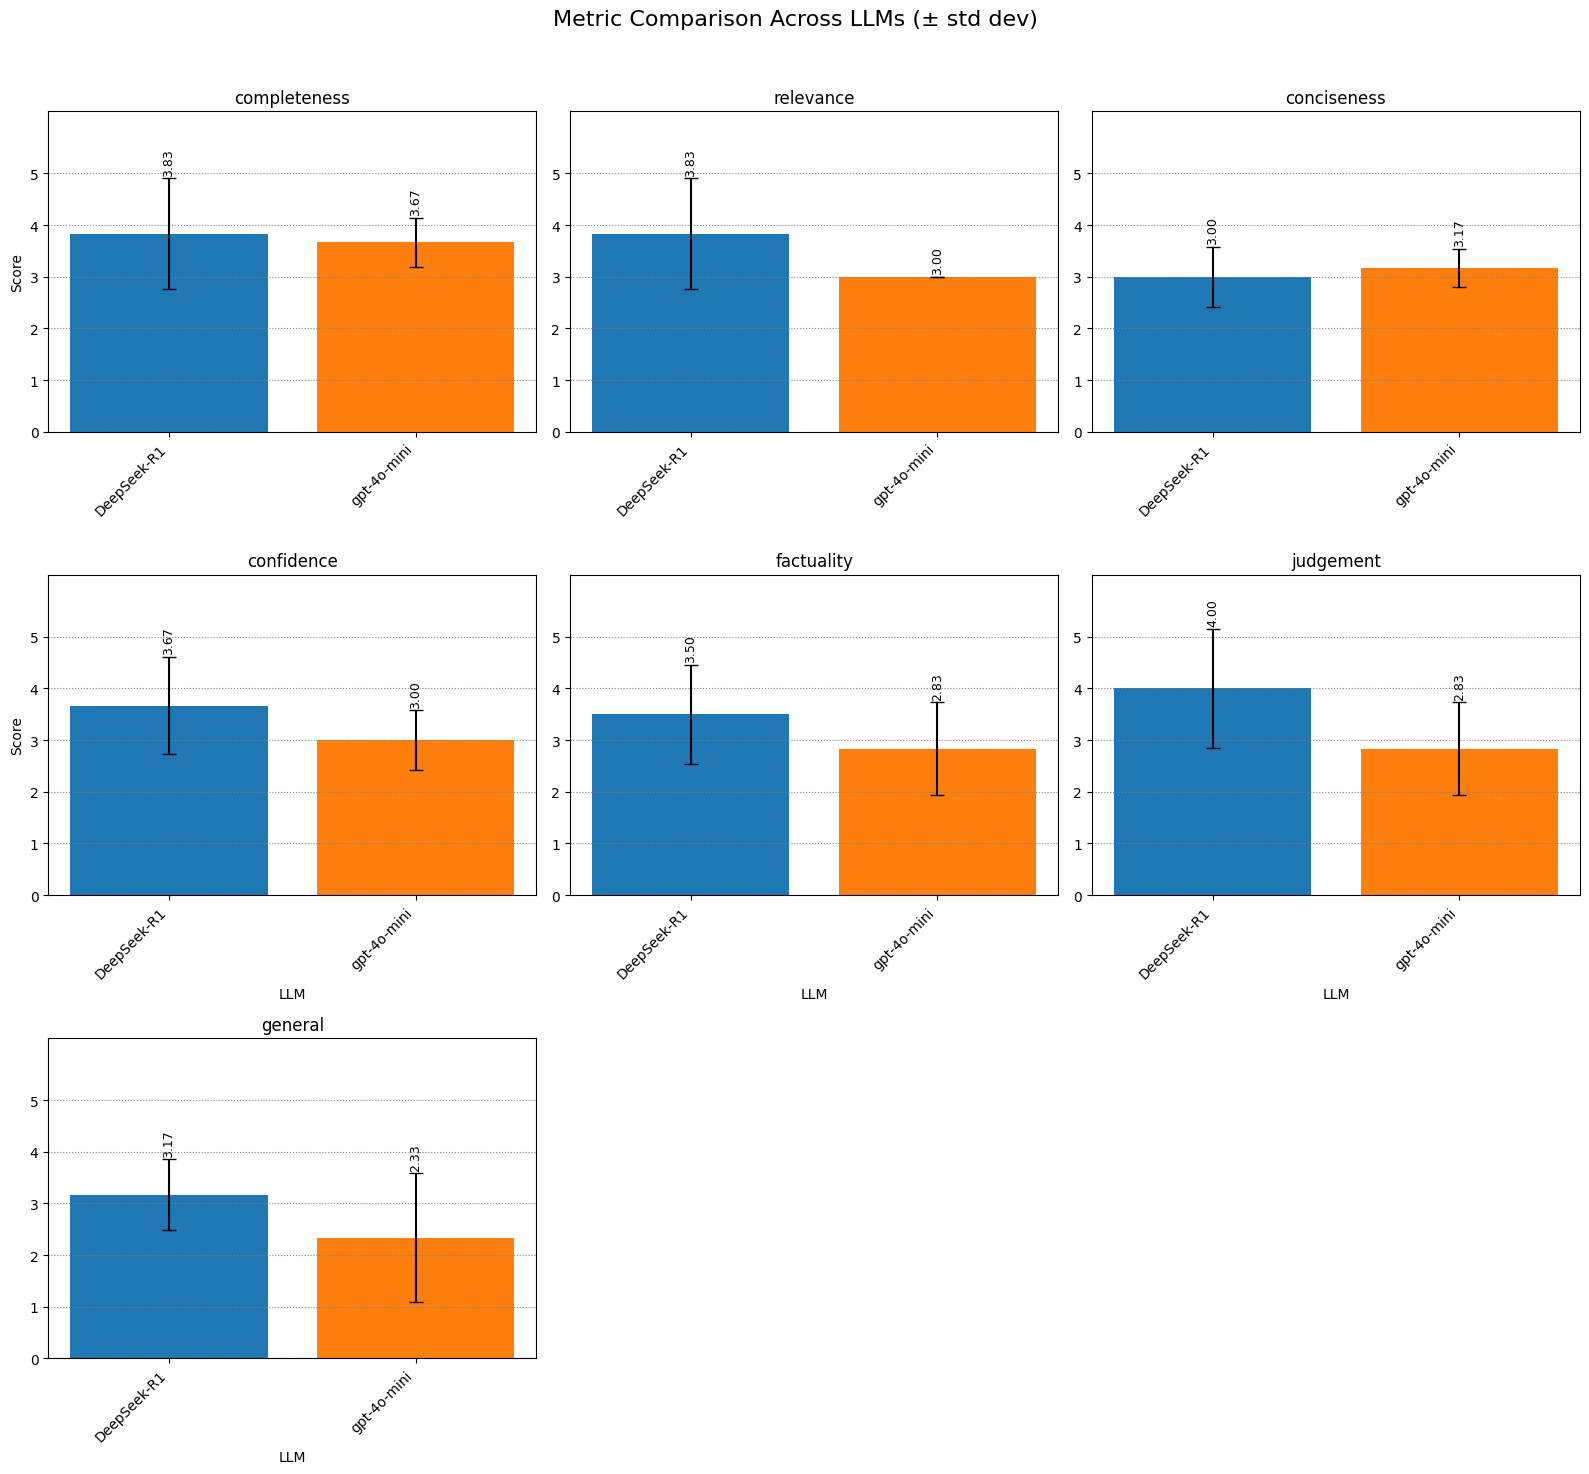

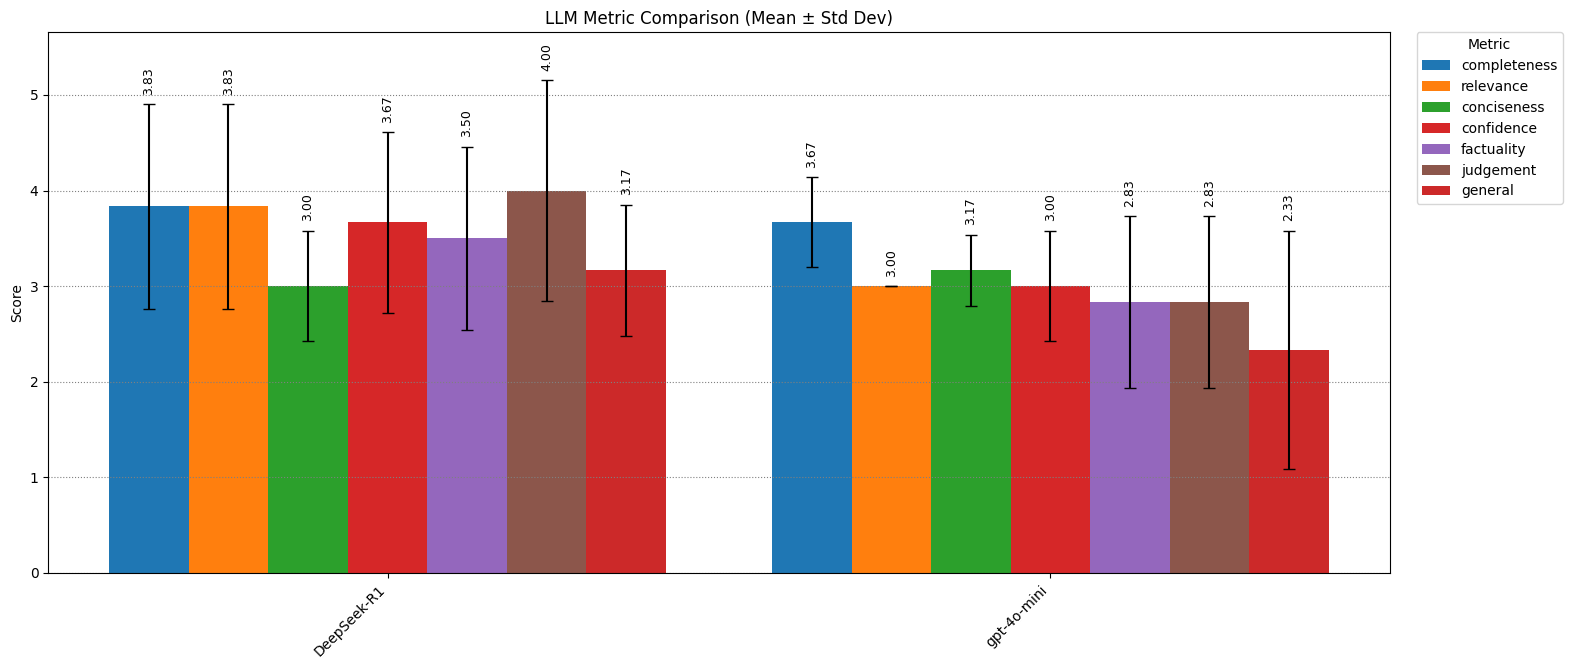

In [161]:
plot_model_comparison(model_names, list_of_metric_names, metric_means, metric_stds, save_prefix="_".join(judge_model.split('/')[1:]))

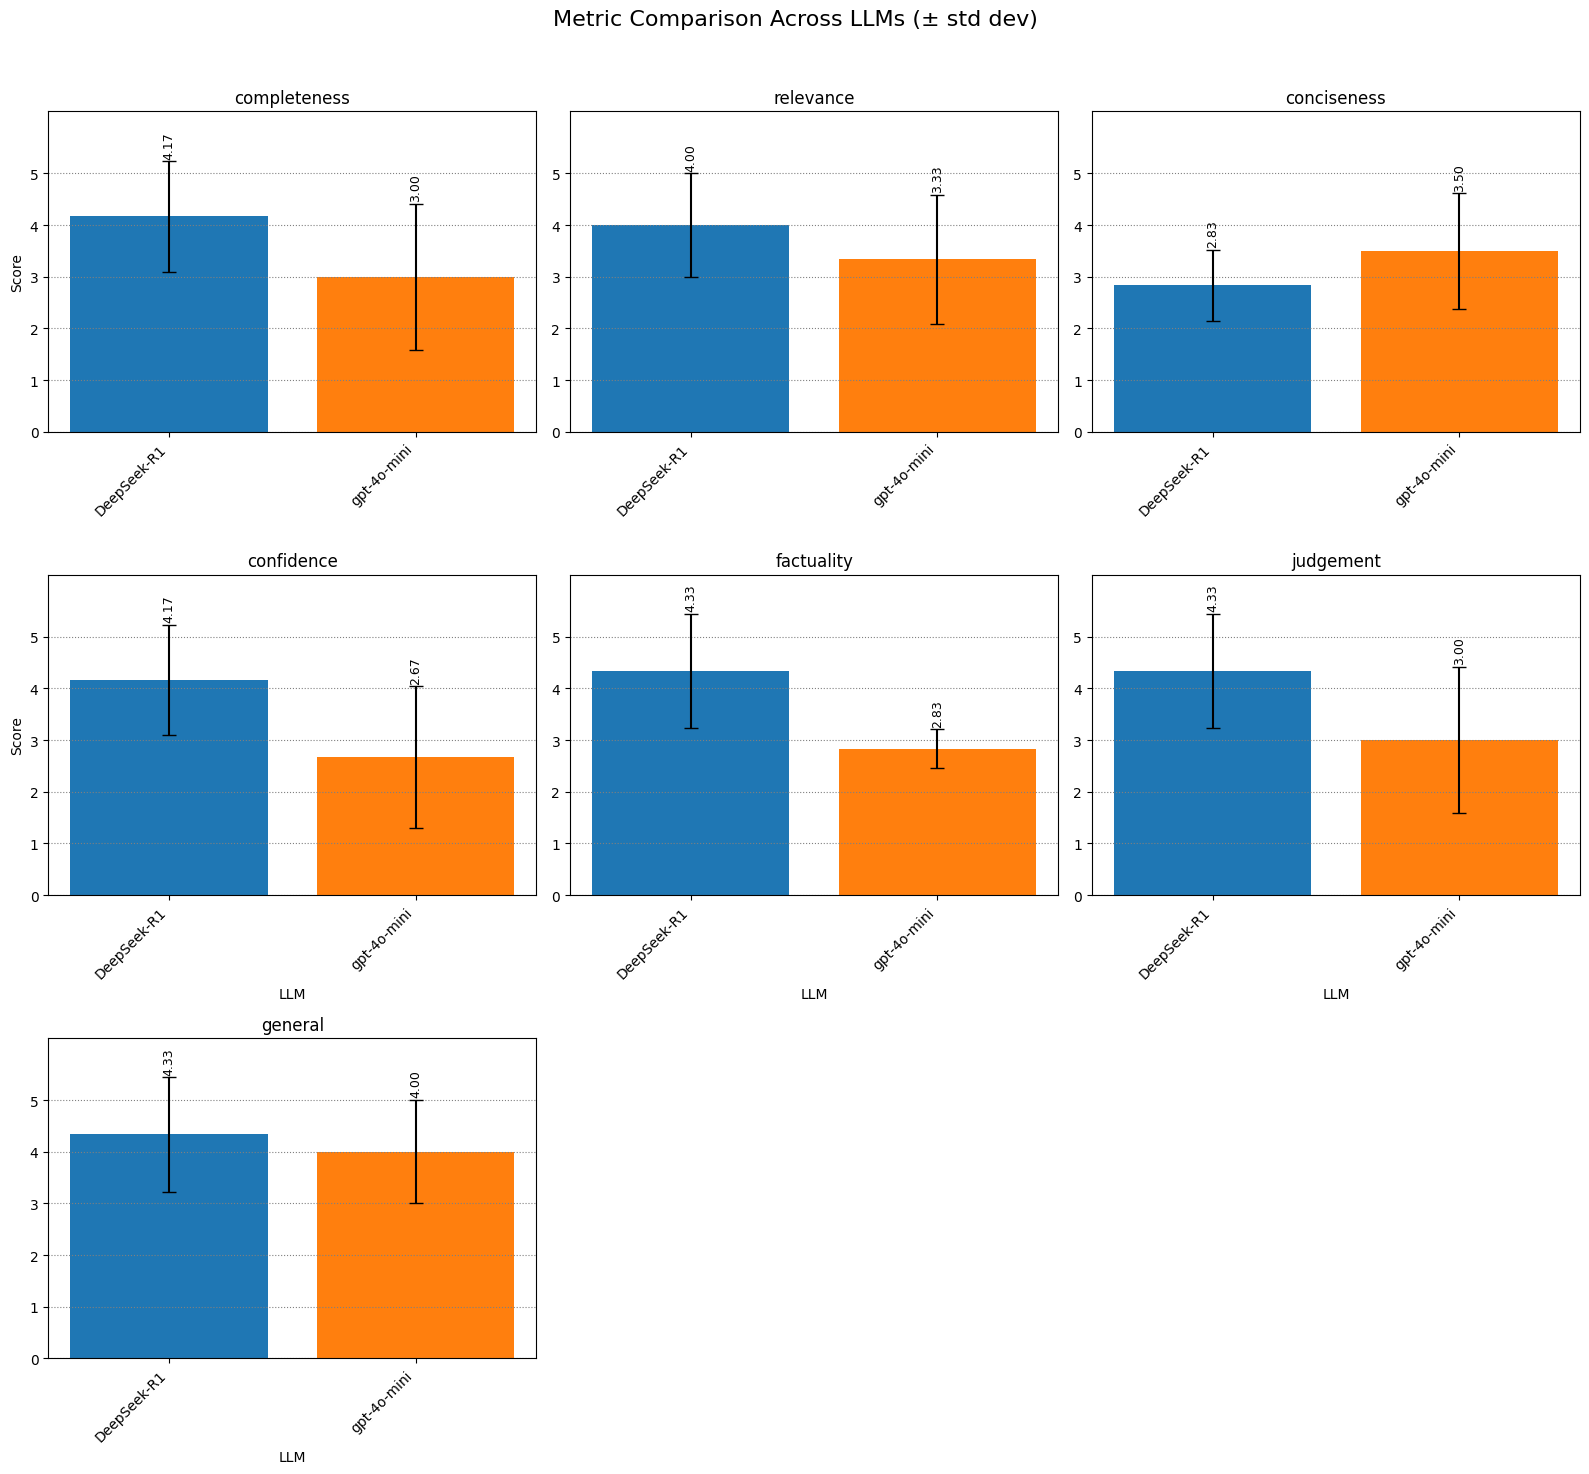

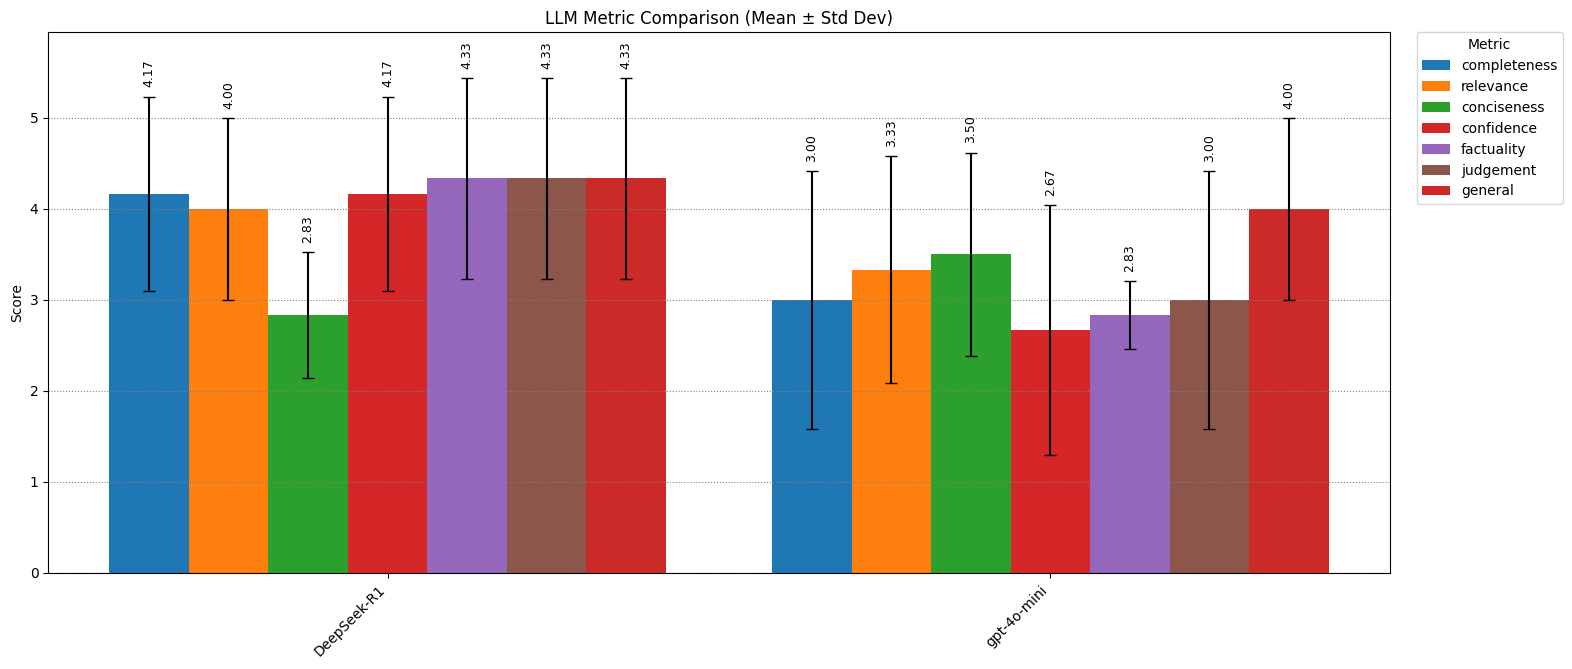

In [162]:
plot_model_comparison(model_names_second_judge, list_of_metric_names, metric_means_second_judge, metric_stds_second_judge, save_prefix="_".join(judge_model_2.split('/')[1:]))

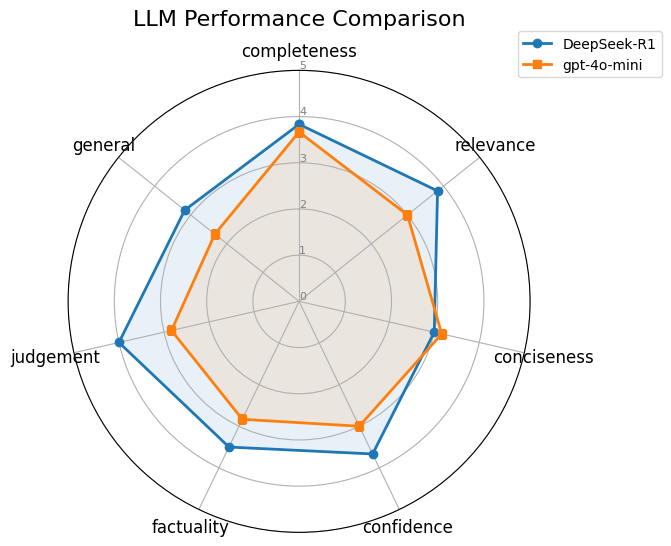

In [163]:
plot_spider_chart(model_names, list_of_metric_names, metric_means, save_prefix="_".join(judge_model.split('/')[1:]))

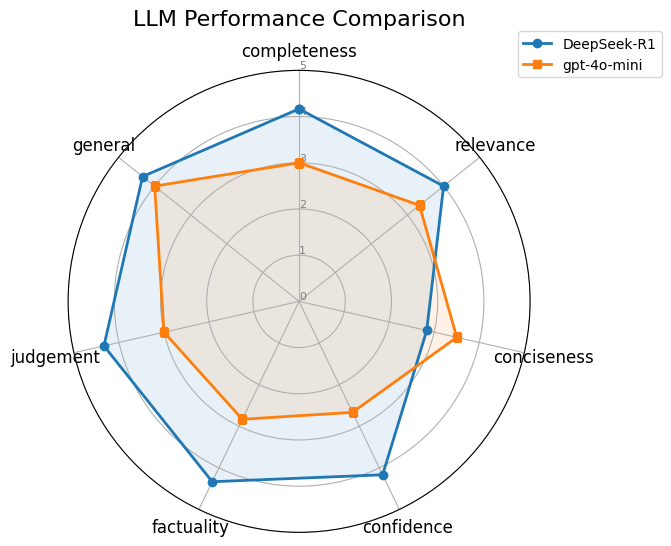

In [164]:
plot_spider_chart(model_names_second_judge, list_of_metric_names, metric_means_second_judge, save_prefix="_".join(judge_model_2.split('/')[1:]))

Statistical comparison between models

In [165]:
def compare_model_performances(all_runs_model_metrics, judge_model): 
    """
    Performs statistical comparison between models using paired differences, standard errors,
    and Pearson correlation coefficients following section 4.2 methodology.
    
    Args:
        all_runs_model_metrics (dict): Dictionary containing raw metrics for each model/run/question
        
    Returns:
        dict: Dictionary containing pairwise comparison results
    """
    import numpy as np
    from scipy import stats
    import itertools
    
    # Get all model pairs for comparison
    models = list(all_runs_model_metrics.keys())
    model_pairs = list(itertools.combinations(models, 2))
    
    # Store results
    comparison_results = {}
    
    for model1, model2 in model_pairs:
        judge_name = "_".join(judge_model.split('/')[1:])
        comparison_key = f"{model1.split('/')[-1]}_vs_{model2.split('/')[-1]}_with_{judge_name}"
        comparison_results[comparison_key] = {}
        
        # Get metrics (removing '_descr' suffix)
        metrics = [metric.replace('_descr', '') for metric in list(all_runs_model_metrics[model1][0].keys())]
        
        # Create file for this model comparison
        variance_results_text = f"\n=== Variance Analysis Results for {comparison_key} ===\n"
        
        for metric in metrics:
            # Calculate differences and correlations for each resample
            resample_differences = []
            resample_ses = []
            correlations = []
            model1_variances = []  # Initialize list
            model2_variances = []  # Initialize list
            
            # Iterate through resamples - Same number for both models
            for resample_idx in range(len(all_runs_model_metrics[model1])):
                # Get scores for both models for this resample
                scores1 = all_runs_model_metrics[model1][resample_idx][f'{metric}_descr']
                scores2 = all_runs_model_metrics[model2][resample_idx][f'{metric}_descr']
                
                # Calculate differences for each question
                question_differences = np.array(scores1) - np.array(scores2)
                
                # Calculate mean difference for this resample
                mean_diff = np.mean(question_differences) #Same as the formula in the paper since mean(a-b)=mean(a)-mean(b)
                
                # Calculate standard error for this resample - Paired analysis (section 4.2)
                n = len(question_differences)
                se = np.sqrt(np.sum((question_differences - mean_diff)**2) / (n * (n-1))) if n > 1 else np.nan

                # # Calculate standard errors for each model - Unpaired analysis (section 4.1)
                # n = len(scores1)
                # sea = np.sqrt(np.sum((scores1 - np.mean(scores1))**2) / (n * (n - 1))) if n > 1 else np.nan
                # seb = np.sqrt(np.sum((scores2 - np.mean(scores2))**2) / (n * (n - 1))) if n > 1 else np.nan

                # # Calculate the combined standard error as sqrt(sea^2 + seb^2)
                # se = np.sqrt(sea**2 + seb**2)

                # Calculate variances for each model
                var1 = np.var(scores1, ddof=1)  # Using ddof=1 for sample variance
                var2 = np.var(scores2, ddof=1)
                model1_variances.append(var1)
                model2_variances.append(var2)
                
                # Calculate Pearson correlation
                correlation, _ = stats.pearsonr(scores1, scores2)
                
                resample_differences.append(mean_diff)
                resample_ses.append(se)
                correlations.append(correlation)
            
            # Convert to numpy arrays
            resample_differences = np.array(resample_differences)
            resample_ses = np.array(resample_ses)
            correlations = np.array(correlations)
            model1_variances = np.array(model1_variances)
            model2_variances = np.array(model2_variances)
            print("resample_differences",resample_differences)
            print("resample_ses",resample_ses)
            print("correlations",correlations)
            print(f"Model 1 variances: {model1_variances}")
            print(f"Model 2 variances: {model2_variances}")
            with open(f"model_variances_{comparison_key}.txt", "a") as f:
                f.write(f"Model 1 variances: {model1_variances}\n")
                f.write(f"Model 2 variances: {model2_variances}\n")
                f.write(f"resample_differences: {resample_differences}\n")
                f.write(f"resample_ses: {resample_ses}\n")
                f.write(f"correlations: {correlations}\n")
          
            # Calculate overall mean difference over all resamples
            overall_mean_diff = np.mean(resample_differences)
            print("overall_mean_diff",overall_mean_diff)
            with open(f"model_variances_{comparison_key}.txt", "a") as f:
                f.write(f"overall_mean_diff: {overall_mean_diff}\n")
            
            #We want an aggregated SE across all resamples for the same questions (same paired differences)
            #This approach accounts for the fact that each resampling provides a different estimate of the variance of the same underlying distribution, 
            # and averaging these estimates gives a better representation of the overall uncertainty.

            # Calculate pooled standard error across resamples
            R = len(resample_differences)
            pooled_se = np.sqrt(np.sum(resample_ses**2) / (R**2))
            print("pooled_se",pooled_se)
            with open(f"model_variances_{comparison_key}.txt", "a") as f:
                f.write(f"pooled_se: {pooled_se}\n")
            
            # # If the resampling results are independent estimates of variance (i.e., combining uncertainty estimates from independent sources), the combined variance is
            # # the sum of all individual variances, and the combined standard error is given below (goal to capture total variability)
            # # Calculate the overall combined SE across all resamples
            # combined_se = np.sqrt(np.nansum(np.array(resample_ses)**2))

            # Calculate overall variance reduction across all resamples
            n = len(scores1)
            
            # Calculate mean variances across resamples
            mean_var1 = np.mean(model1_variances)  # Var(sA)
            mean_var2 = np.mean(model2_variances)  # Var(sB)
            
            # Calculate mean correlation across resamples
            mean_correlation = np.mean(correlations)
            
            # Calculate covariance between model scores
            mean_cov = mean_correlation * np.sqrt(mean_var1 * mean_var2)  # Cov(sA, sB)
            
            # Calculate variance for unpaired case: Var(μA-B,unpaired) = (Var(sA) + Var(sB))/n
            var_unpaired = (mean_var1 + mean_var2) / n
            
            # Calculate variance for paired case: Var(μA-B,paired) = (Var(sA) + Var(sB) - 2Cov(sA,sB))/n
            var_paired = (mean_var1 + mean_var2 - 2 * mean_cov) / n
            
            # The reduction in variance is: Var(μA-B,unpaired) - Var(μA-B,paired) = 2Cov(xA,xB)/n
            variance_reduction = 2 * mean_cov / n  # This should equal var_unpaired - var_paired
            
            # Calculate percentage reduction in variance
            percent_reduction = (variance_reduction / var_unpaired) * 100 if var_unpaired != 0 else 0

            # Add results for this metric to the text
            variance_results_text += f"\nMetric: {metric}\n"
            variance_results_text += f"Mean Model 1 variance (Var(sA)): {mean_var1:.6f}\n"
            variance_results_text += f"Mean Model 2 variance (Var(sB)): {mean_var2:.6f}\n"
            variance_results_text += f"Mean covariance (Cov(sA,sB)): {mean_cov:.6f}\n"
            variance_results_text += f"Unpaired variance: {var_unpaired:.6f}\n"
            variance_results_text += f"Paired variance: {var_paired:.6f}\n"
            variance_results_text += f"Variance reduction (2Cov(xA,xB)/n): {variance_reduction:.6f}\n"
            variance_results_text += f"Percent reduction: {percent_reduction:.1f}%\n"

            # # Calculate t-statistic and p-value
            # t_stat = overall_mean_diff / pooled_se if pooled_se != 0 else np.nan
            # df = R - 1  # degrees of freedom
            # p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if not np.isnan(t_stat) else np.nan
            
            # # Calculate confidence interval
            # t_crit = stats.t.ppf(0.975, df)  # 95% CI
            # ci_margin = t_crit * pooled_se

            # Calculate z-statistic and CI using standard normal distribution
            z_stat = overall_mean_diff / pooled_se if pooled_se != 0 else np.nan
            
            # Calculate confidence interval using 1.96 for 95% CI
            ci_margin = 1.96 * pooled_se
            
            # Calculate p-value using standard normal distribution
            #For a two-tailed test p = 2 × (1 − Φ(|z|)), where Φ(z) is the cumulative distribution function (CDF) of the standard normal distribution.
            p_value = 2 * (1 - stats.norm.cdf(abs(z_stat))) if not np.isnan(z_stat) else np.nan
            
            # # Calculate average Pearson correlation - not accurate when correlations close to 1 or -1, variances differences across resamples, sample size is small.
            # avg_correlation = np.mean(correlations)

            #Apply Fisher z-transformation
            z_values = [0.5 * np.log((1 + r) / (1 - r)) for r in correlations]

            # Compute the mean Fisher z-value
            z_mean = np.mean(z_values)

            #Back-transform to Pearson correlation scale
            overall_correlation = (np.exp(2 * z_mean) - 1) / (np.exp(2 * z_mean) + 1)
            
            # Store results
            comparison_results[comparison_key][metric] = {
                "mean_difference": overall_mean_diff,
                "pooled_standard_error": pooled_se,
                "ci_low": overall_mean_diff - ci_margin,
                "ci_high": overall_mean_diff + ci_margin,
                # "t_statistic": t_stat,
                "z_statistic": z_stat,
                "p_value": p_value,
                "significant": p_value < 0.05 if not np.isnan(p_value) else None,
                "better_model": model1.split('/')[-1] if overall_mean_diff > 0 else model2.split('/')[-1],
                "pearson_correlation": overall_correlation
            }
        
        # Write all metrics results for this model comparison to a single file
        with open(f'variance_results_{comparison_key}.txt', 'w') as f:
            variance_results_text += f"Overall Variance Reduction Analysis:\n"
            f.write(variance_results_text)
    
    return comparison_results

comparison_results = compare_model_performances(all_runs_model_metrics, judge_model) 

# Save results to file
with open('comparison_result_'+"_".join(judge_model.split('/')[1:])+".json", 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.bool_)):
            return bool(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        elif obj is None:
            return None
        return obj
    
    serializable_results = json.loads(
        json.dumps(comparison_results, default=convert_to_serializable)
    )
    json.dump(serializable_results, f, indent=4)

resample_differences [-0.33333333  0.66666667]
resample_ses [0.8819171  0.33333333]
correlations [      nan 0.8660254]
Model 1 variances: [2.33333333 1.        ]
Model 2 variances: [0.         0.33333333]
overall_mean_diff 0.16666666666666666
pooled_se 0.4714045207910317
resample_differences [0.33333333 1.33333333]
resample_ses [0.8819171  0.33333333]
correlations [nan nan]
Model 1 variances: [2.33333333 0.33333333]
Model 2 variances: [0. 0.]
overall_mean_diff 0.8333333333333333
pooled_se 0.4714045207910317
resample_differences [-0.33333333  0.        ]
resample_ses [0.33333333 0.57735027]
correlations [ nan -0.5]
Model 1 variances: [0.33333333 0.33333333]
Model 2 variances: [0.         0.33333333]
overall_mean_diff -0.16666666666666666
pooled_se 0.3333333333333333
resample_differences [1.         0.33333333]
resample_ses [1.         0.33333333]
correlations [-0.18898224  0.5       ]
Model 1 variances: [2.33333333 0.33333333]
Model 2 variances: [0.33333333 0.33333333]
overall_mean_diff

In [166]:
comparison_results_second_judge = compare_model_performances(all_runs_model_metrics_judge2, judge_model_2)

# Save results to file
with open('comparison_result_'+'_'.join(judge_model_2.split('/')[1:])+'.json', 'w') as f:
   
    serializable_results_second_judge = json.loads(
        json.dumps(comparison_results_second_judge, default=convert_to_serializable)
    )
    json.dump(serializable_results_second_judge, f, indent=4)

resample_differences [0.         2.33333333]
resample_ses [1.15470054 0.8819171 ]
correlations [-0.75592895  0.97072534]
Model 1 variances: [2.33333333 0.33333333]
Model 2 variances: [0.33333333 4.33333333]
overall_mean_diff 1.1666666666666667
pooled_se 0.7264831572567789
resample_differences [0.33333333 1.        ]
resample_ses [1.33333333 1.        ]
correlations [-0.14285714 -0.18898224]
Model 1 variances: [2.33333333 0.33333333]
Model 2 variances: [2.33333333 2.33333333]
overall_mean_diff 0.6666666666666666
pooled_se 0.8333333333333334
resample_differences [-1.         -0.33333333]
resample_ses [0.57735027 0.8819171 ]
correlations [ 0.94491118 -0.5       ]
Model 1 variances: [0.33333333 0.33333333]
Model 2 variances: [2.33333333 1.33333333]
overall_mean_diff -0.6666666666666666
pooled_se 0.5270462766947298
resample_differences [1. 2.]
resample_ses [1.         0.57735027]
correlations [0.5        0.94491118]
Model 1 variances: [3.         0.33333333]
Model 2 variances: [3.         2

In [167]:
def plot_and_save_model_comparisons(comparison_results, list_of_metrics, suffix):
    # Extract metrics and models from comparison_results
    metrics = [metric.replace('_descr', '') for metric in list_of_metrics]
    model_pairs = list(comparison_results.keys())

    # Create figure with subplots for each metric
    # Calculate number of rows needed based on number of metrics
    num_metrics = len(metrics)
    num_rows = (num_metrics + 2) // 3  # Using 3 columns, calculate rows needed (ceiling division)
    fig, axes = plt.subplots(num_rows, 3, figsize=(25, 20 * num_rows / 2), dpi=600)  # Adjusted figsize proportionally
    fig.suptitle('Model Comparison Results by Metric for judge model '+suffix, fontsize=16, y=1.05)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Extract data for this metric
        means = []
        cis = []
        labels = []
        
        for pair in model_pairs:
            metric_data = comparison_results[pair][metric]
            means.append(metric_data['mean_difference'])
            # ci_margin = metric_data['ci_margin']
            cis.append([metric_data['ci_low'], 
                       metric_data['ci_high']])
            labels.append(pair.split('with')[0].strip()) #Append only the model name comparisons

        # Create bar plot
        bars = ax.bar(range(len(means)), means)
        
        # Add error bars for confidence intervals
        ax.errorbar(range(len(means)), means, 
                   yerr=[[m - ci[0] for m, ci in zip(means, cis)],
                         [ci[1] - m for m, ci in zip(means, cis)]],
                   fmt='none', color='black', capsize=5)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Customize plot
        ax.set_title(f'{metric.capitalize()}')
        ax.set_xticks(range(len(means)))
        ax.set_xticklabels(labels, rotation=90) # Changed to vertical labels
        ax.set_ylabel('Mean Difference')
        
        # Color bars based on statistical significance
        for j, bar in enumerate(bars):
            if comparison_results[model_pairs[j]][metric]['p_value'] < 0.05:
                bar.set_color('darkred')
            else:
                bar.set_color('lightgray')

    # Hide any unused subplots
    for i in range(num_metrics, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()

    # Save plot before showing with high resolution
    plt.savefig(f'model_comparisons_{suffix}.png', bbox_inches='tight', dpi=600)  # Increased DPI for higher resolution

    # Show plot after saving
    plt.show()

In [168]:
plot_and_save_model_comparisons(comparison_results, list_of_metrics, "_".join(judge_model.split('/')[1:]))

In [169]:
plot_and_save_model_comparisons(comparison_results_second_judge, list_of_metrics, "_".join(judge_model_2.split('/')[1:]))

Add ID and origin file columns to final dfs

In [170]:
def load_data(file_path):
    """
    Corresponds to the notebook cell "Read Excel File".
    Reads the specified Excel file and returns a DataFrame with 'input' and 'output' columns.
    """
    qa = pd.read_excel(file_path)
    try:
        qa=qa[['id', 'origin_file','input', 'output']]
        with open('columns_found.txt', 'a', encoding='utf-8') as f:
            f.write(f"id, origin_file, input, output columns found \n")
    except:
        qa = qa[['input', 'output']]
        print("Only input and output columns found")
        with open('columns_found.txt', 'a', encoding='utf-8') as f:
            f.write(f"Only input and output columns found \n")
        
    return qa

In [171]:
def add_id_and_origin_file_columns(save_dir, excel_file_name):
    """
    Add id and origin_file columns to all results_*.xlsx files in the specified directory.
    
    Args:
        save_dir (str): Directory path containing the results files
        excel_file_name (str): Path to the original Excel file containing the dataset
    """
    # Load original data for matching
    original_data = load_data(excel_file_name)
    
    # Find all xlsx files matching the pattern
    xlsx_files = glob.glob(os.path.join(save_dir, 'results_*.xlsx'))
    
    for xlsx_file in xlsx_files:
        print('Processing xlsx_file:', xlsx_file)
        # Read the results file
        results_df = pd.read_excel(xlsx_file)
        
        if 'questions' in results_df.columns:
            # Create lists to store the new column values
            ids = []
            origin_files = []
            
            # For each question in the results file
            for question in results_df['questions']:
                # Find matching row in dataset_test, handling potential extra newlines and whitespace
                question_cleaned = ' '.join(question.strip().split())
                matching_row = original_data[original_data['input'].apply(lambda x: ' '.join(str(x).strip().split()) == question_cleaned)]
                
                if not matching_row.empty:
                    # Get the first match (in case of duplicates)
                    ids.append(matching_row.iloc[0]['id'])
                    origin_files.append(matching_row.iloc[0]['origin_file'])
                else:
                    # If no match found, append None or empty string
                    ids.append(' ')
                    origin_files.append(' ')
            
            # Insert the new columns at the beginning of the dataframe
            results_df.insert(0, 'origin_file', origin_files)
            results_df.insert(0, 'id', ids)
            
            # Save the updated dataframe back to the xlsx file
            output_file = os.path.join(save_dir, 'final_' + os.path.basename(xlsx_file))
            results_df.to_excel(output_file, index=False)
            print(f"Updated {xlsx_file} with id and origin_file columns, saved as {output_file}")

In [172]:
add_id_and_origin_file_columns(base_path, excel_file_name)

Processing xlsx_file: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/results_deepseek-ai_DeepSeek-V3_judge_with_openai_gpt-4o-mini.xlsx
Updated /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/results_deepseek-ai_DeepSeek-V3_judge_with_openai_gpt-4o-mini.xlsx with id and origin_file columns, saved as /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/final_results_deepseek-ai_DeepSeek-V3_judge_with_openai_gpt-4o-mini.xlsx
Processing xlsx_file: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/results_gpt-4o-mini_judge_with_together_deepseek-ai_DeepSeek-R1.xlsx
Updated /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/results_gpt-4o-mini_judge_with_together_deepseek-ai_DeepSeek-R1.xlsx with id and origin_file columns, saved as /Users/nikolaossourlo/Desktop/LLM_evaluation_framework/data/final_results_gpt-4o-mini_judge_with_together_deepseek-ai_DeepSeek-R1.xlsx
Processing xlsx_file: /Users/nikolaossourlo/Desktop/LLM_evaluation_framework

Create Tables

In [173]:
def create_comparison_table(comparison_results, metrics):
    """
    Creates a formatted table from comparison results.
    
    Args:
        comparison_results (dict): The comparison results dictionary
        metrics (list): List of metrics to include
        
    Returns:
        str: Formatted markdown table
    """
    # Table header
    table = "| Metric | Model | Baseline | Model - Baseline | 95% Conf. Interval | Correlation |\n"
    table += "|--------|--------|-----------|-----------------|-------------------|-------------|\n"
    
    # Add rows for each comparison and metric
    for pair in comparison_results:
        model1, model2 = pair.split('_vs_')
        for metric in metrics:
            results = comparison_results[pair][metric]
            
            row = f"| {metric} | {model1} | {model2} | "
            row += f"{results['mean_difference']:.1%} | "
            row += f"({results['ci_low']:.1%}, {results['ci_high']:.1%}) | "
            row += f"{results['pearson_correlation']:.2f} |\n"
            
            table += row
            
    return table

# Create and print the table
metrics = [m.replace('_descr', '') for m in list_of_metrics]
comparison_table = create_comparison_table(comparison_results, metrics)
print(comparison_table)

# Save table to file
with open('comparison_table_'+'_'.join(judge_model.split('/')[1:])+'.txt', 'w') as f:
    f.write(comparison_table)

| Metric | Model | Baseline | Model - Baseline | 95% Conf. Interval | Correlation |
|--------|--------|-----------|-----------------|-------------------|-------------|
| completeness | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 16.7% | (-75.7%, 109.1%) | nan |
| relevance | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 83.3% | (-9.1%, 175.7%) | nan |
| conciseness | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | -16.7% | (-82.0%, 48.7%) | nan |
| confidence | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 66.7% | (-36.6%, 170.0%) | 0.18 |
| factuality | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 66.7% | (-36.6%, 170.0%) | 0.55 |
| judgement | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 116.7% | (13.4%, 220.0%) | nan |
| general | DeepSeek-R1 | gpt-4o-mini_with_gpt-4o-mini | 83.3% | (-34.4%, 201.1%) | 0.59 |



In [174]:
comparison_table_second_judge = create_comparison_table(comparison_results_second_judge, metrics)
print(comparison_table_second_judge)

# Save table to file
with open('comparison_table_'+'_'.join(judge_model_2.split('/')[1:])+'.txt', 'w') as f:
    f.write(comparison_table_second_judge)

| Metric | Model | Baseline | Model - Baseline | 95% Conf. Interval | Correlation |
|--------|--------|-----------|-----------------|-------------------|-------------|
| completeness | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 116.7% | (-25.7%, 259.1%) | 0.51 |
| relevance | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 66.7% | (-96.7%, 230.0%) | -0.17 |
| conciseness | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | -66.7% | (-170.0%, 36.6%) | 0.55 |
| confidence | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 150.0% | (36.8%, 263.2%) | 0.82 |
| factuality | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 150.0% | (52.0%, 248.0%) | nan |
| judgement | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 133.3% | (2.7%, 264.0%) | 0.50 |
| general | DeepSeek-R1 | gpt-4o-mini_with_deepseek-ai_DeepSeek-V3 | 33.3% | (-59.1%, 125.7%) | nan |



Power Analysis

In [175]:
def perform_power_analysis(effect_size=0.5, alpha=0.05, power=0.8):
    """
    Perform power analysis to determine required sample size.
    
    Args:
        effect_size (float): Expected effect size (Cohen's d)
        alpha (float): Significance level
        power (float): Desired statistical power
        
    Returns:
        int: Required sample size per group
    """
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        alternative='two-sided'
    )
    return int(np.ceil(sample_size))

# First, determine required sample size
required_samples = perform_power_analysis(effect_size=0.1254, alpha=0.05, power=0.8)  #These parameters result in a sample size of 1000
print(f"Required samples per model for statistical power: {required_samples}")

Required samples per model for statistical power: 1000


For real-time inference (below implementation only for meta-llama/Meta-Llama-3.1-8B-Instruct)

In [176]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch
# # del pipeline #Otherwise too much memory is used

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name,device_map='auto')

# #Example of real-time response generation
# messages=[{"role": "user", "content": "What is the chemical formula of water?"}]

# inputs_tokenized = tokenizer.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_tensors="pt",
#     return_dict=True,
# ).to("cuda")

# input_ids = inputs_tokenized['input_ids']

# # Generate tokens one by one
# max_length = 256
# output_ids = input_ids
# for _ in range(256):
#     outputs = model.generate(
#         output_ids,
#         max_new_tokens=1,
#         do_sample=True,
#         top_k=50,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     new_token_id = outputs[0, -1].item()
#     if new_token_id == tokenizer.eos_token_id:
#         break
#     output_ids = torch.cat([output_ids, outputs[:, -1:]], dim=1)
#     new_token = tokenizer.decode(new_token_id, skip_special_tokens=True)
#     print(new_token, end="", flush=True)

# print()

Other evaluators from Langsmith

In [177]:
# https://docs.smith.langchain.com/old/evaluation/faq/evaluator-implementations
# https://docs.smith.langchain.com/old/evaluation/quickstart

# from langsmith.evaluation import LangChainStringEvaluator

# eval_llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0.0, seed=42)

# #Evaluators
# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm}) #LLM just gives 'correct' or 'incorrect' based on reference answer
# context_qa_evaluator = LangChainStringEvaluator("context_qa", config={"llm": eval_llm}) #Also uses reference context of example outputs to do the above
# cot_qa_evaluator = LangChainStringEvaluator("cot_qa", config={"llm": eval_llm}) #Same as above but with chain of thought 'reasoning'

#Prompts Used internally:

# 1) context_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. 
# It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 2) cot_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.
# Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# EXPLANATION: step by step reasoning here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 3) qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the student's answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.

# Example Format:
# QUESTION: question here
# STUDENT ANSWER: student's answer here
# TRUE ANSWER: true answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 

Alternatively, use custom prompts as shown below (and set {"prompt": PROMPT} as additional argument inside the config above)

In [178]:
# from langchain_core.prompts.prompt import PromptTemplate

# _PROMPT_TEMPLATE = """You are an expert professor specialized in chemical engineering answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "result", "answer"], template=_PROMPT_TEMPLATE
# )